In [31]:
import torch
import numpy as np
from transformers import (AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, LlamaForCausalLM,
                          GPTNeoForCausalLM, GPT2TokenizerFast,LlamaConfig,AutoConfig)
import os
import random
from typing import *
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch.nn as nn
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer, BloomForCausalLM
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
import numpy as np
from utils.model_utils import load_gpt_model_and_tokenizer, make_inputs, decode_tokens, predict_from_input
from transformers import AutoConfig, AutoTokenizer
import matplotlib.pyplot as plt
import os
import seaborn as sns

from utils.evaluation_lm_eval import run_eval_harness
from utils.trace_utils import TraceDict2
from gpt_neo import load_model,plt_heatMap_sns,plot_umap, plot_dist
import pandas as pd

In [32]:
# 第九部分 替换第一个token的hidden state为last token的hidden state, 查看attn热力图
device_str = 'cuda:1'
layers, train_layers, is_linear = [] , [], 'linear_atten'
model_name = 'EleutherAI/gpt-j-6b' # 'EleutherAI/gpt-neo-1.3B'  # facebook/opt-13b# 'mistralai/Mistral-7B-v0.1' 'openai-community/gpt2-xl' #'EleutherAI/gpt-j-6b' # 'EleutherAI/gpt-neo-1.3B' # 'EleutherAI/gpt-neo-125m'
model, tokenizer, MODEL_CONFIG = load_model(model_name, device=device_str, layers=layers, train_layers=train_layers,
                                            is_linear=is_linear, show_params=False)

n_layers, n_heads = MODEL_CONFIG['n_layers'], MODEL_CONFIG['n_heads']
prompt = 'The Space Needle is in downtown' # 'The Space Needle is in downtown' # 'Beats Music is owned by', 'Beats Music is owned by Apple and the Space Needle is in downtown'
target_token = 'Apple'
x_ticks = [f"layer{i + 1}" for i in range(n_layers)]
save_path = os.path.join(sys.path[0], './result/hidden_attn_heat')
encoded_line = tokenizer.encode(prompt)
codes = tokenizer.convert_ids_to_tokens(encoded_line)
y_ticks = [f"head{i_head}-{c}" for i_head in range(n_heads) for i, c in enumerate(codes)]
check_token_id = -1


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
def try_hook4(model, tokenizer, model_config, prompt, check_token_id, device):

        def modify(layer_ids, token_id, n_heads, check_token_id, device):
            def modify_output(output, layer_name, inputs):
                current_layer = int(layer_name.split(".")[2])
                # if current_layer == edit_layer:
                #     if isinstance(output, tuple):
                #         output[0][:, idx] += fv_vector.to(device)
                #         return output
                #     else:
                #         return output
                # else:
                #     return output
                return output

            def modify_input(input, layer_name):
                # print(layer_name)
                # for layer_id in layer_ids:
                #     if str(layer_id) in layer_name.split('.'):
                # heads_range = range(n_heads)
                input[:, 0, :] = input[:, 4, :]
                # input[:, 4, :] = input[:, -1, :]
                return input

            return modify_output, modify_input
        model.eval()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with TraceDict2(model, layers=model_config['q_names'], retain_output=True) as ret:
            output_and_cache = model(**inputs, output_hidden_states=True, output_attentions=True)
            q_list = [ret[q].output for q in model_config['q_names']]
            past_qs = torch.cat(q_list, dim=0).detach().cpu().numpy()
            past_qs = np.transpose(np.reshape(past_qs,newshape=past_qs.shape[:-1]+(n_heads, -1)),(0,2,1,3))
        ground_attentions = torch.cat(output_and_cache.attentions, dim=0).cpu()
        hidden_state = torch.cat(output_and_cache.hidden_states, dim=0).detach().cpu().numpy()
        past_key = torch.cat([key_values[0] for key_values in output_and_cache.past_key_values], dim=0).detach().cpu().numpy()
        past_values = torch.cat([key_values[1] for key_values in output_and_cache.past_key_values], dim=0).detach().cpu().numpy()

        token_id, layer_ids = 0, range(3, model_config['n_layers']-1)
        modify_output, modify_input = modify(layer_ids, token_id, model_config['n_heads'],  check_token_id , device)
        with TraceDict2(model, layers=model_config['k_q_names'], edit_input=modify_input,
                        edit_output=modify_output, retain_output=True) as ret:
            output_and_cache = model(**inputs,output_attentions=True,output_hidden_states=True)
            change_attentions = torch.stack(output_and_cache.attentions, dim=0)[:,0].cpu()
            change_hidden_state = torch.cat(output_and_cache.hidden_states, dim=0).detach().cpu().numpy()
            q_list = [ret[q].output for q in model_config['q_names']]
            change_past_qs = torch.cat(q_list, dim=0).detach().cpu().numpy()
            change_past_qs = np.transpose(np.reshape(change_past_qs,newshape=change_past_qs.shape[:-1]+(n_heads, -1)),(0,2,1,3))
            change_past_key = torch.cat([key_values[0] for key_values in output_and_cache.past_key_values], dim=0).detach().cpu().numpy()
            change_past_values = torch.cat([key_values[1] for key_values in output_and_cache.past_key_values], dim=0).detach().cpu().numpy()
        return hidden_state, ground_attentions.detach().numpy(), change_hidden_state,change_attentions.detach().numpy(), past_key, past_values, past_qs,change_past_key, change_past_values, change_past_qs

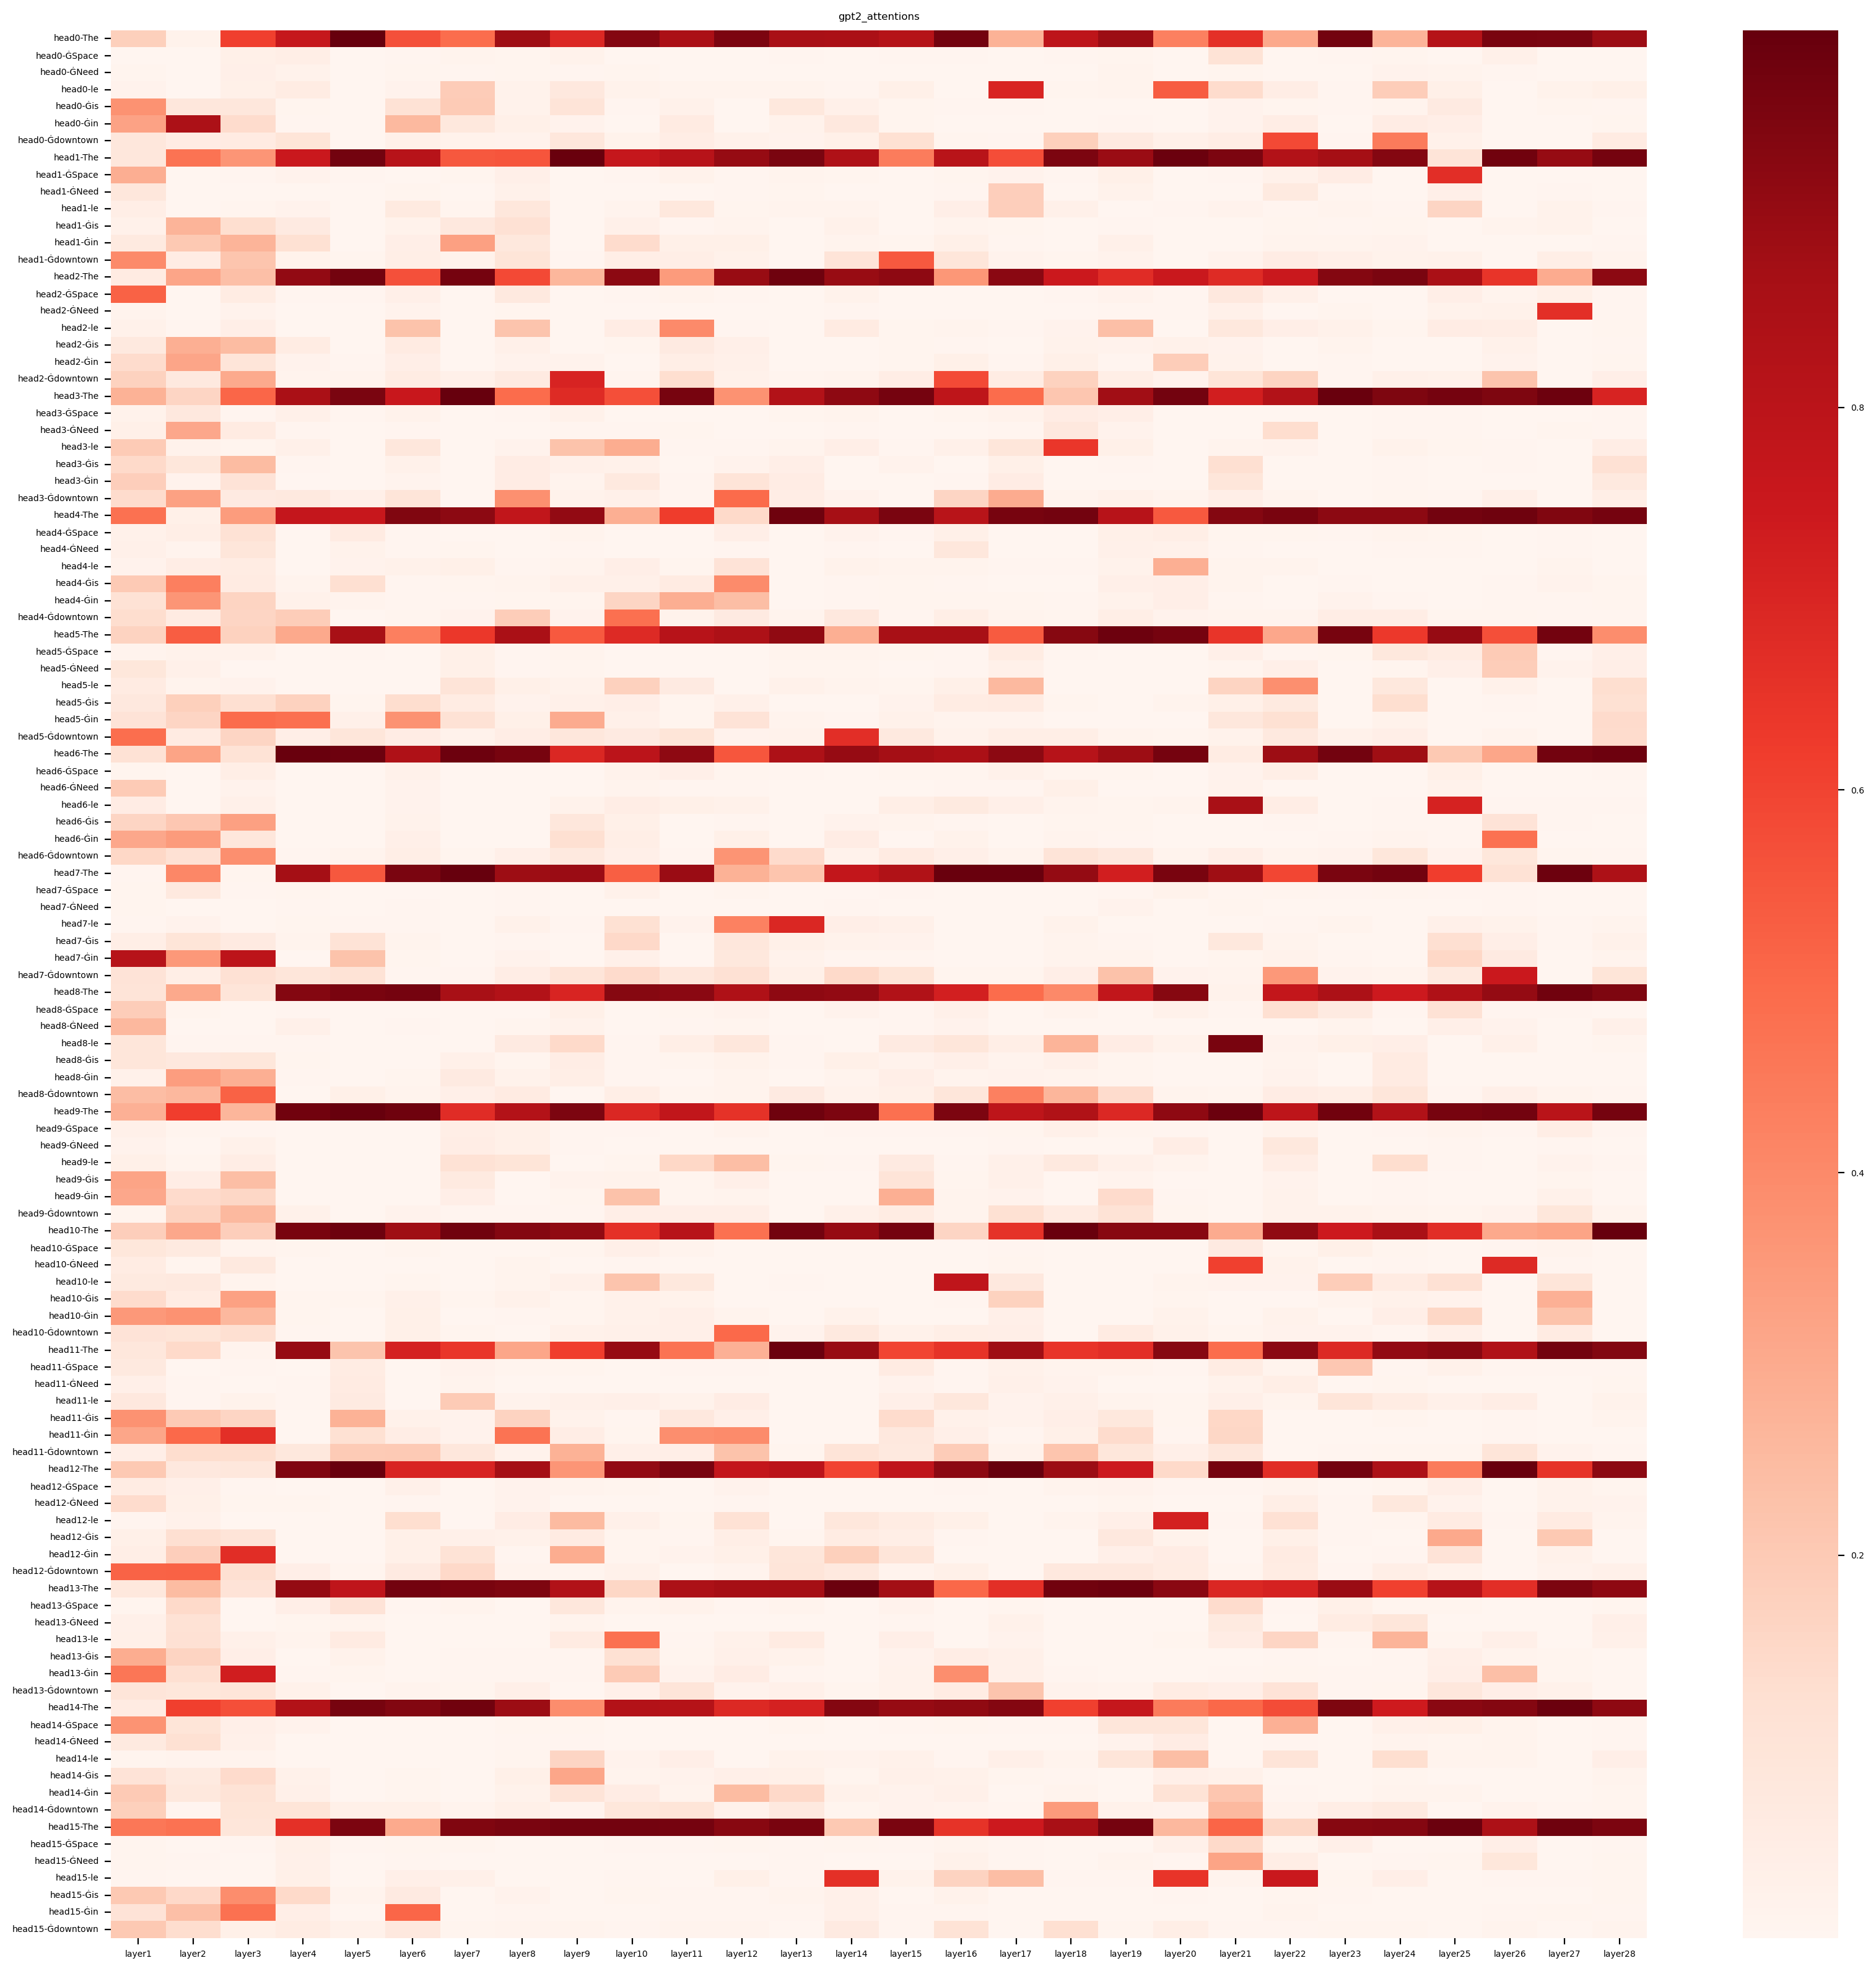

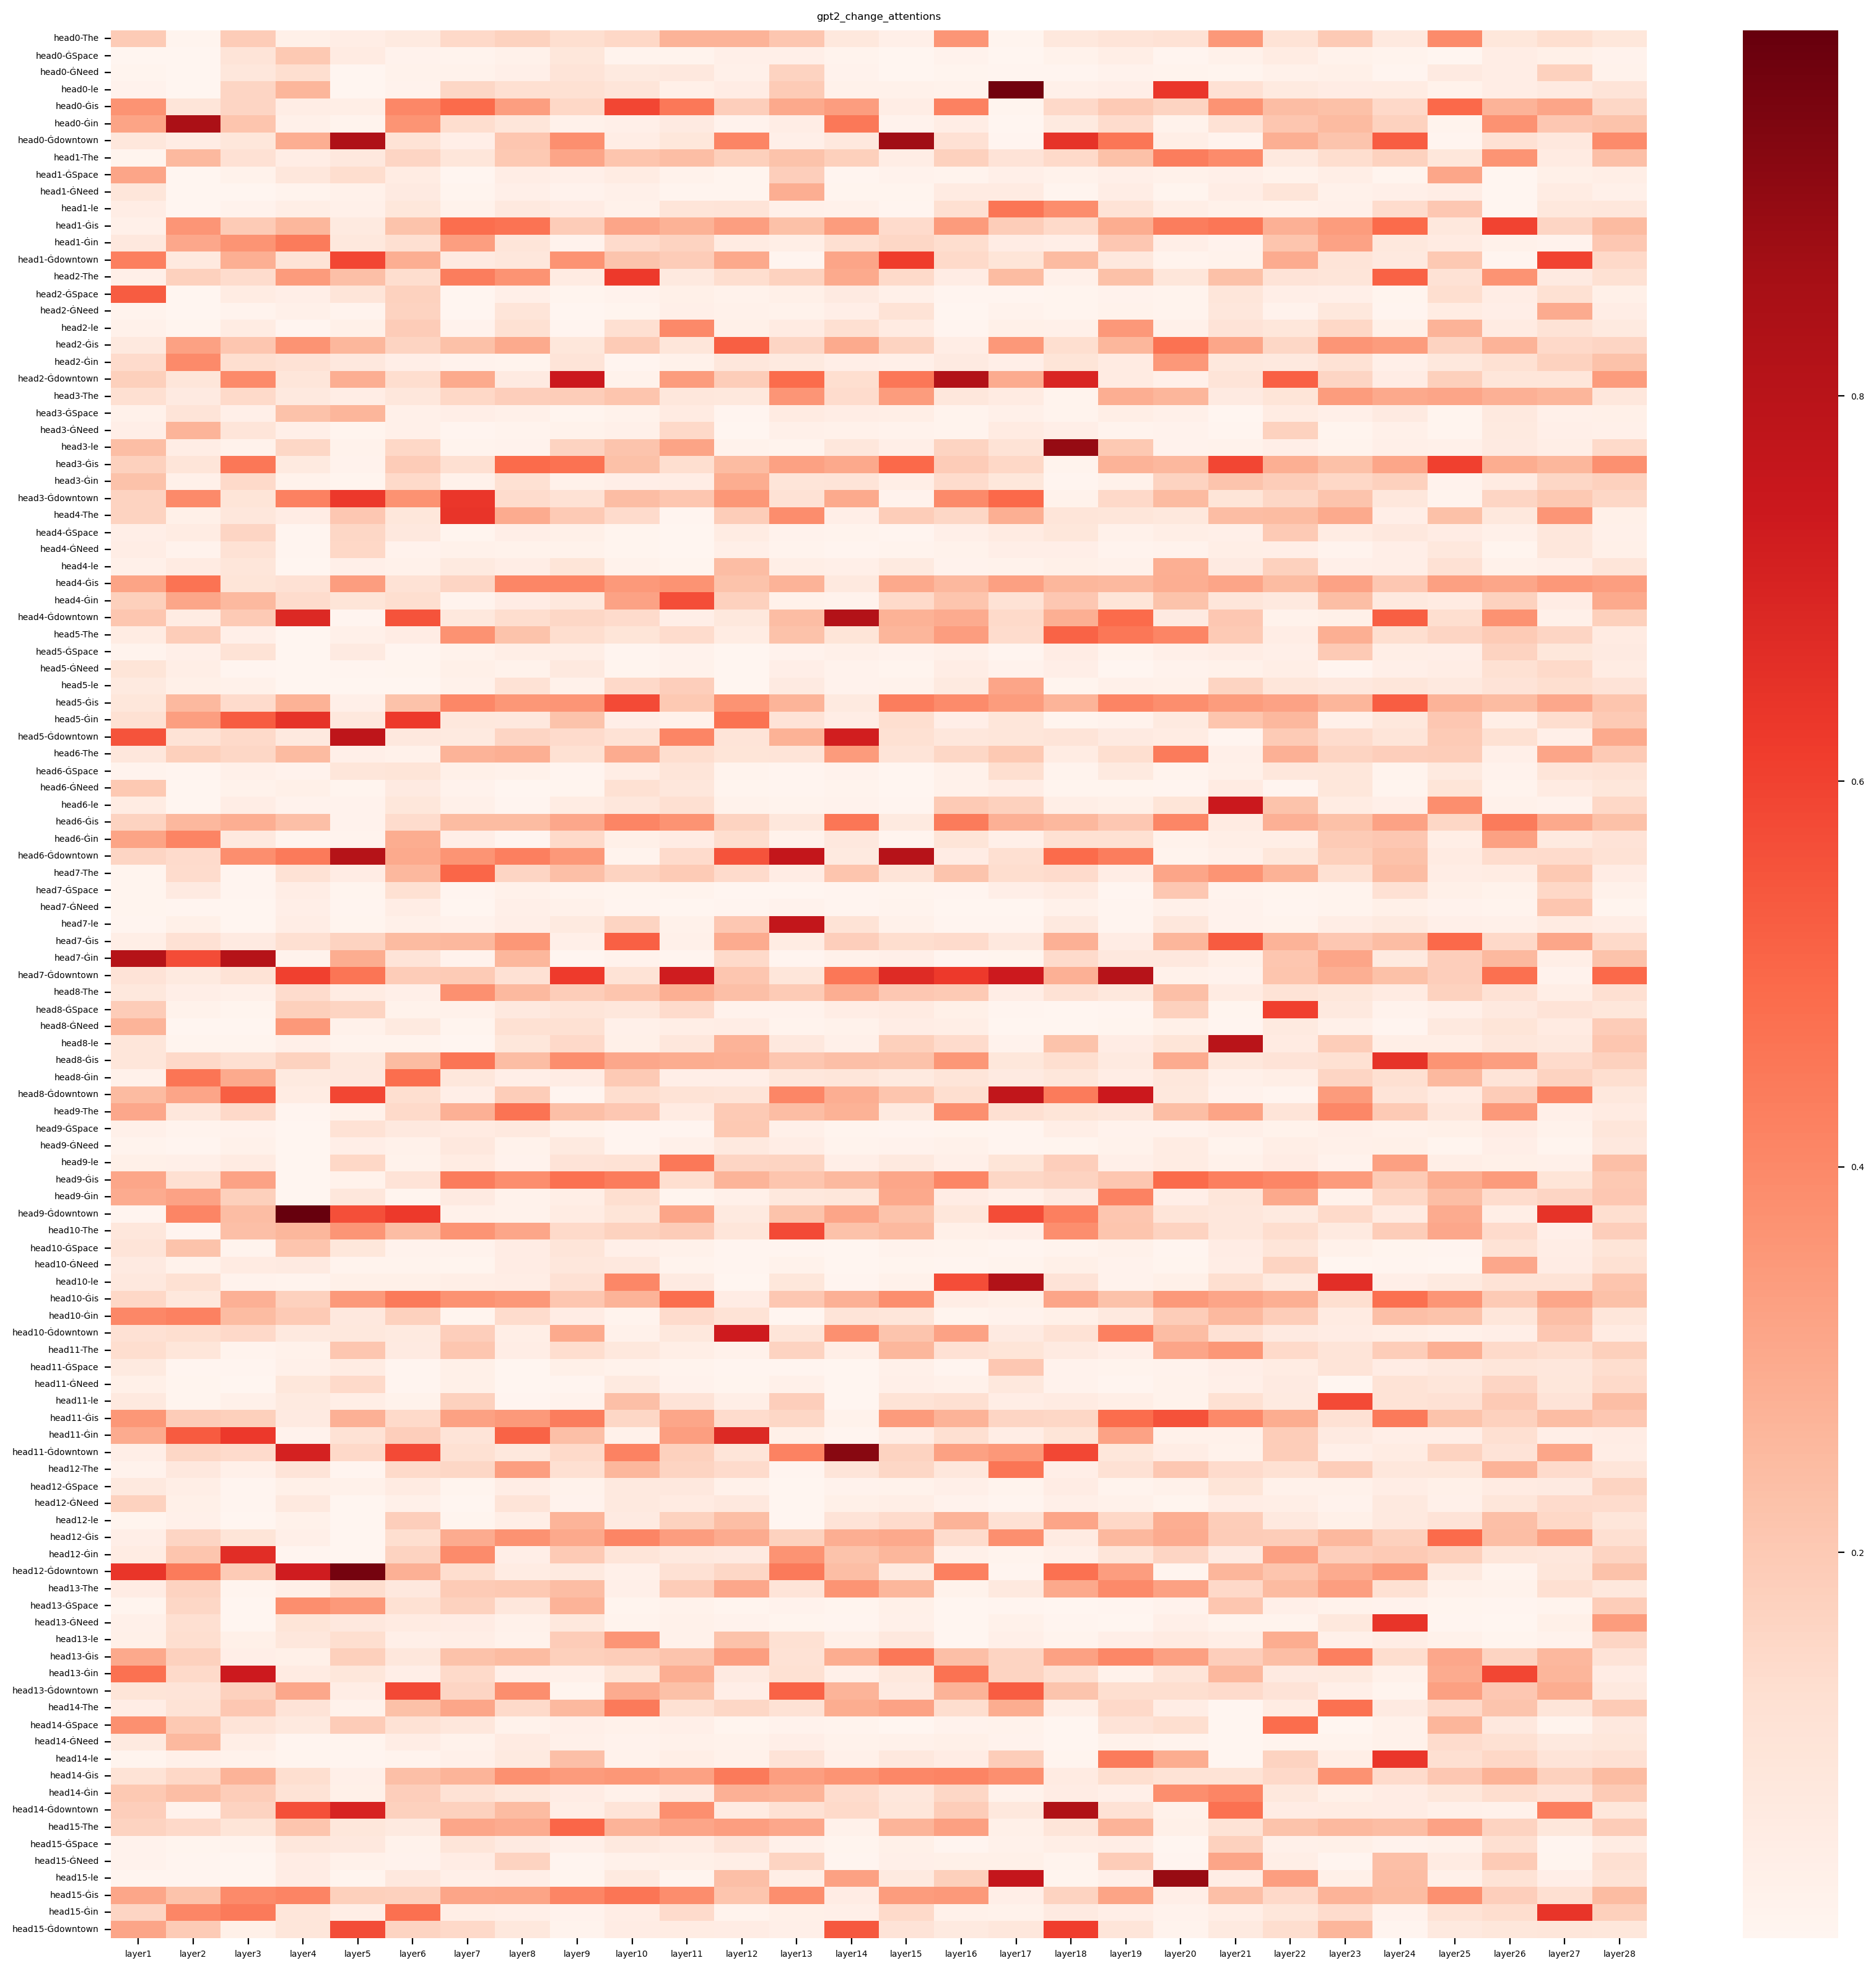

In [34]:
hidden_state,ground_attentions, change_hidden_state,change_attentions, past_key, past_values,past_qs,change_past_key, change_past_values, change_past_qs = try_hook4(model, tokenizer, MODEL_CONFIG, prompt,check_token_id, torch.device(device_str))
ground_attentions, change_attentions = ground_attentions[:, :, check_token_id, :],change_attentions[:, :, check_token_id, :]
plt_heatMap_sns(ground_attentions.reshape(ground_attentions.shape[0], -1).T,
                title="gpt2_attentions", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)
plt_heatMap_sns(change_attentions.reshape(change_attentions.shape[0], -1).T,
                title="gpt2_change_attentions", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)

new_shape = hidden_state.shape[:-1] + (n_heads, -1)

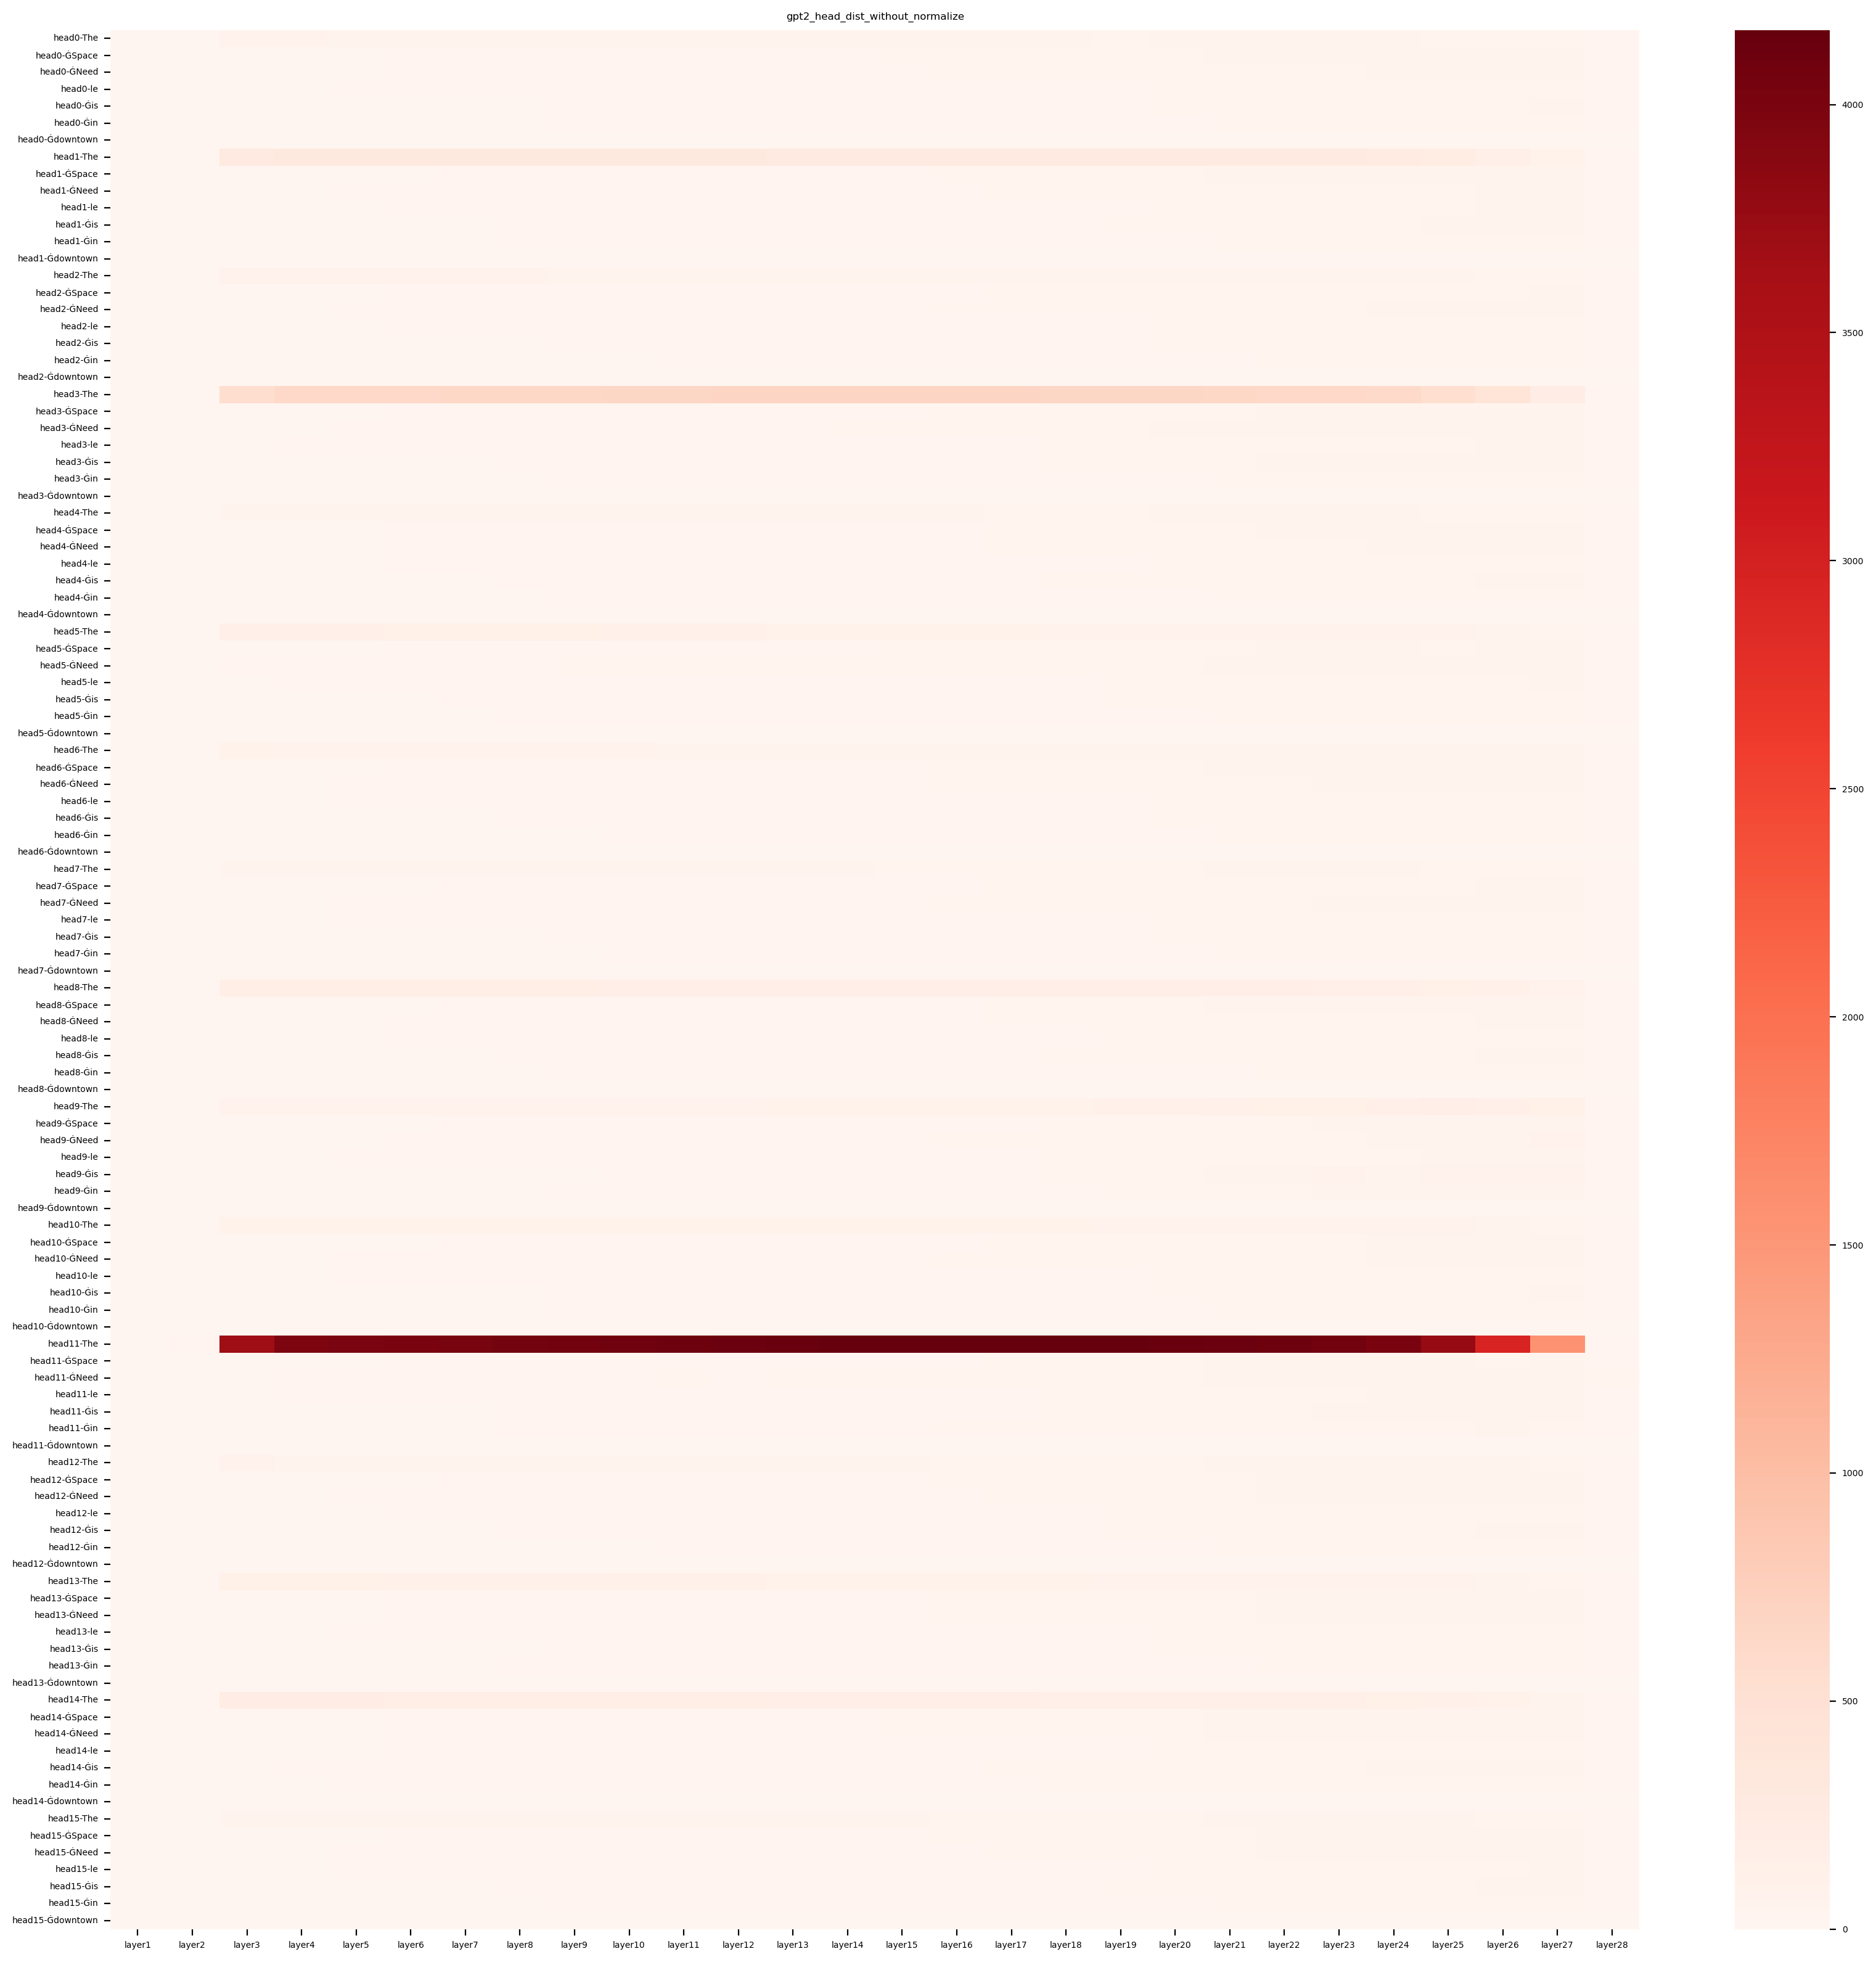

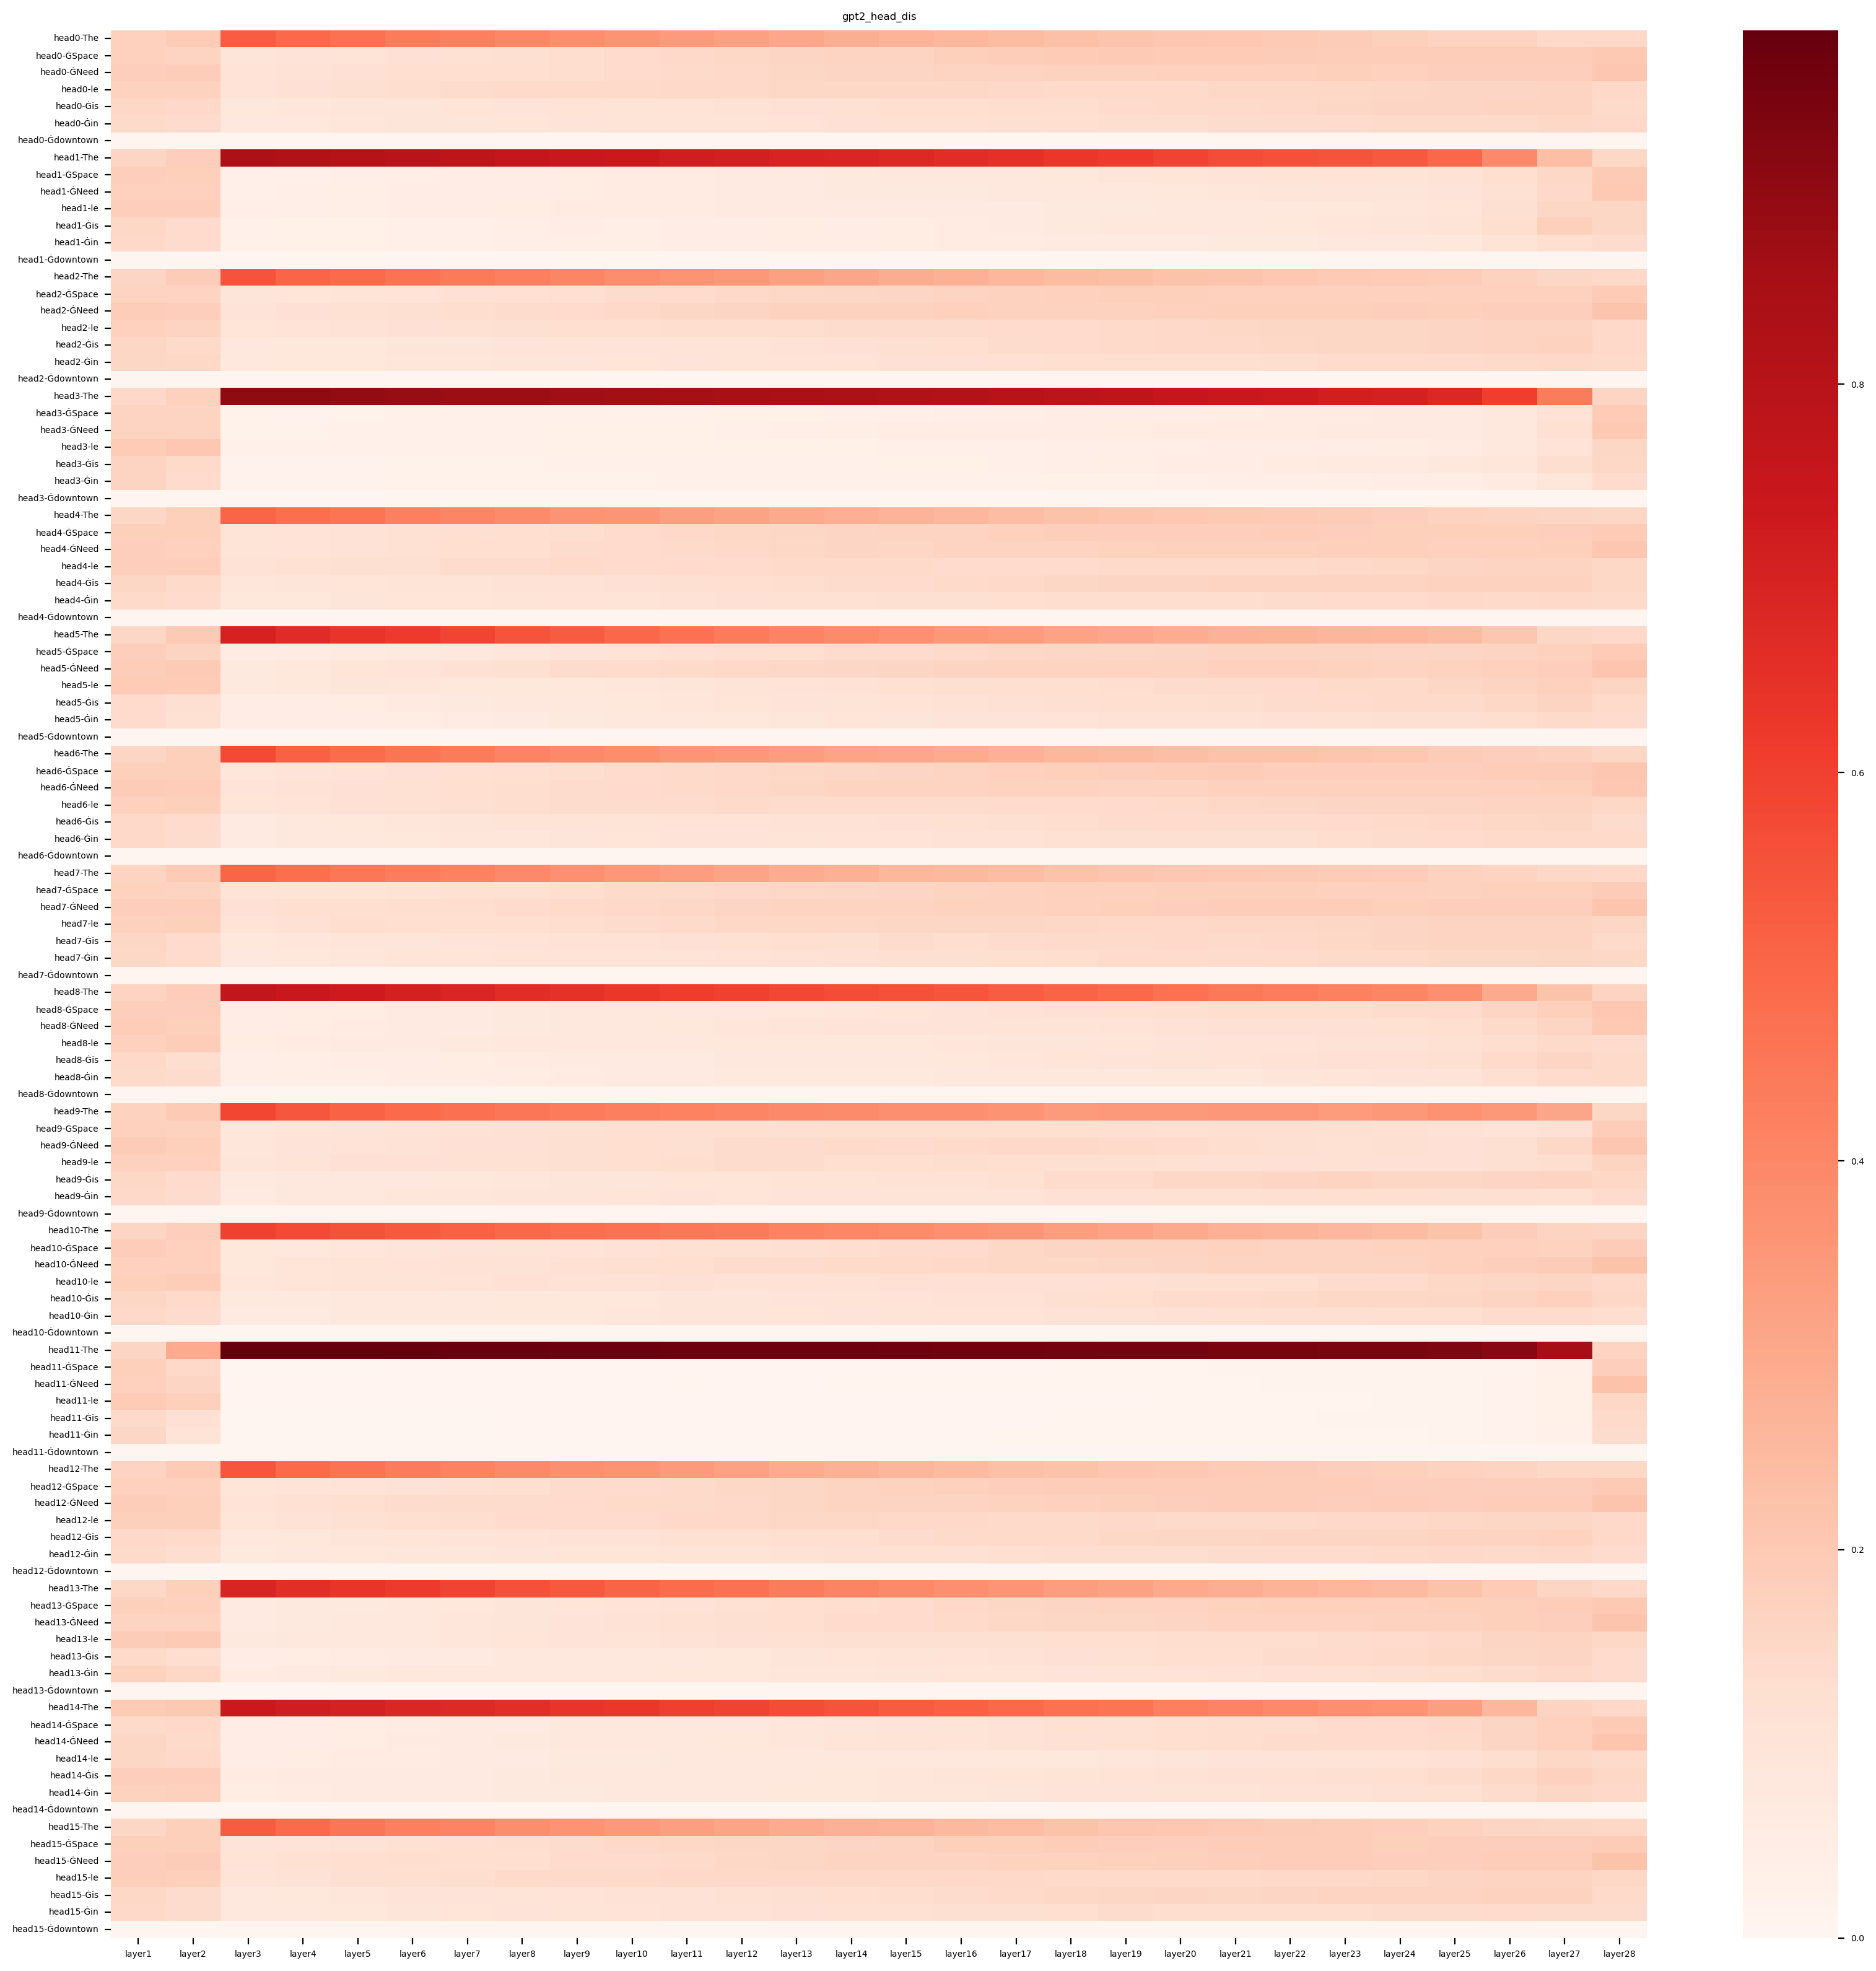

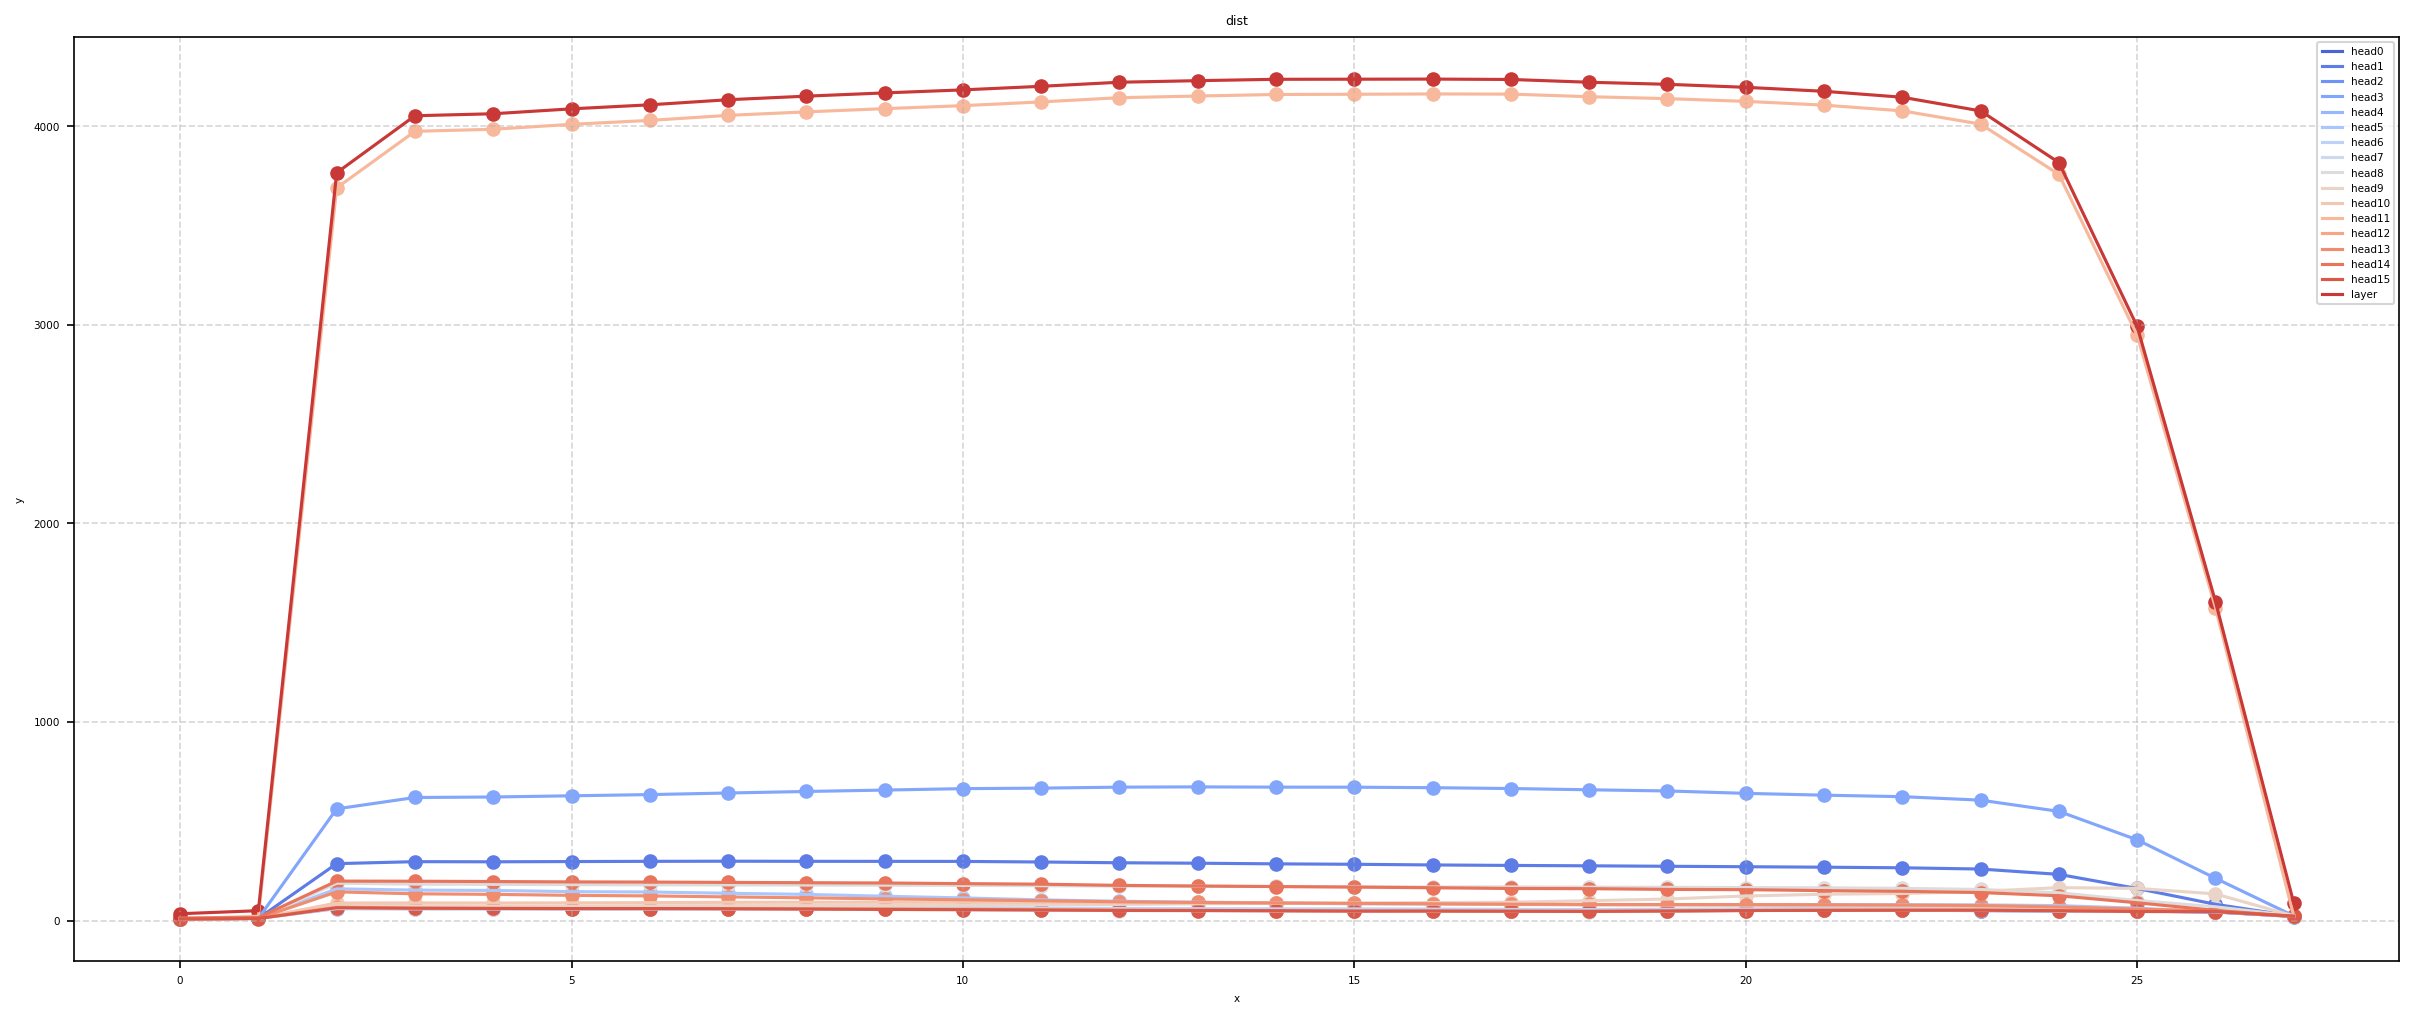

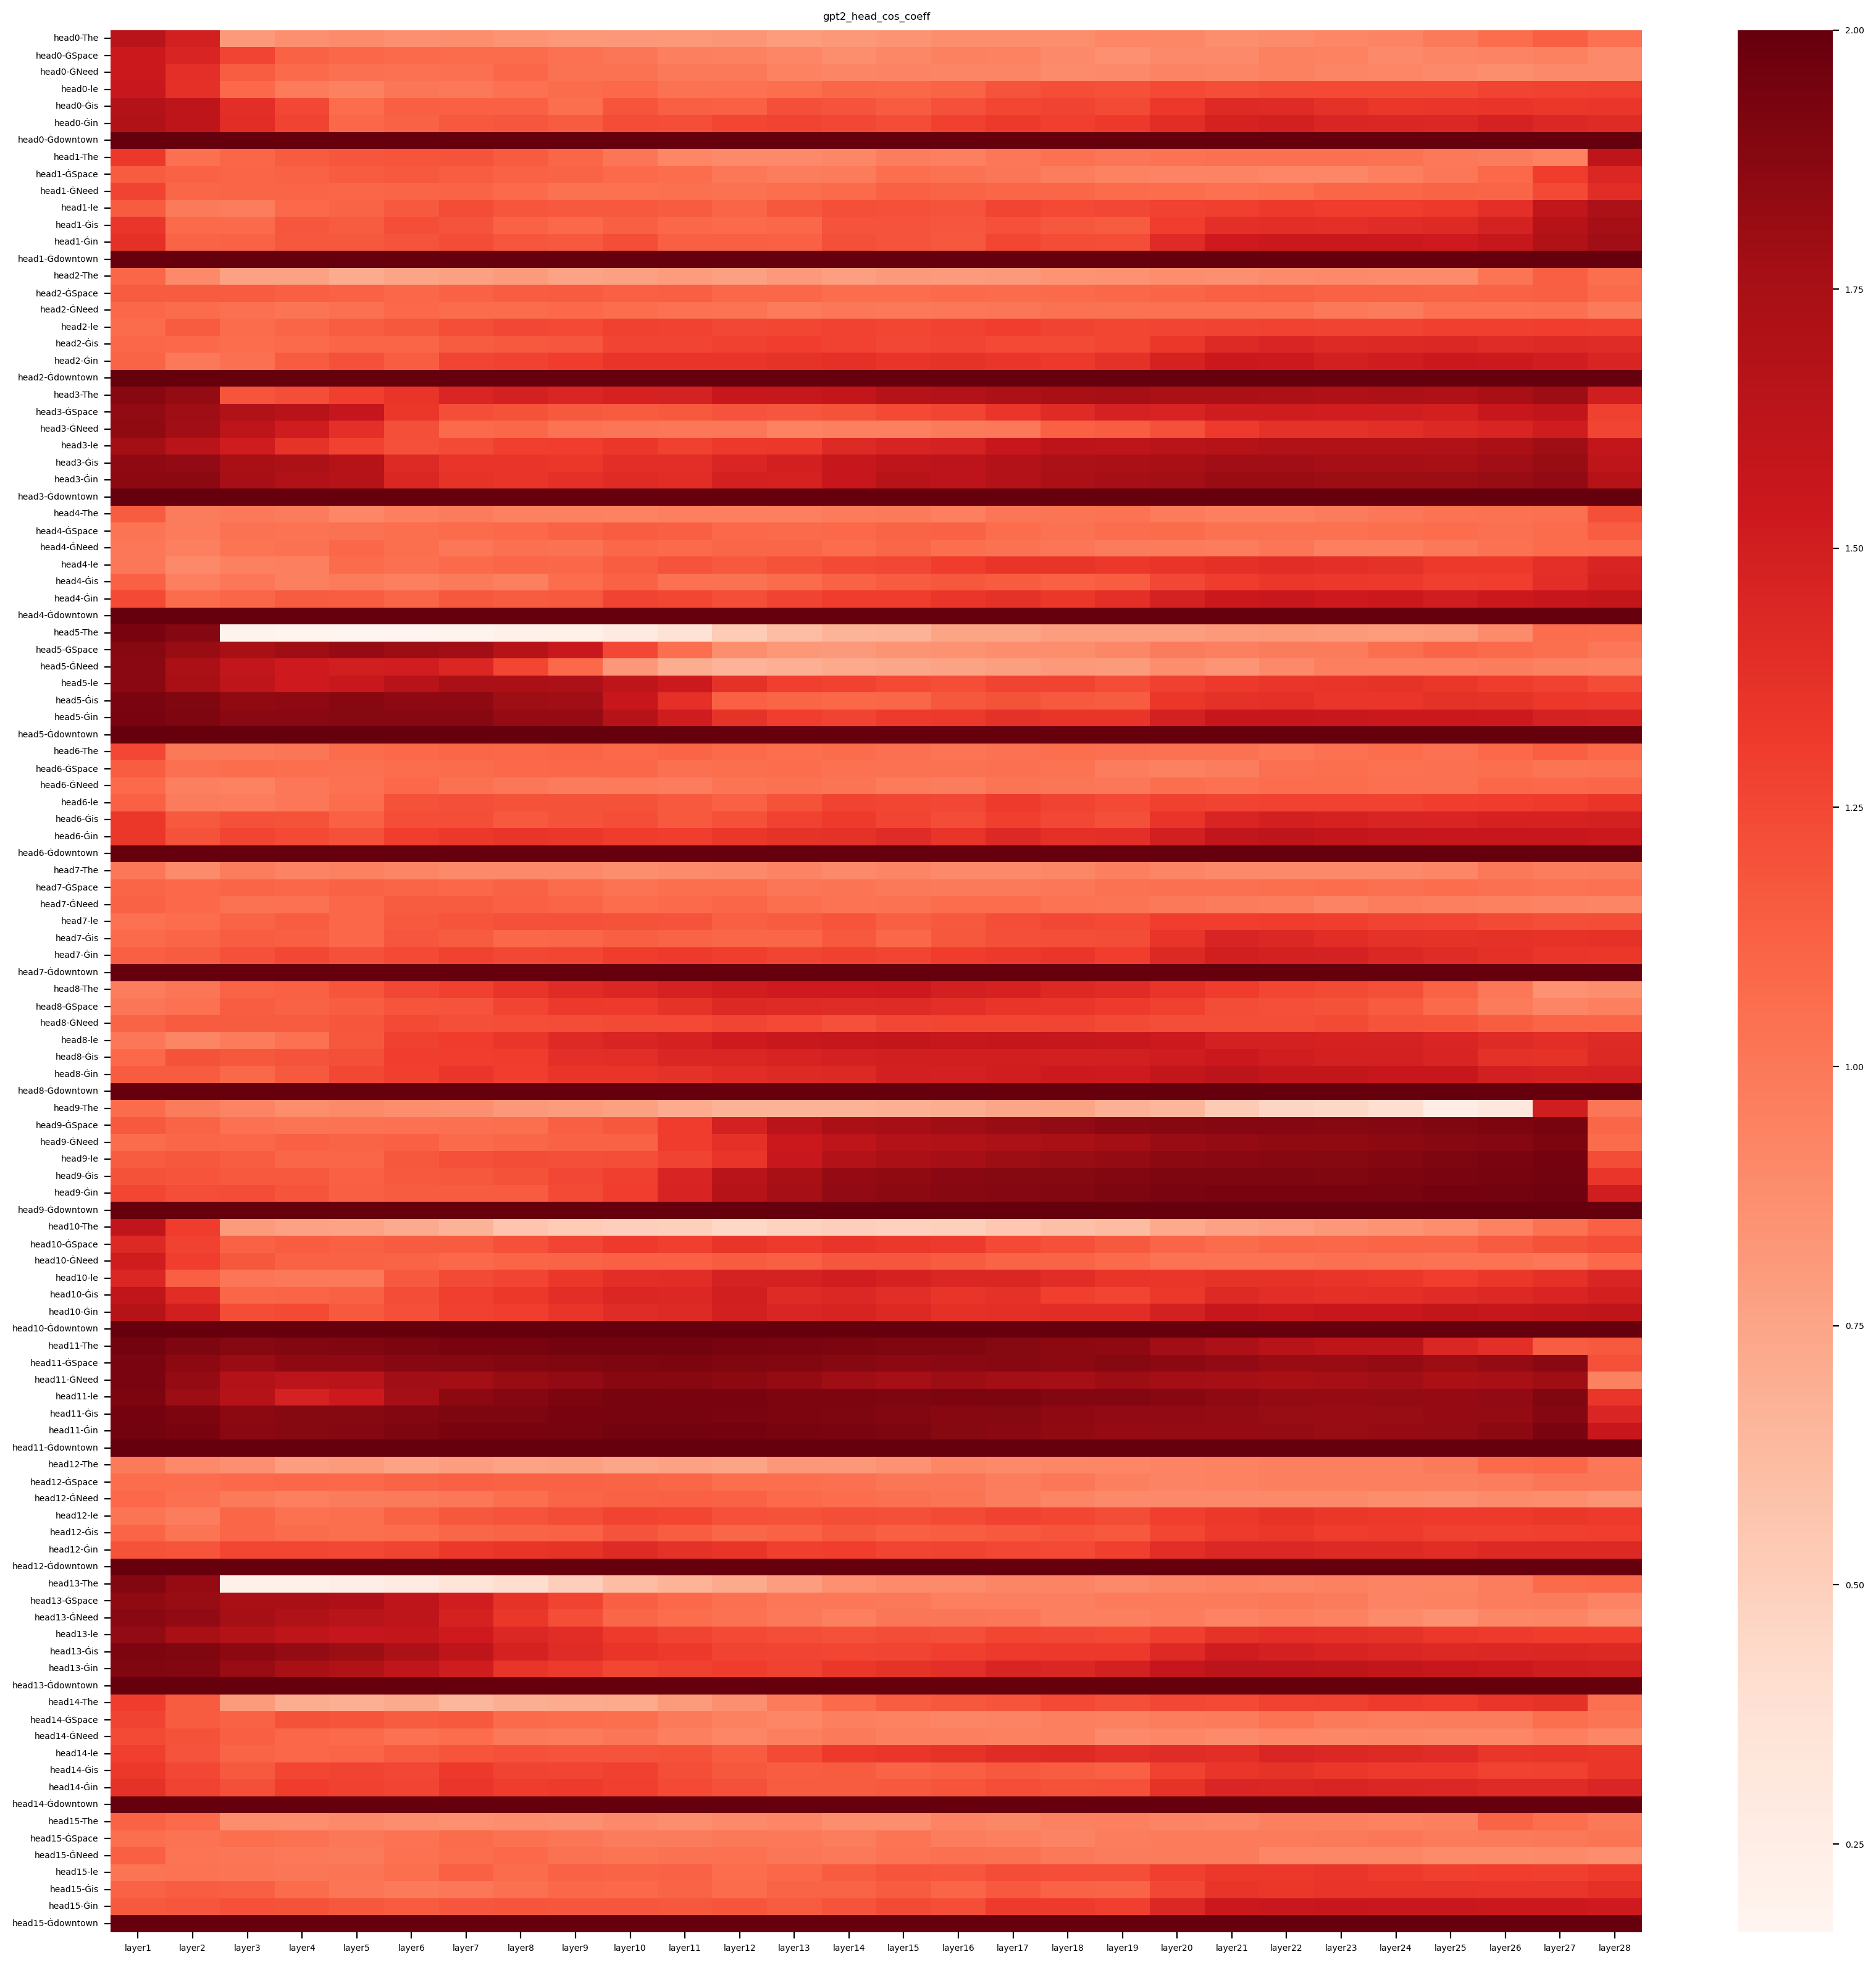

In [35]:
# hidden state的热力图，折线图，数据值
head_states = np.transpose(np.reshape(hidden_state,newshape=new_shape),(0,2,1,3))[1:]
dist = np.linalg.norm(head_states - head_states[:,:,-1][:,:,np.newaxis,:], axis=3)
plt_heatMap_sns(dist.reshape(dist.shape[0], -1).T,
                title="gpt2_head_dist_without_normalize", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)
dist_normalize = dist/np.sum(dist, axis=2)[:,:,np.newaxis]
# dist[:, :, (0,)] = 0
# new_shape = hidden_state.size()[:-1] + (num_heads, attn_head_size)
# tensor = tensor.view(new_shape)
plt_heatMap_sns(dist_normalize.reshape(dist_normalize.shape[0], -1).T,
                title="gpt2_head_dis", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)
dist2 = np.linalg.norm(hidden_state - hidden_state[:,-1][:, np.newaxis,:], axis=2)[1:,np.newaxis,]
new_dist = np.concatenate((dist,dist2), axis=1)[:,:,0]
plot_dist(new_dist,save_path=save_path, title='dist',
          datalabel=[f"head{i_head}" for i_head in range(n_heads)] + ['layer'],
          show=True)

cos_coeff = np.zeros(head_states.shape[:-1])
from sklearn.metrics.pairwise import cosine_similarity
for layer_id_ in range(head_states.shape[0]):
    for head_id in range(head_states.shape[1]):
        other,last = head_states[layer_id_, head_id], head_states[layer_id_, head_id, -1][np.newaxis, :]
        s = cosine_similarity(other, last).reshape(-1)
        cos_coeff[layer_id_,head_id,-1] = 0
        cos_coeff[layer_id_, head_id] = s + 1
plt_heatMap_sns(cos_coeff.reshape(cos_coeff.shape[0], -1).T,
                title="gpt2_head_cos_coeff", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)

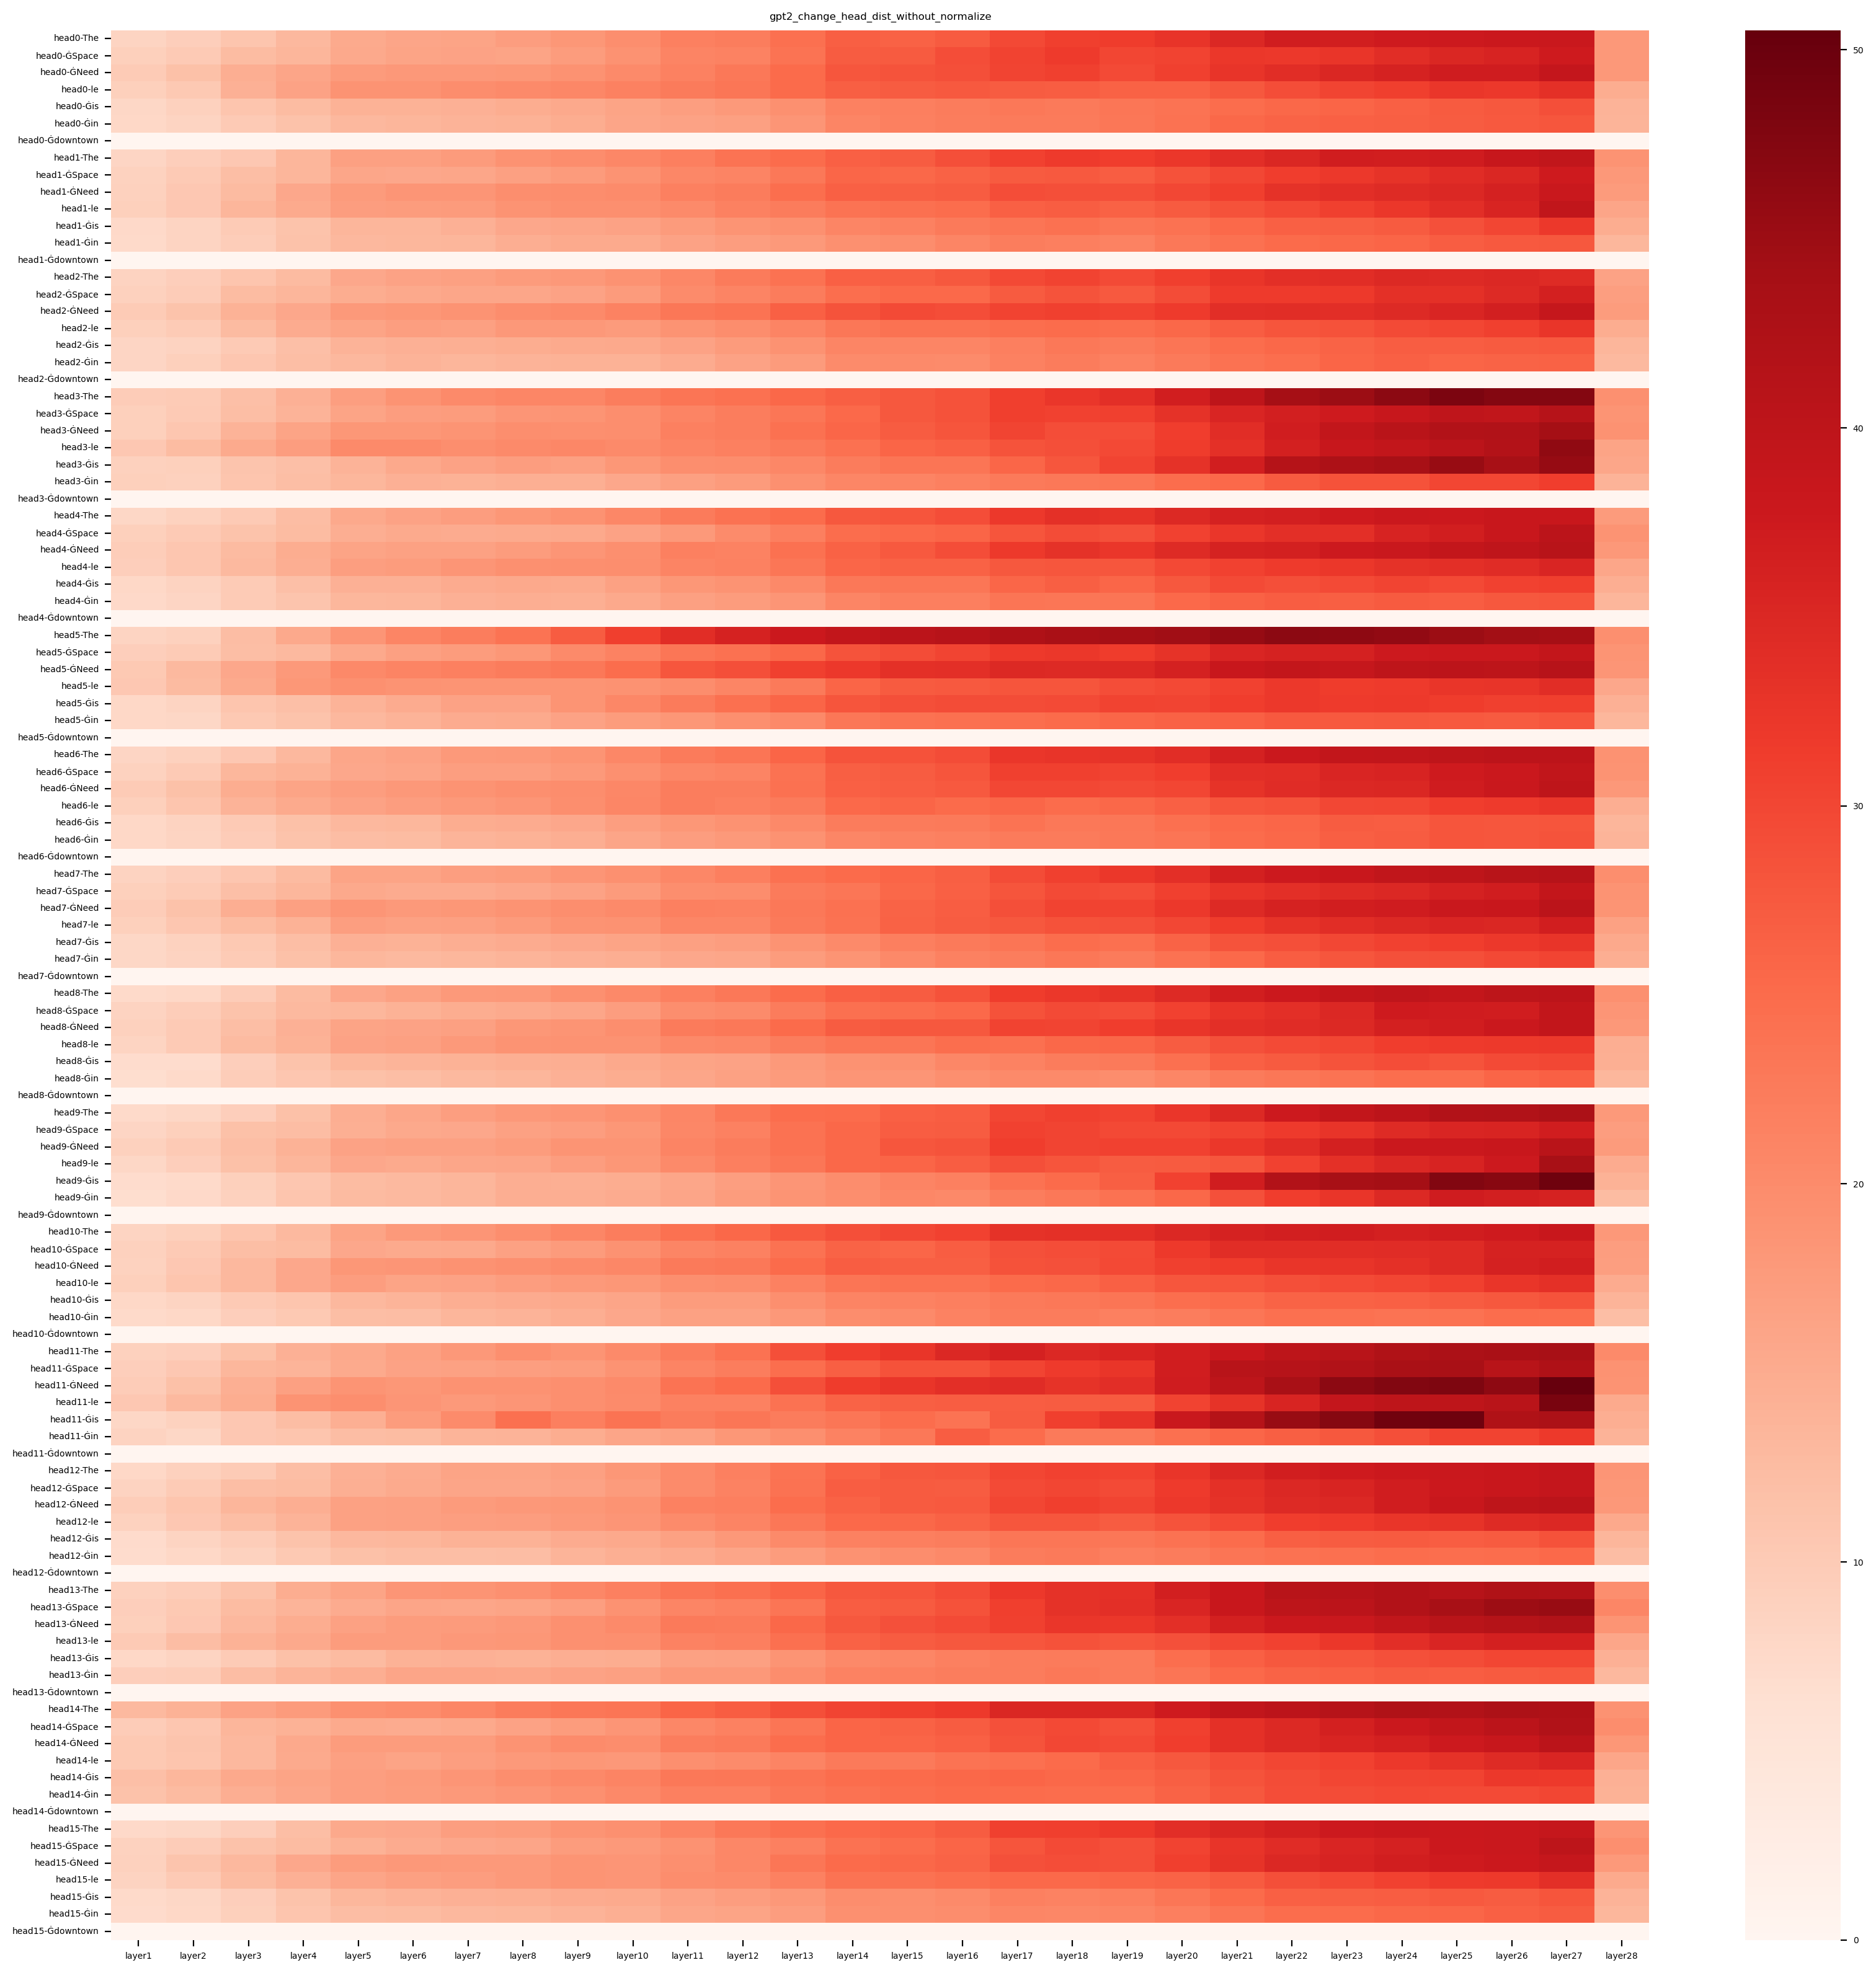

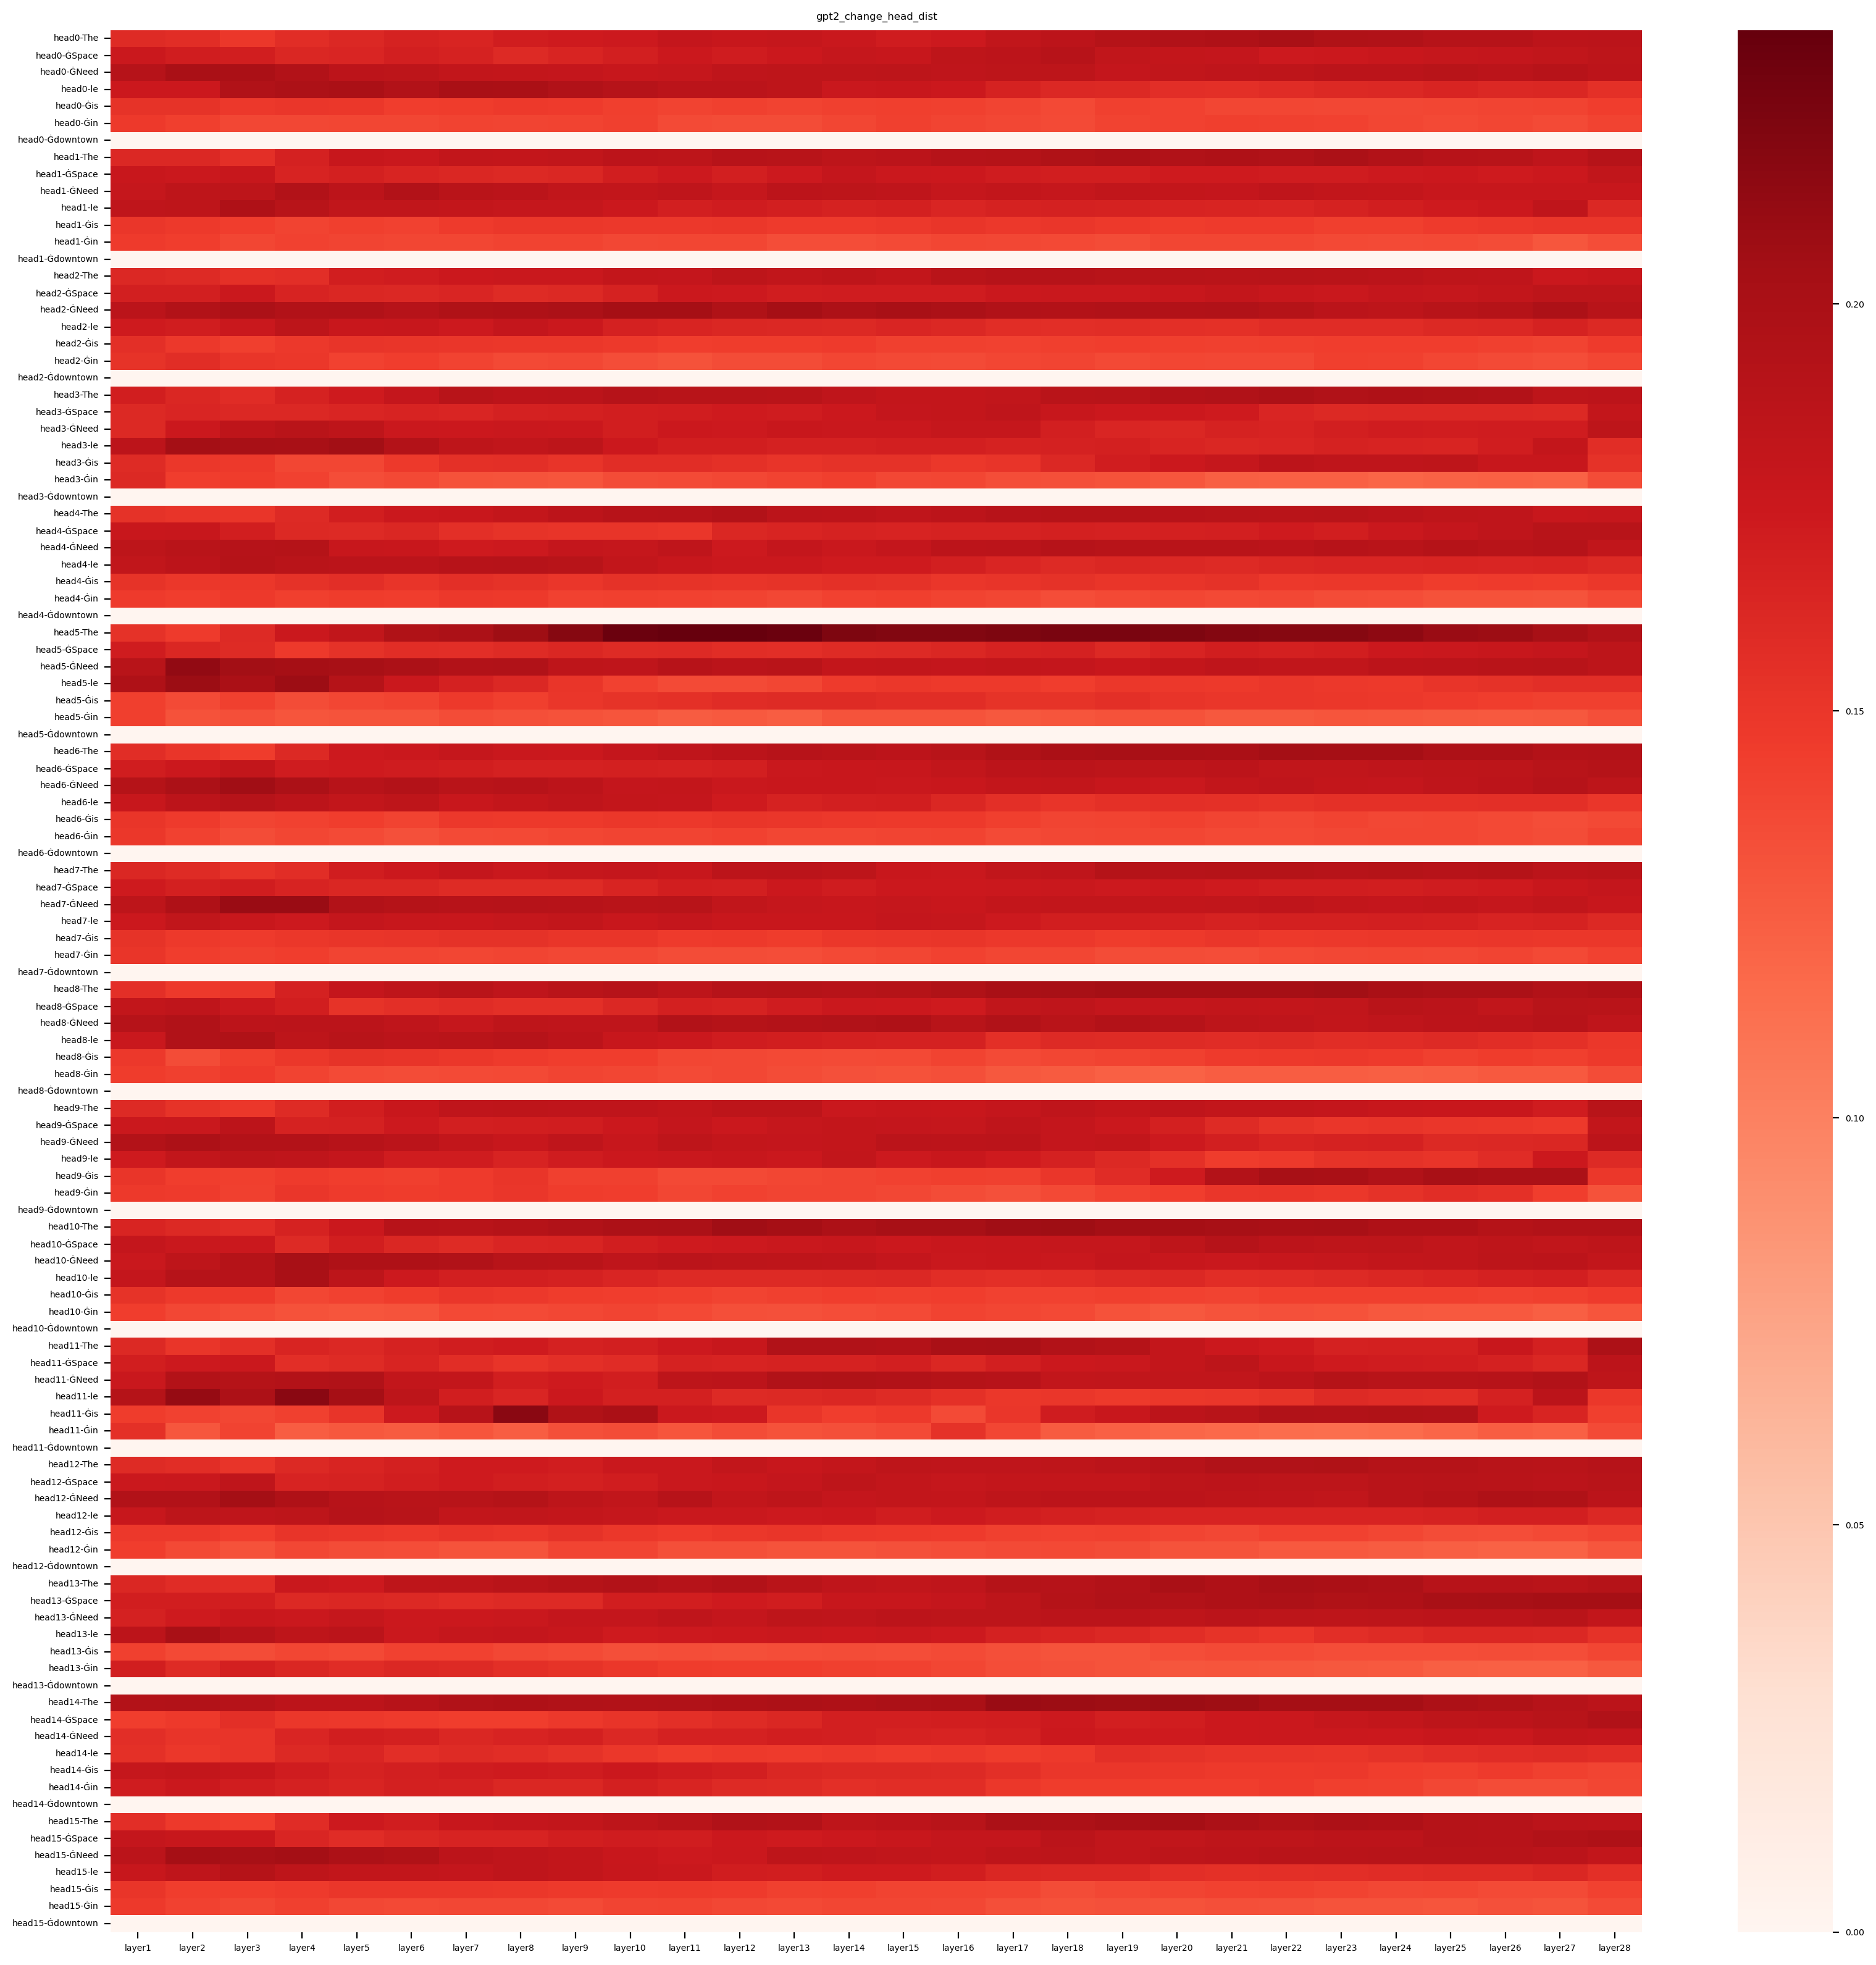

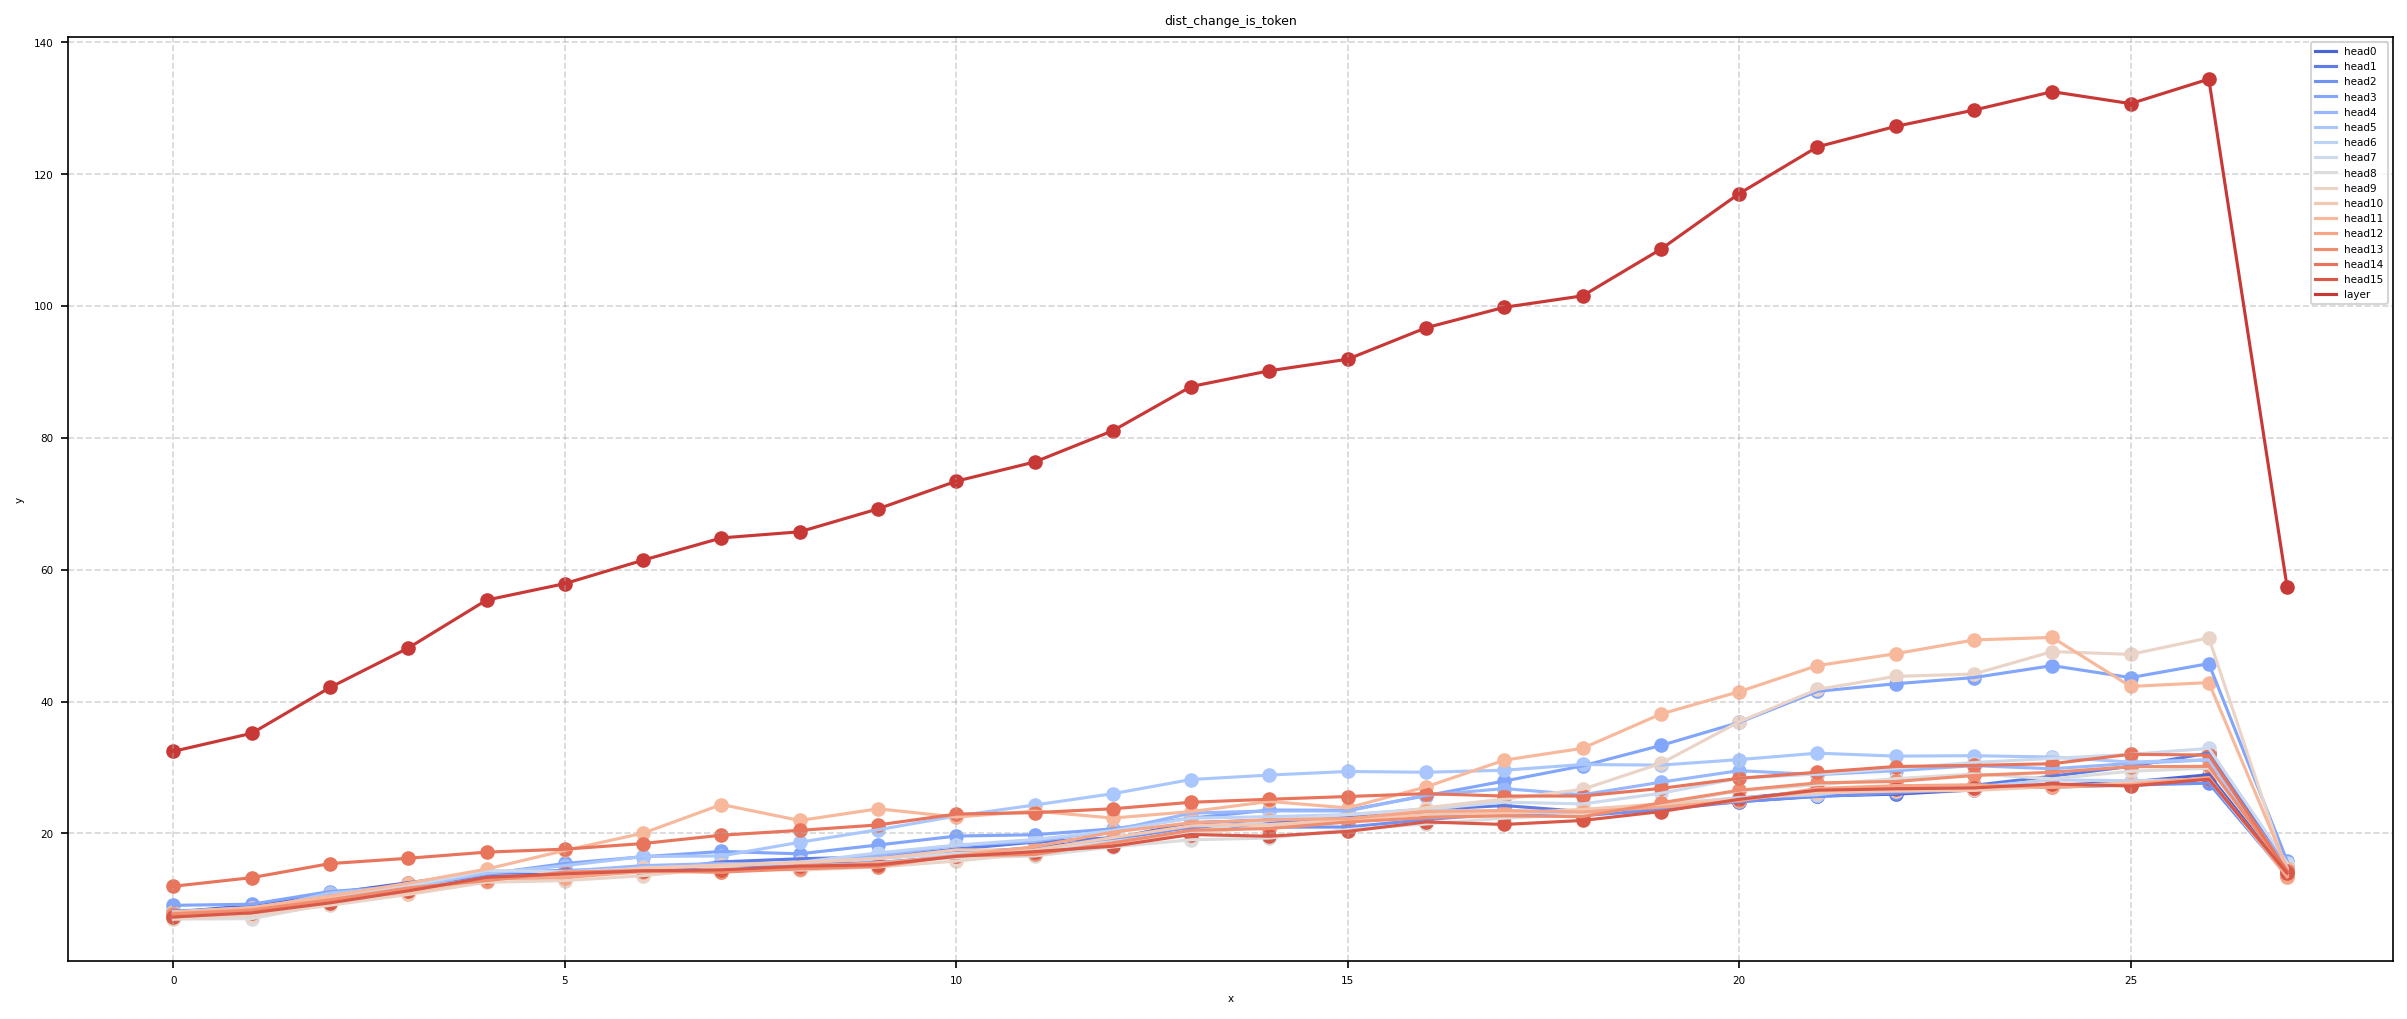

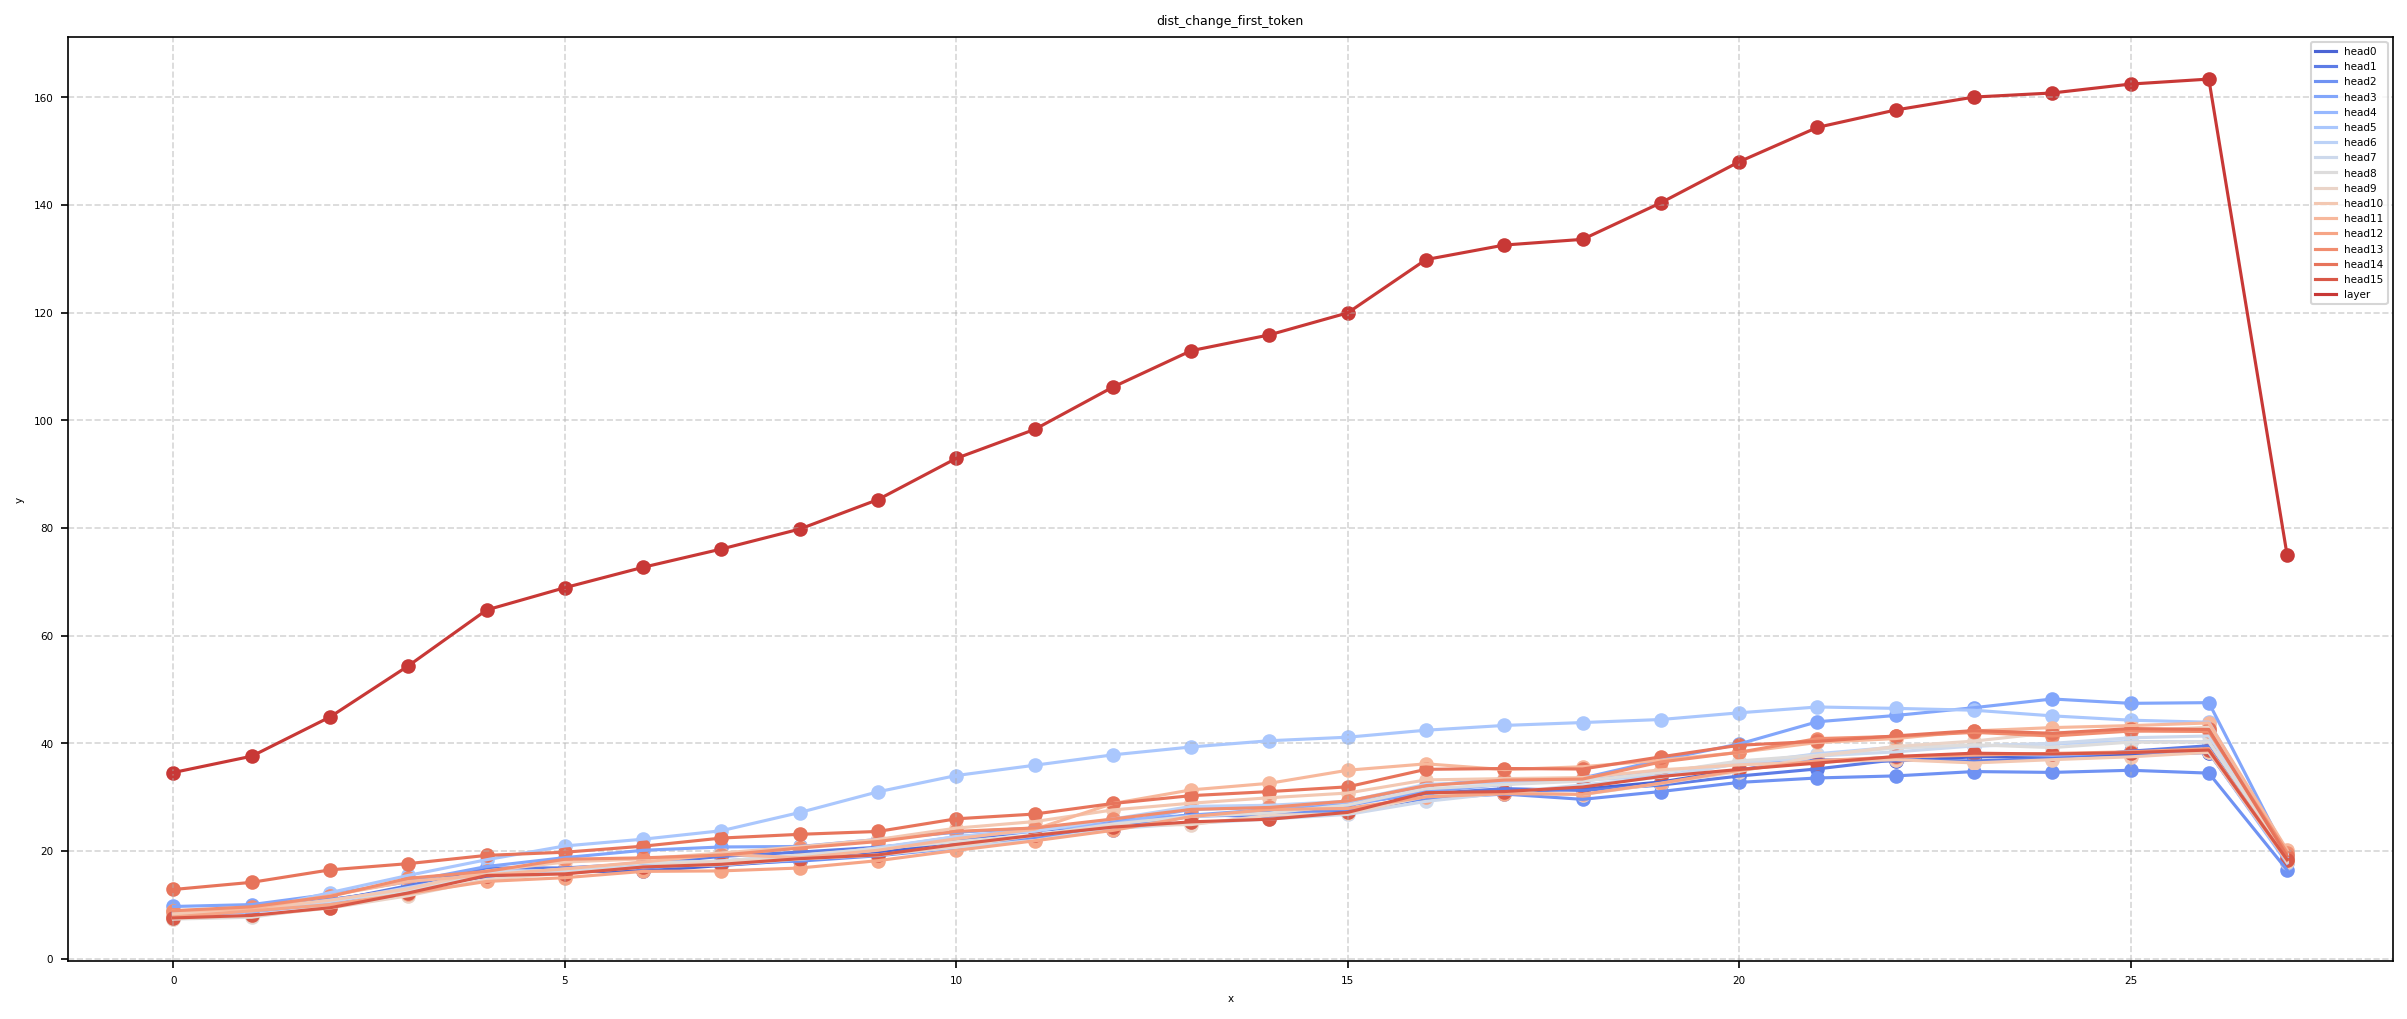

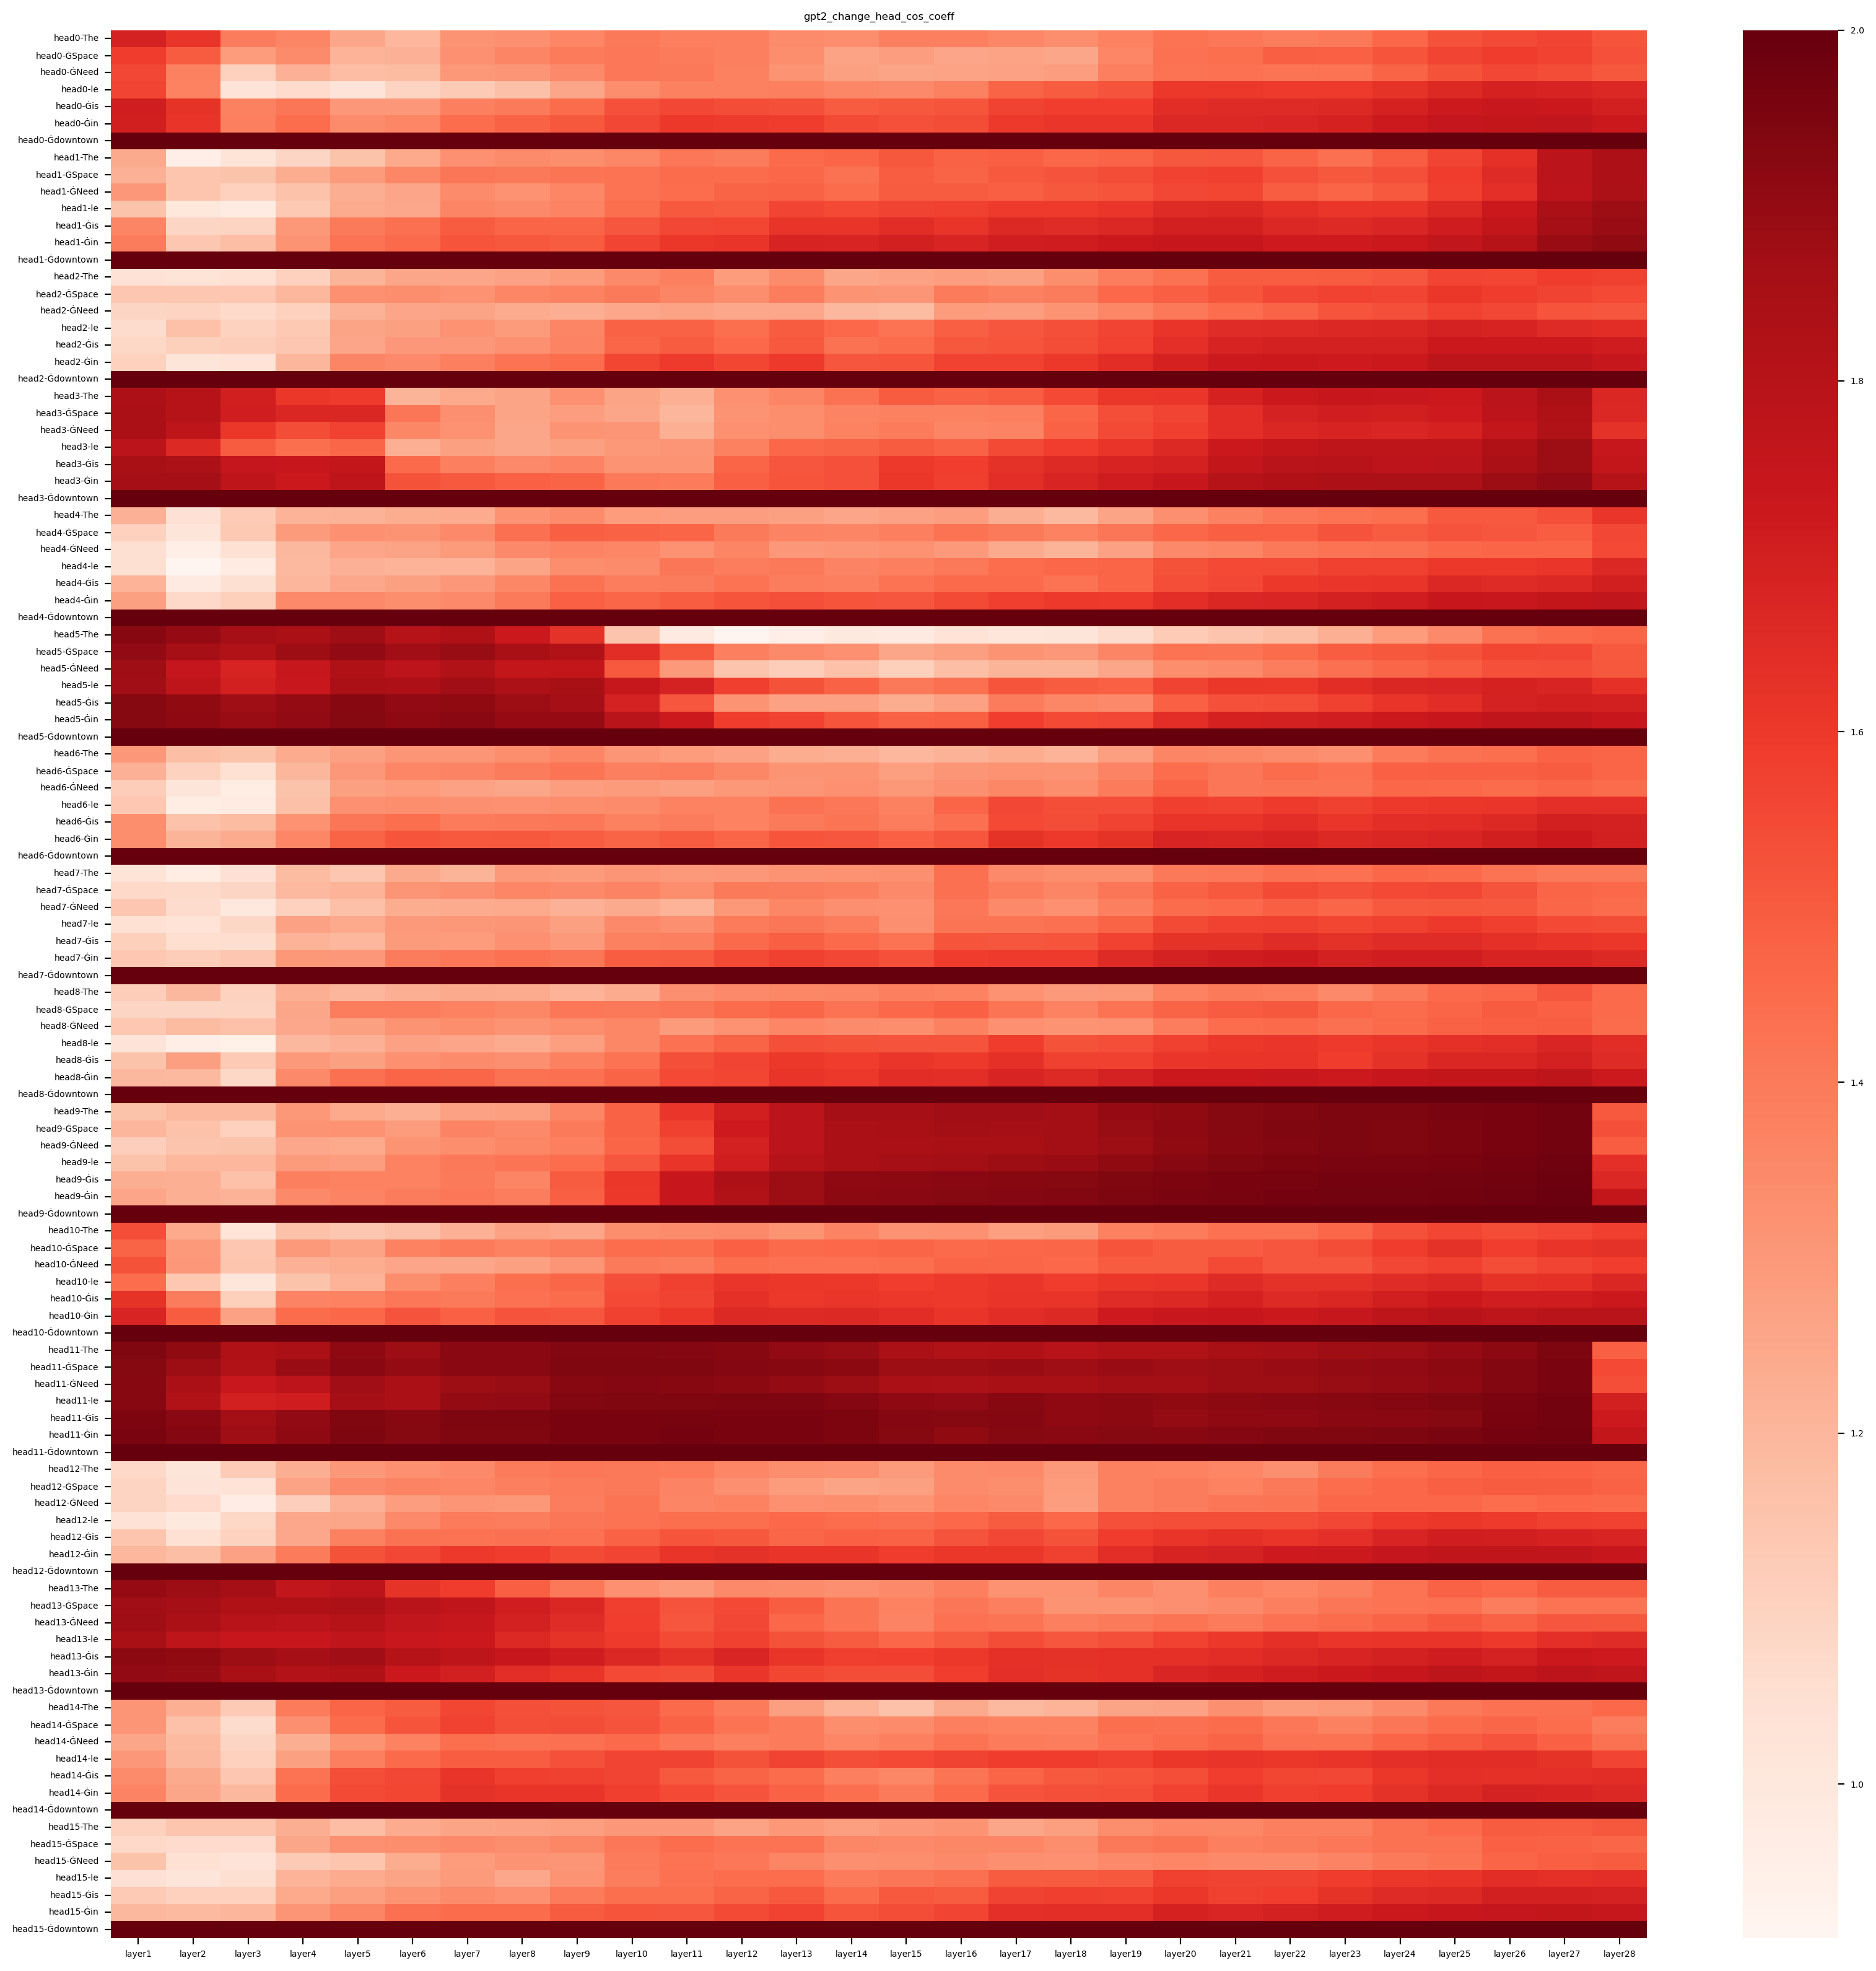

In [36]:
change_head_states = np.transpose(np.reshape(change_hidden_state,newshape=new_shape),(0,2,1,3))[1:]
 # hidden state的热力图，折线图，数据值
change_dist = np.linalg.norm(change_head_states - change_head_states[:,:,-1][:,:,np.newaxis,:], axis=3)
plt_heatMap_sns(change_dist.reshape(change_dist.shape[0], -1).T,
                title="gpt2_change_head_dist_without_normalize", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)
dist_normalize = change_dist/np.sum(change_dist, axis=2)[:,:,np.newaxis]
# dist[:, :, (0,)] = 0
# new_shape = hidden_state.size()[:-1] + (num_heads, attn_head_size)
# tensor = tensor.view(new_shape)
plt_heatMap_sns(dist_normalize.reshape(dist_normalize.shape[0], -1).T,
                title="gpt2_change_head_dist", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)
change_dist2 = np.linalg.norm(change_hidden_state - change_hidden_state[:,-1][:, np.newaxis,:], axis=2)[1:,np.newaxis,]
new_dist = np.concatenate((change_dist,change_dist2), axis=1)[:,:,4]
plot_dist(new_dist,save_path=save_path, title='dist_change_is_token',
          datalabel=[f"head{i_head}" for i_head in range(n_heads)] + ['layer'],
          show=True)
new_dist = np.concatenate((change_dist,change_dist2), axis=1)[:,:,0]
plot_dist(new_dist,save_path=save_path, title='dist_change_first_token',
          datalabel=[f"head{i_head}" for i_head in range(n_heads)] + ['layer'],
          show=True)

cos_coeff = np.zeros(head_states.shape[:-1])
from sklearn.metrics.pairwise import cosine_similarity
for layer_id_ in range(change_head_states.shape[0]):
    for head_id in range(change_head_states.shape[1]):
        other,last = change_head_states[layer_id_, head_id], change_head_states[layer_id_, head_id, -1][np.newaxis, :]
        s = cosine_similarity(other, last).reshape(-1)
        cos_coeff[layer_id_,head_id,-1] = 0
        cos_coeff[layer_id_, head_id] = s + 1
plt_heatMap_sns(cos_coeff.reshape(cos_coeff.shape[0], -1).T,
                title="gpt2_change_head_cos_coeff", x_ticks=x_ticks, y_ticks=y_ticks
                , show=True, save_path=save_path)

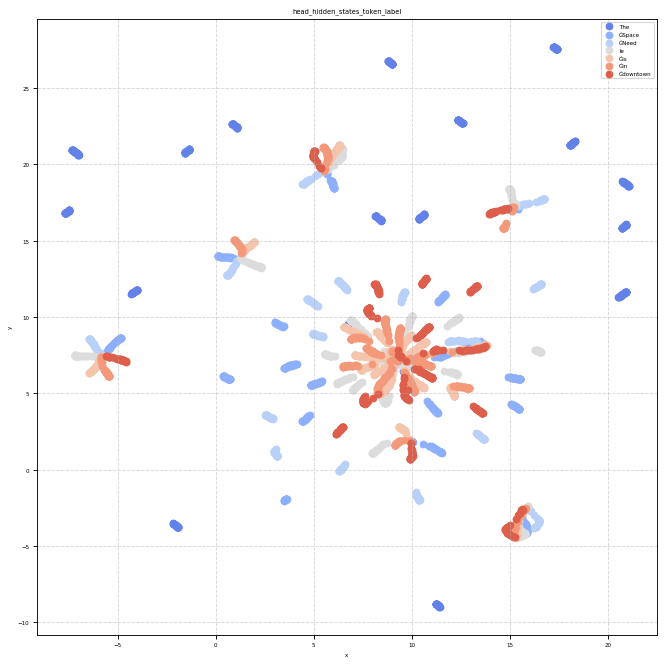

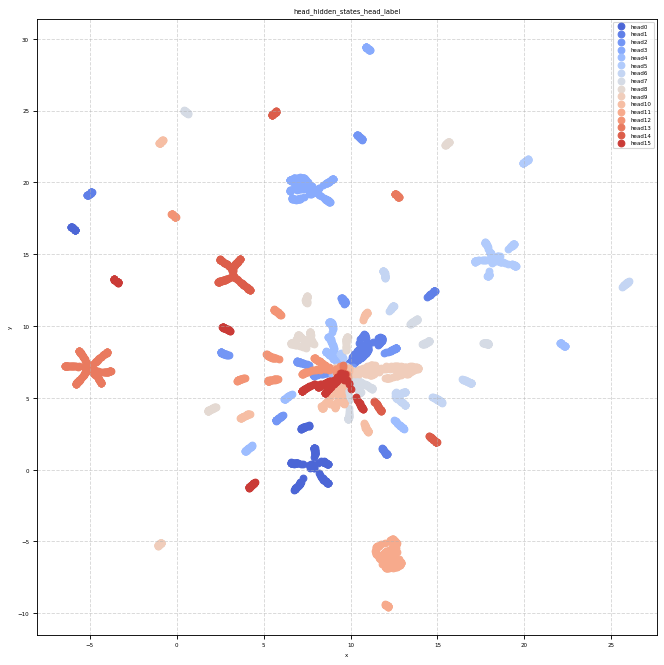

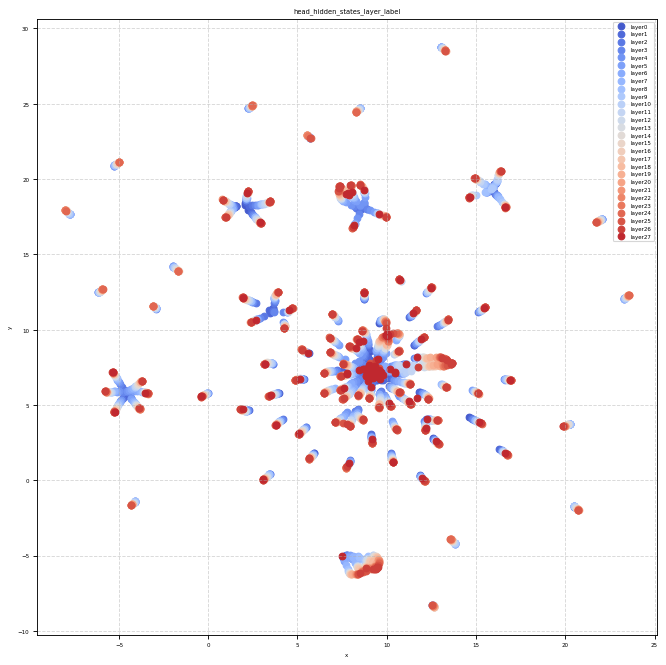

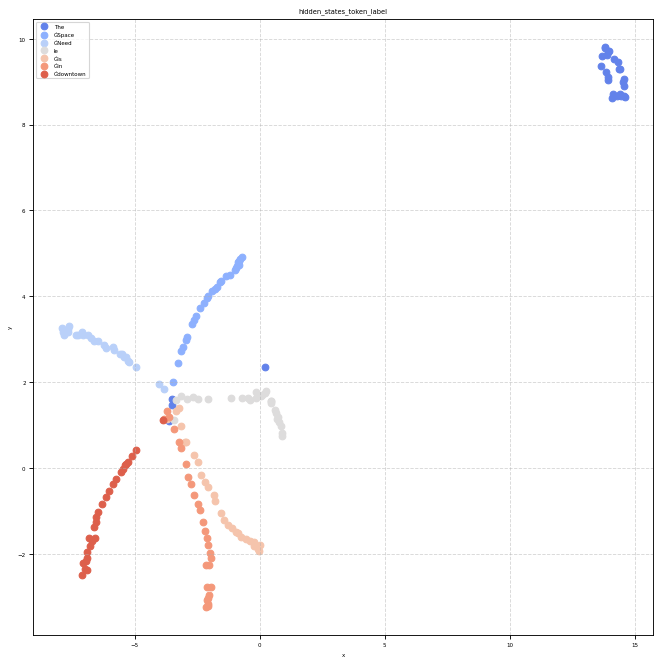

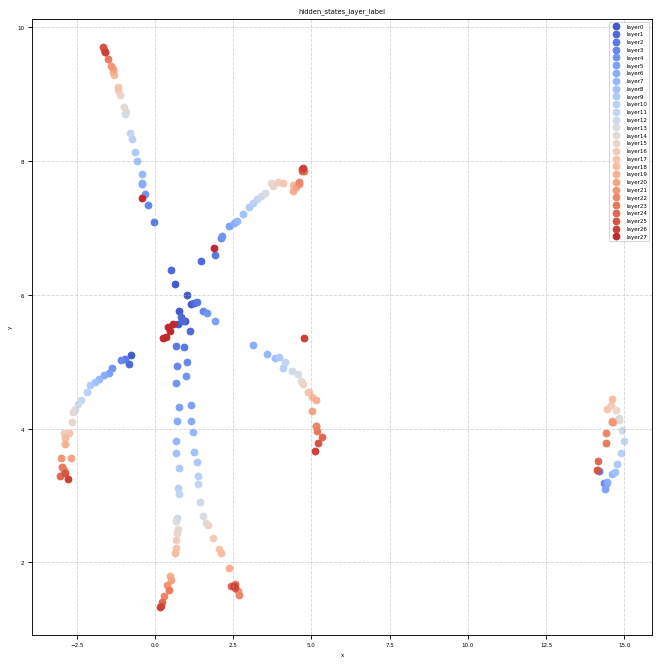

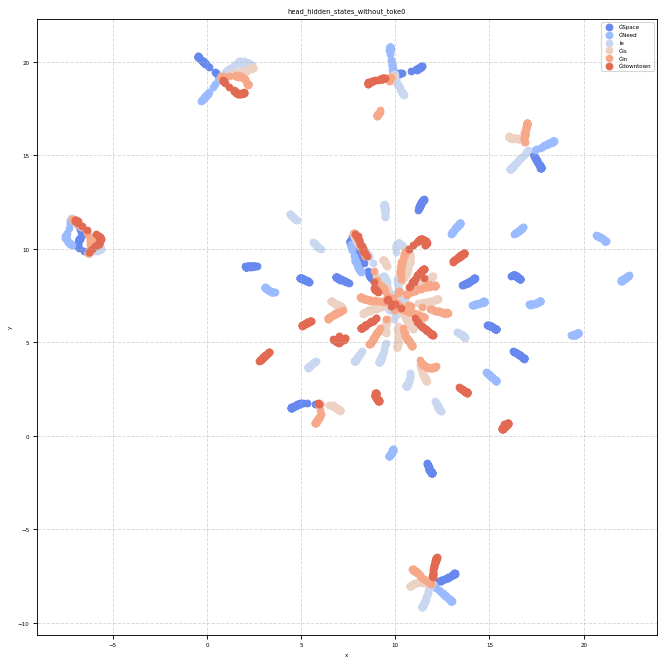

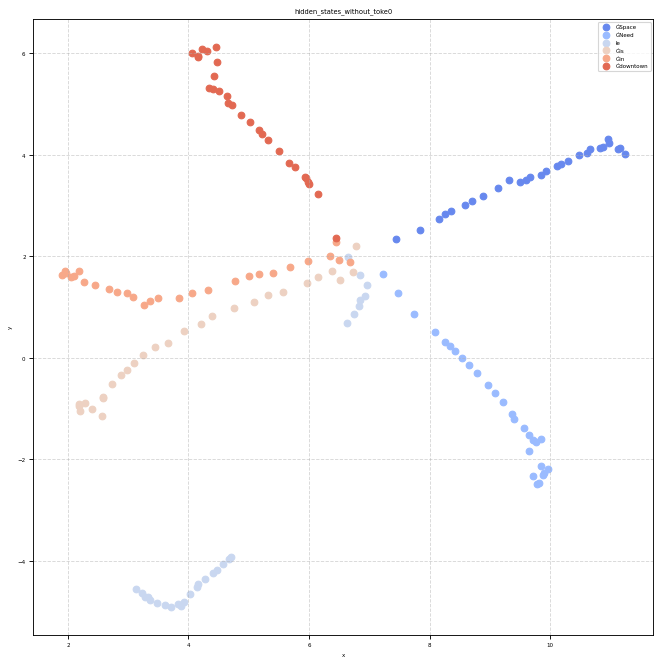

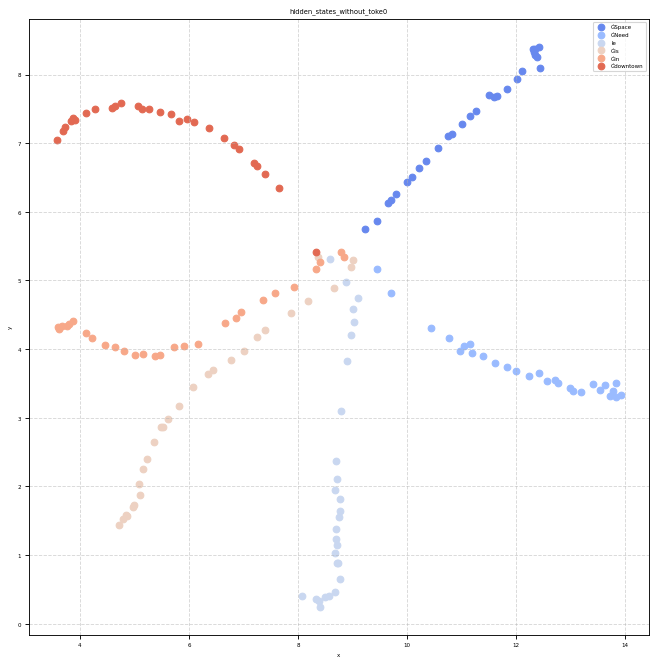

In [37]:

# hidden state降为可视化
head_label =  [f'head{i}' for i in range(n_heads)]
layer_label =  [f'layer{i}' for i in range(n_layers)]
plot_umap(head_states, codes,title="head_hidden_states_token_label",save_path=save_path)
plot_umap(np.transpose(head_states,(0,2,1,3)),head_label,title="head_hidden_states_head_label",save_path=save_path)
plot_umap(np.transpose(head_states,(2,1,0,3)),layer_label,title="head_hidden_states_layer_label",save_path=save_path)
plot_umap(hidden_state[1:,np.newaxis,:,:], 
          codes,title="hidden_states_token_label",save_path=save_path)
plot_umap(np.transpose(hidden_state[1:,np.newaxis,:,:],(2,1,0,3)), 
          layer_label,title="hidden_states_layer_label",save_path=save_path)

plot_umap(head_states[:,:,1:,:], codes[1:],title="head_hidden_states_without_toke0",save_path=save_path)
plot_umap(hidden_state[1:,np.newaxis,1:,:], 
          codes[1:],title="hidden_states_without_toke0",save_path=save_path)

plot_umap(hidden_state[1:,np.newaxis,1:,:], 
          codes[1:],title="hidden_states_without_toke0",save_path=save_path)

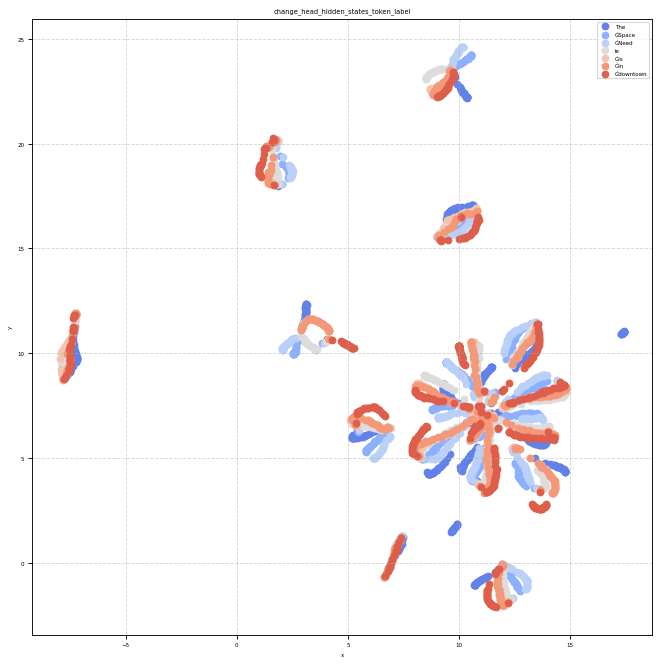

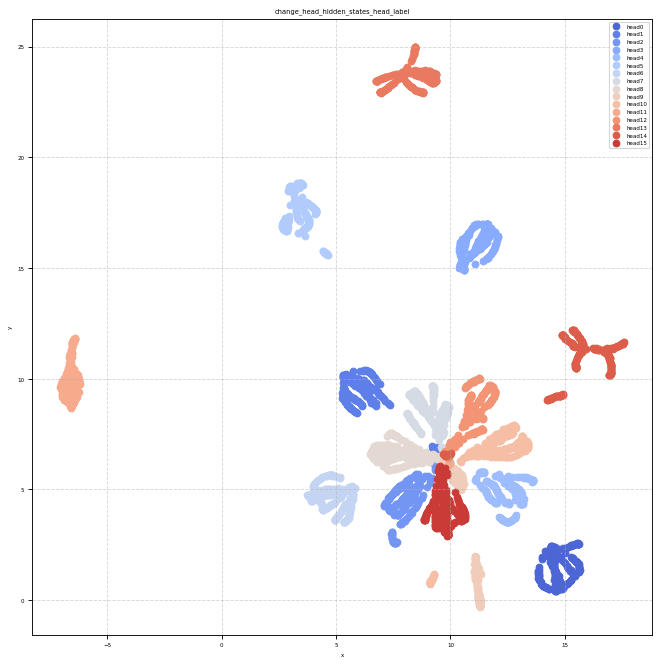

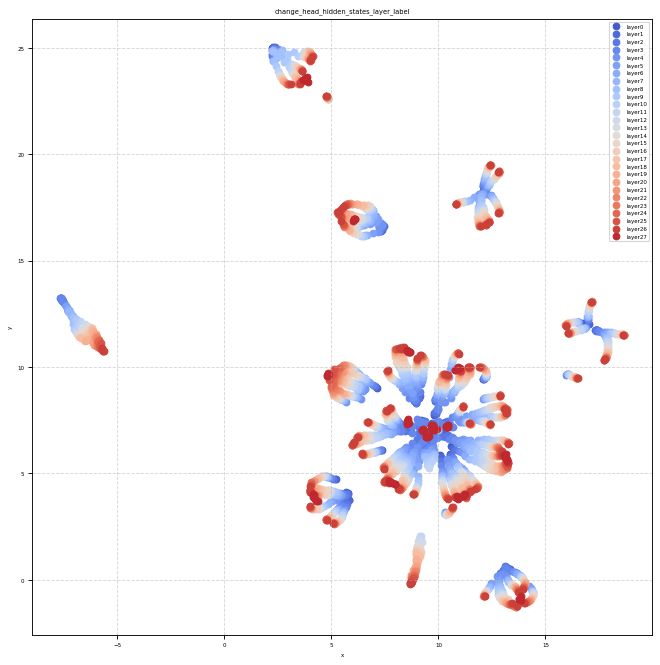

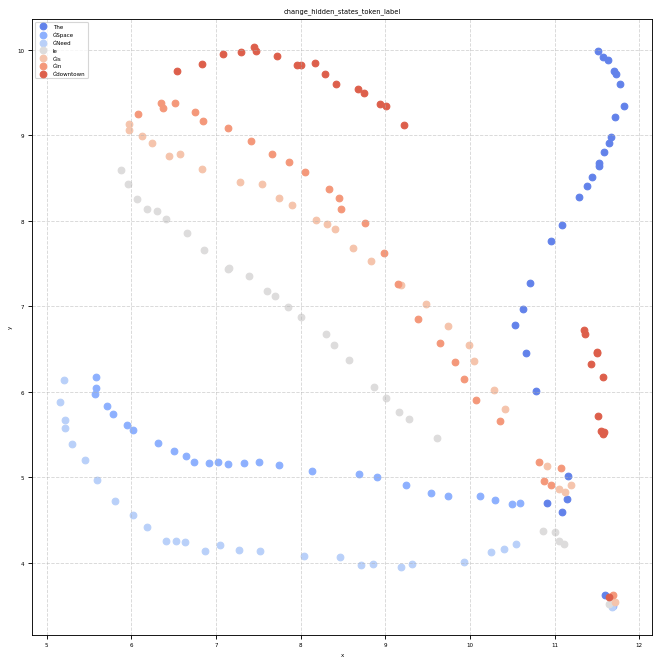

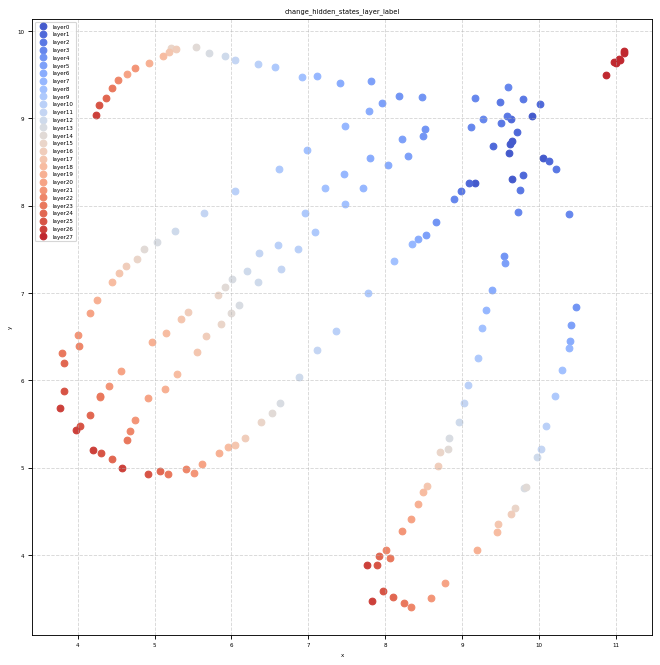

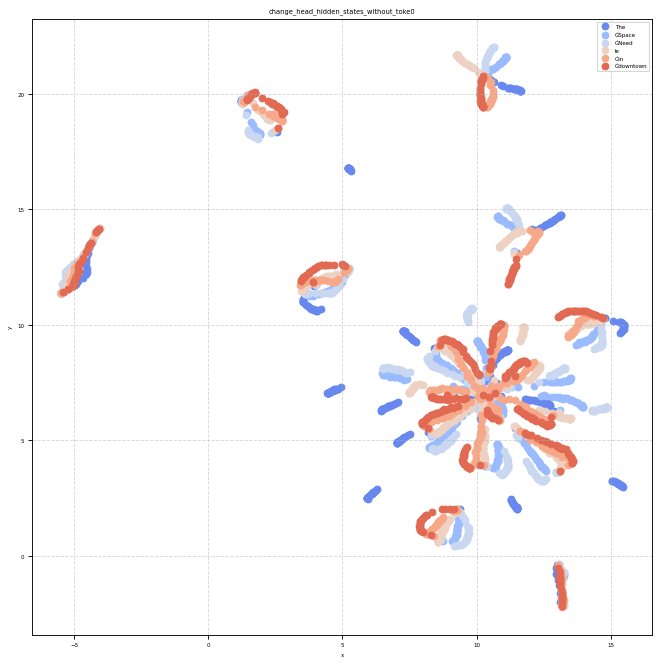

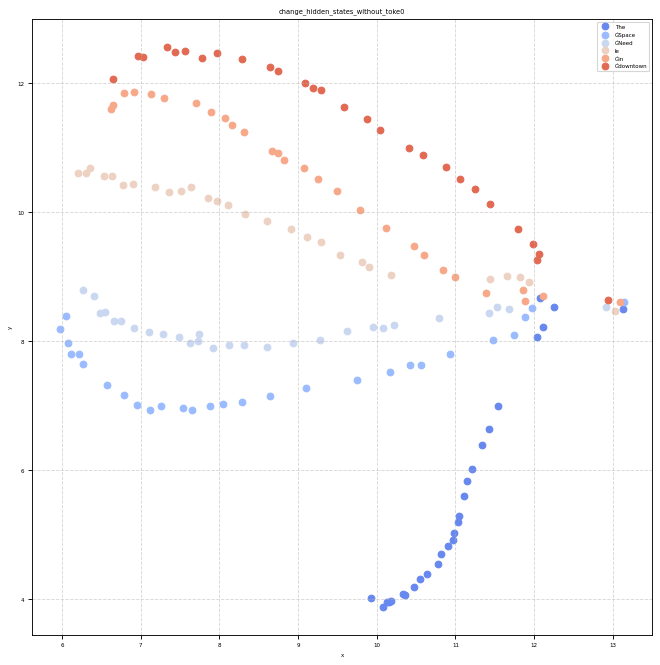

In [38]:
# change hidden state降为可视化
plot_umap(change_head_states, codes,title="change_head_hidden_states_token_label",save_path=save_path)
plot_umap(np.transpose(change_head_states,(0,2,1,3)),head_label,title="change_head_hidden_states_head_label",save_path=save_path)
plot_umap(np.transpose(change_head_states,(2,1,0,3)),layer_label,title="change_head_hidden_states_layer_label",save_path=save_path)
plot_umap(change_hidden_state[1:,np.newaxis,:,:], 
          codes,title="change_hidden_states_token_label",save_path=save_path)
plot_umap(np.transpose(change_hidden_state[1:,np.newaxis,:,:],(2,1,0,3)), 
          layer_label,title="change_hidden_states_layer_label",save_path=save_path)

plot_umap(change_head_states[:,:,list(range(0,4))+list(range(5,7)),:],  codes[:4]+codes[5:]
          ,title="change_head_hidden_states_without_toke0",save_path=save_path)
plot_umap(change_hidden_state[1:,np.newaxis,list(range(0,4))+list(range(5,7)),:], 
          codes[:4]+codes[5:],title="change_hidden_states_without_toke0",save_path=save_path)

In [ ]:
# value降为可视化
plot_umap(past_values, codes,title="head_past_values_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(0,2,1,3)).reshape(past_values.shape[0],past_values.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_values_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(2,1,0,3)), 
          layer_label,title="past_values_layer_label",save_path=save_path)

plot_umap(past_values[:,:,1:,:], codes[1:],title="head_past_values_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(0,2,1,3)).reshape(past_values.shape[0],past_values.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_values_without_toke0_token_label",save_path=save_path)

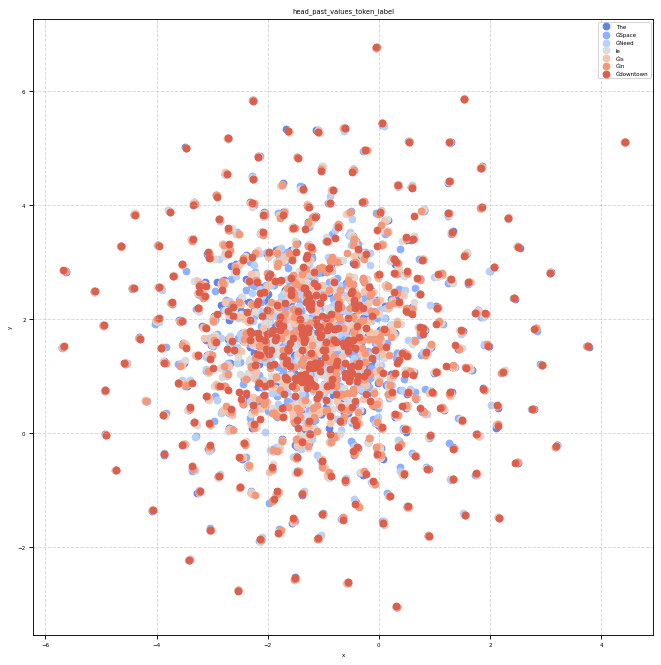

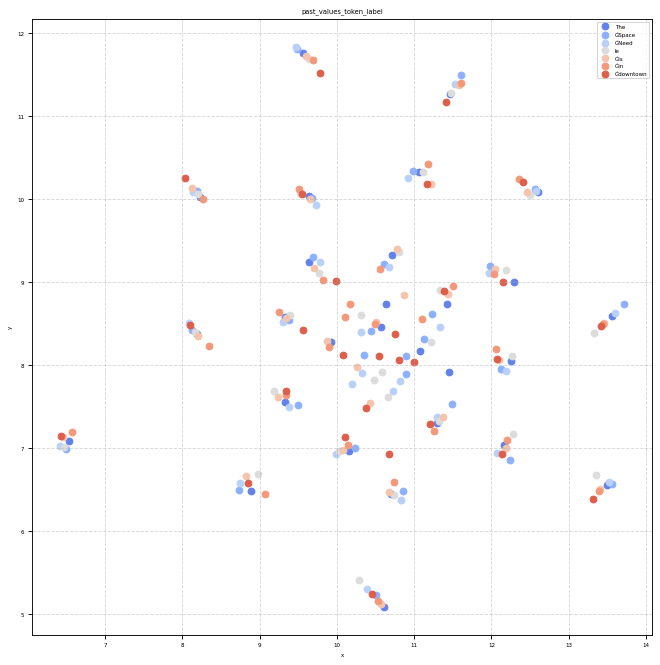

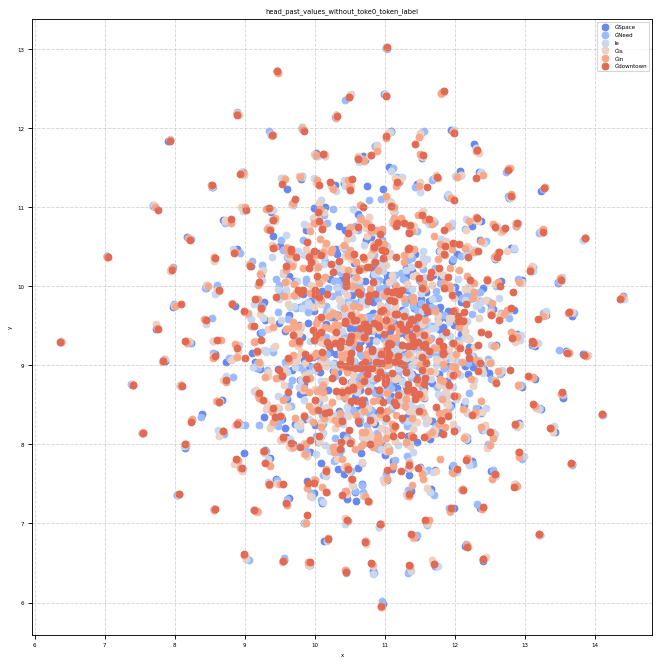

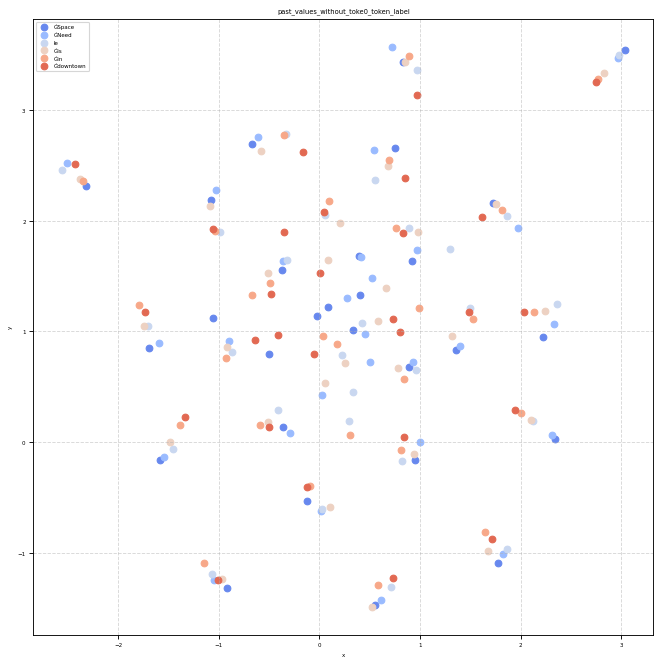

In [40]:
# value降为可视化
past_values = change_past_values
plot_umap(past_values, codes,title="head_past_values_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(0,2,1,3)).reshape(past_values.shape[0],past_values.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_values_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(2,1,0,3)), 
          layer_label,title="past_values_layer_label",save_path=save_path)

plot_umap(past_values[:,:,1:,:], codes[1:],title="head_past_values_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_values,(0,2,1,3)).reshape(past_values.shape[0],past_values.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_values_without_toke0_token_label",save_path=save_path)

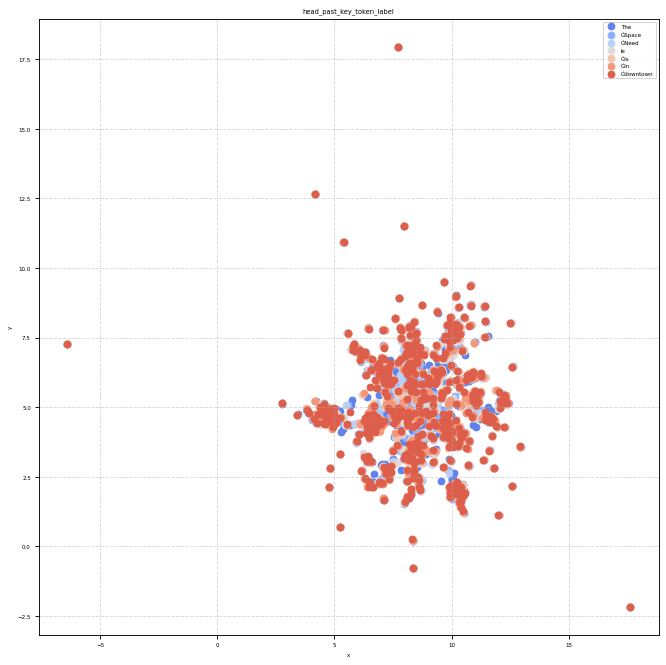

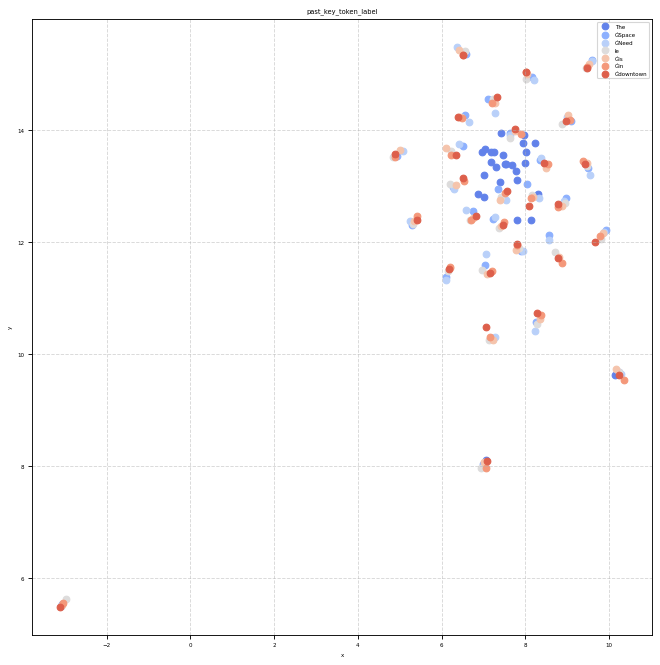

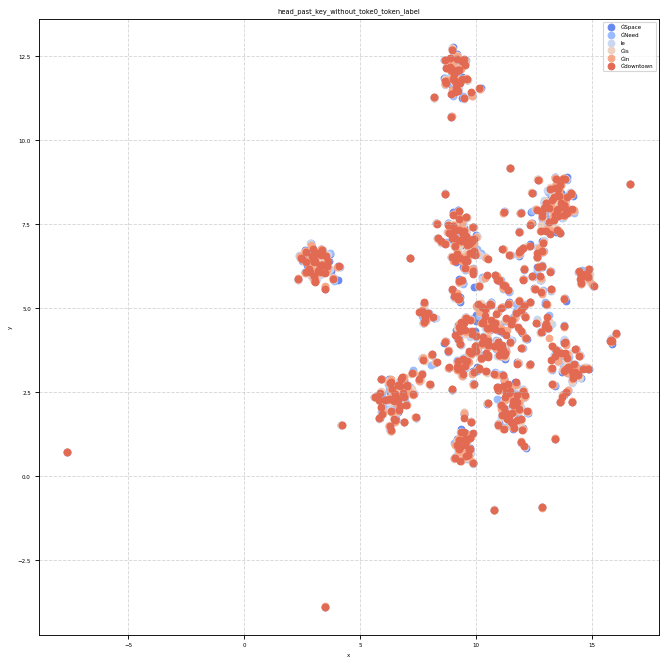

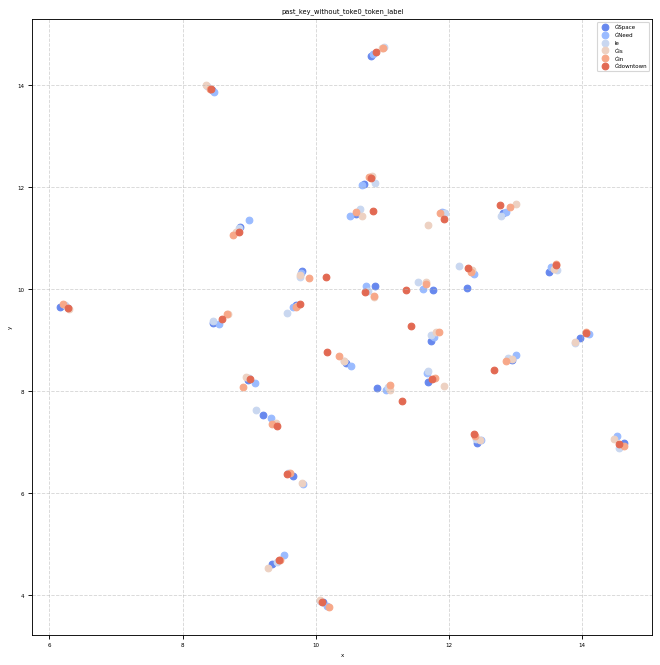

In [41]:
# key降为可视化
plot_umap(past_key, codes,title="head_past_key_token_label",save_path=save_path)
plot_umap(np.transpose(past_key,(0,2,1,3)).reshape(past_key.shape[0],past_key.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_key_token_label",save_path=save_path)

plot_umap(np.transpose(past_key,(2,1,0,3)), 
          layer_label,title="past_key_layer_label",save_path=save_path)

plot_umap(past_key[:,:,1:,:], codes[1:],title="head_past_key_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_key,(0,2,1,3)).reshape(past_key.shape[0],past_key.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_key_without_toke0_token_label",save_path=save_path)

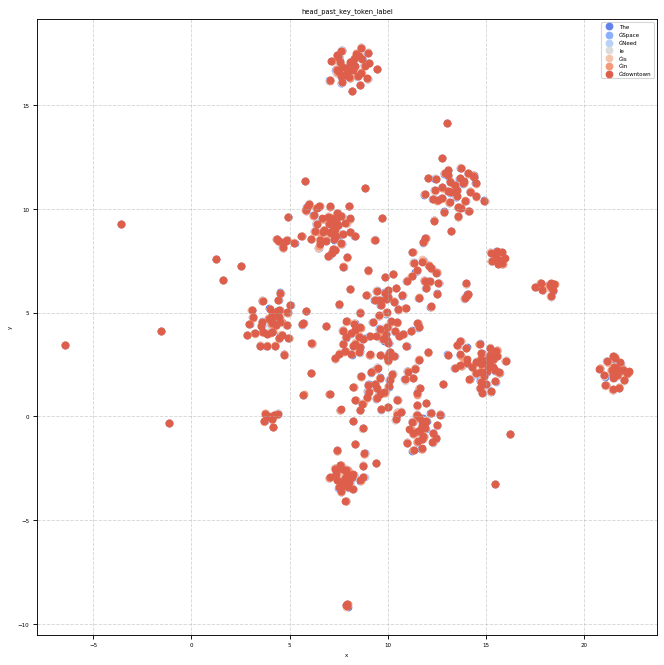

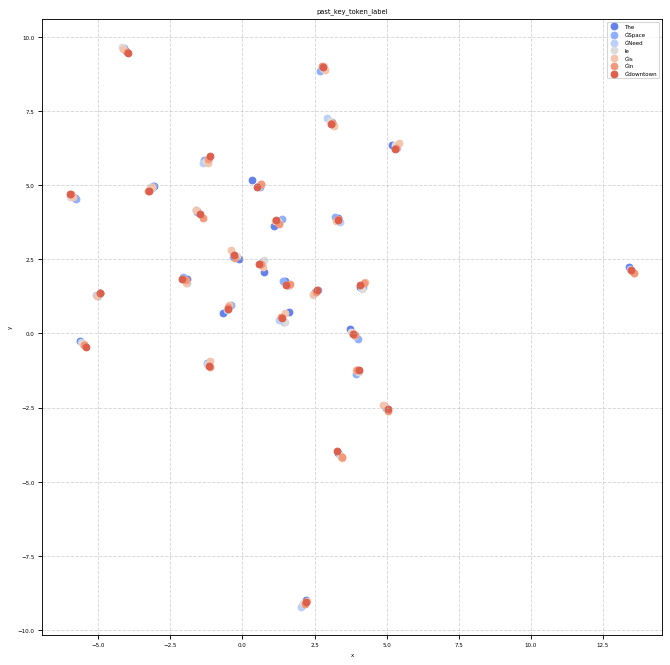

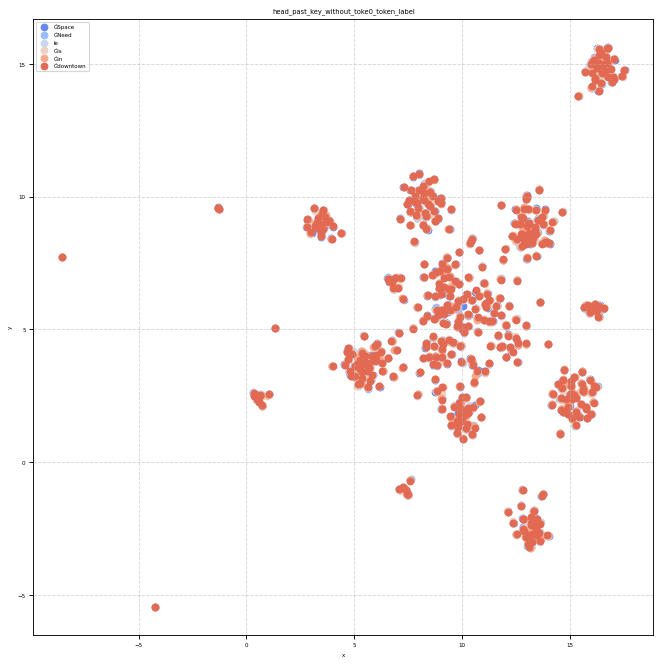

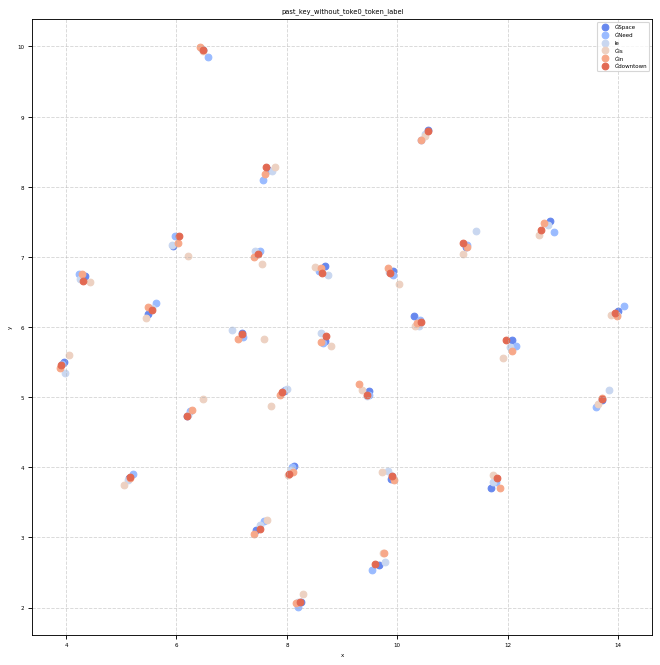

In [43]:
# key降为可视化
past_key=change_past_key
plot_umap(past_key, codes,title="head_past_key_token_label",save_path=save_path)
plot_umap(np.transpose(past_key,(0,2,1,3)).reshape(past_key.shape[0],past_key.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_key_token_label",save_path=save_path)
plot_umap(np.transpose(past_key,(2,1,0,3)), 
          layer_label,title="past_key_layer_label",save_path=save_path)

plot_umap(past_key[:,:,1:,:], codes[1:],title="head_past_key_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_key,(0,2,1,3)).reshape(past_key.shape[0],past_key.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_key_without_toke0_token_label",save_path=save_path)

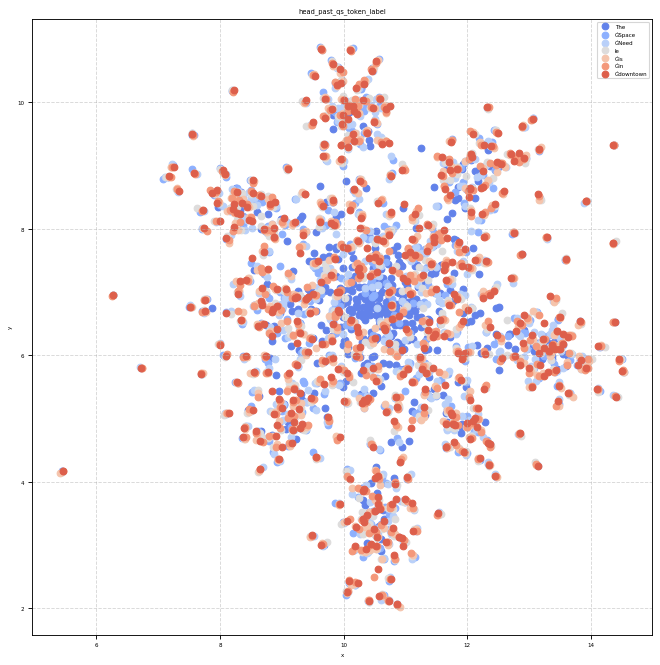

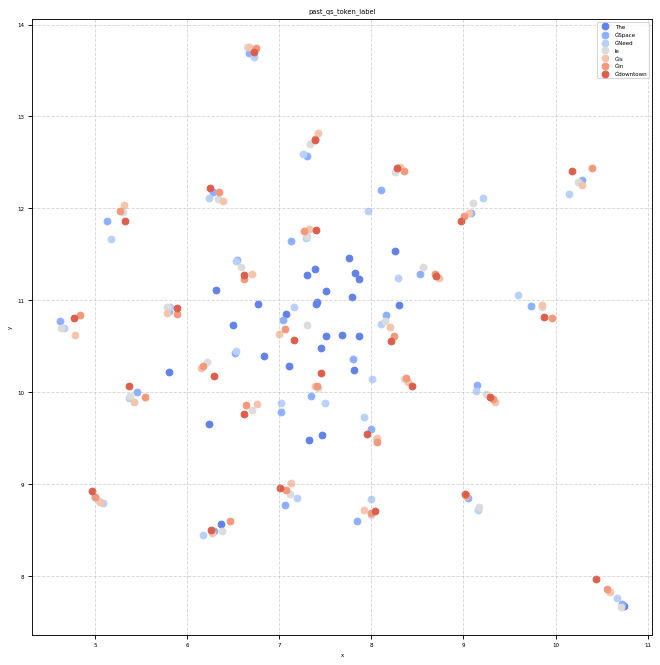

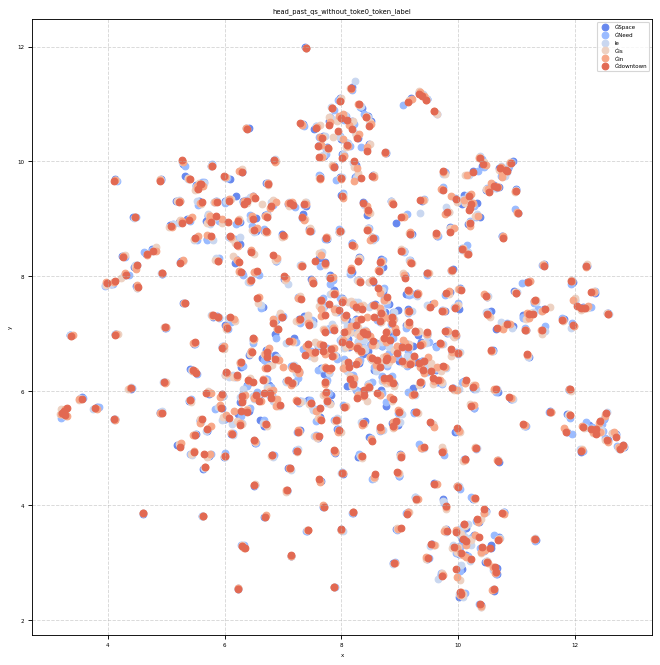

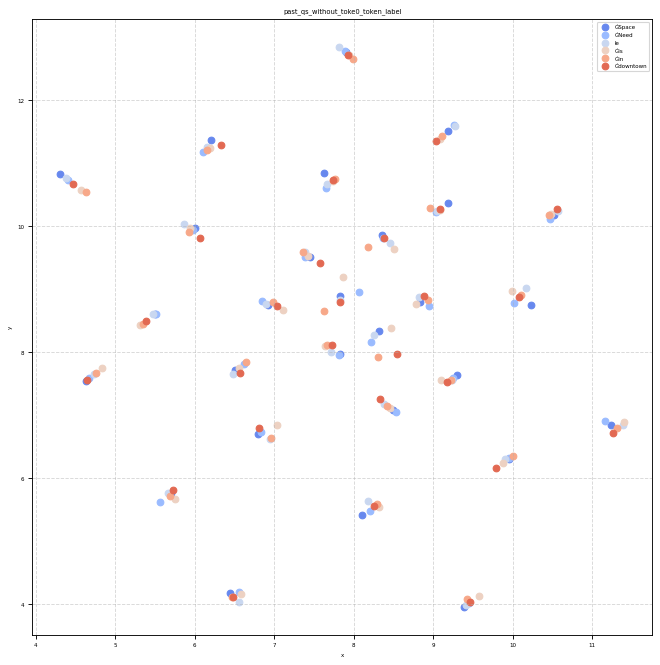

In [44]:
# q降为可视化
plot_umap(past_qs, codes,title="head_past_qs_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(0,2,1,3)).reshape(past_qs.shape[0],past_qs.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_qs_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(2,1,0,3)), 
          layer_label,title="past_qs_layer_label",save_path=save_path)

plot_umap(past_qs[:,:,1:,:], codes[1:],title="head_past_qs_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(0,2,1,3)).reshape(past_qs.shape[0],past_qs.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_qs_without_toke0_token_label",save_path=save_path)


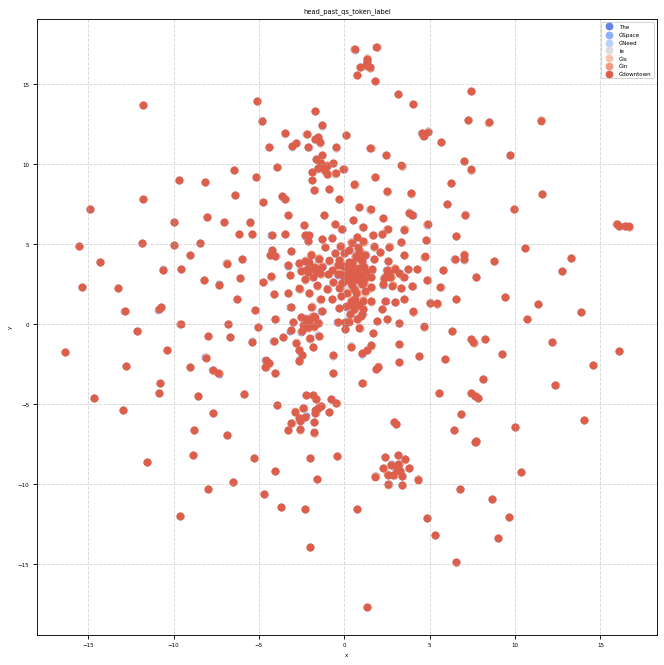

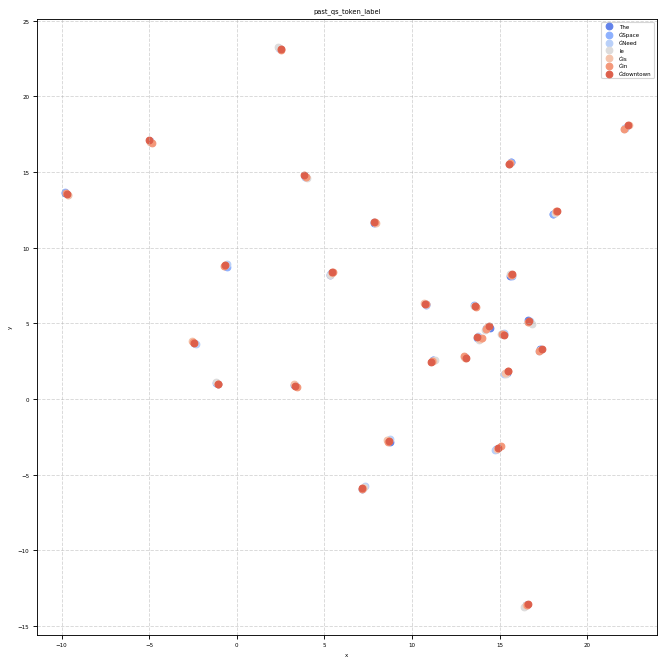

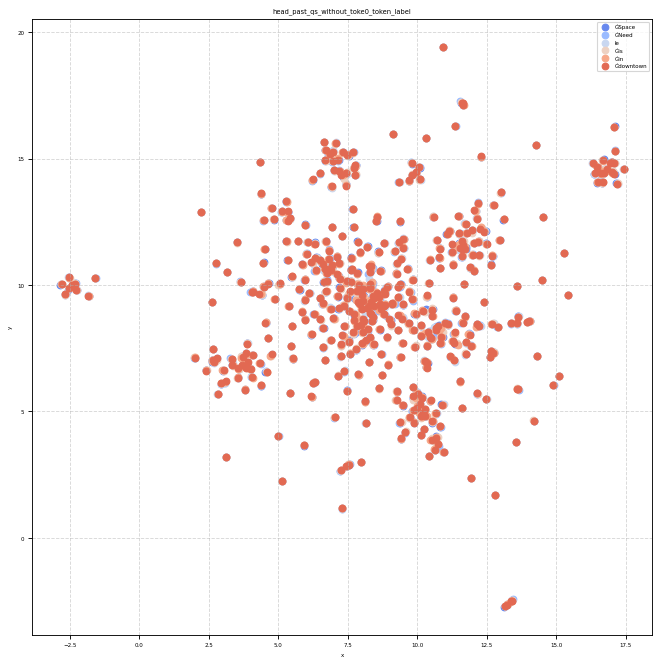

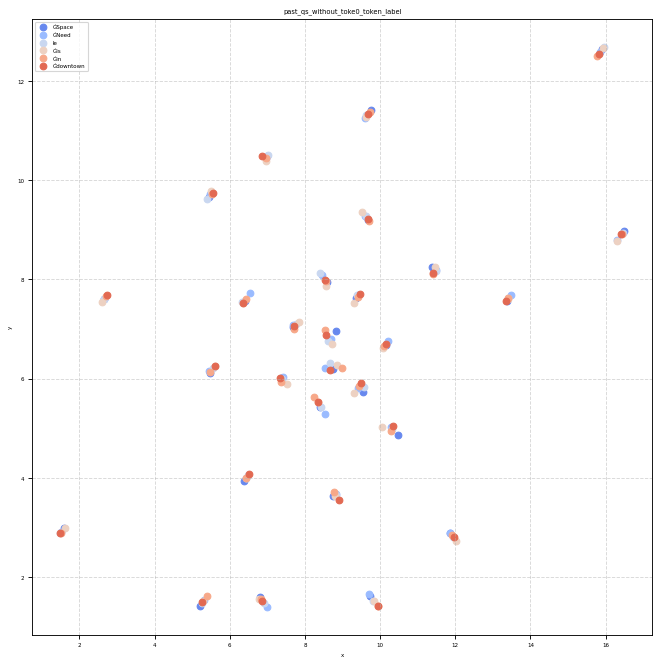

In [45]:
# q降为可视化
past_qs = change_past_qs
plot_umap(past_qs, codes,title="head_past_qs_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(0,2,1,3)).reshape(past_qs.shape[0],past_qs.shape[2], -1)[:,np.newaxis,:,:],
           codes,title="past_qs_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(2,1,0,3)), 
          layer_label,title="past_qs_layer_label",save_path=save_path)

plot_umap(past_qs[:,:,1:,:], codes[1:],title="head_past_qs_without_toke0_token_label",save_path=save_path)
plot_umap(np.transpose(past_qs,(0,2,1,3)).reshape(past_qs.shape[0],past_qs.shape[2], -1)[:,np.newaxis,1:,:],
           codes[1:],title="past_qs_without_toke0_token_label",save_path=save_path)


0


/scr1/wyang107/projects/LLM/my_projects/actiavtion/pretrain_activation/gpt_neo.py:350: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots(figsize=(10, 10), dpi=80)


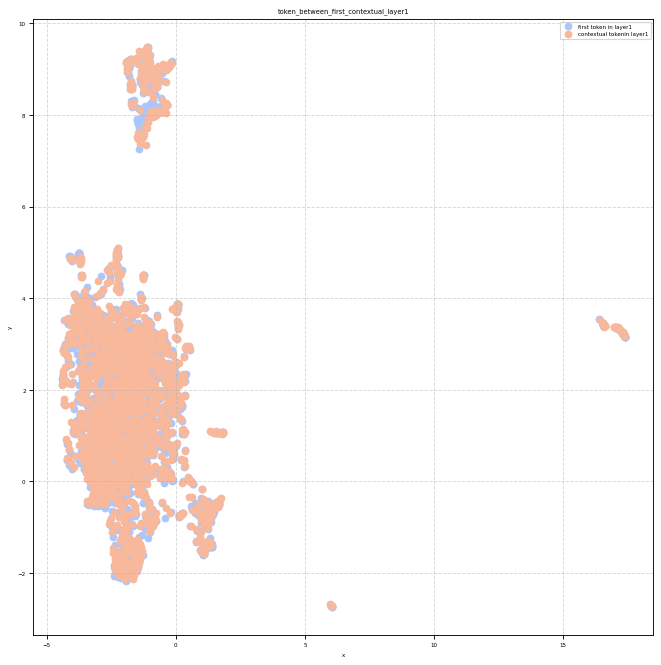

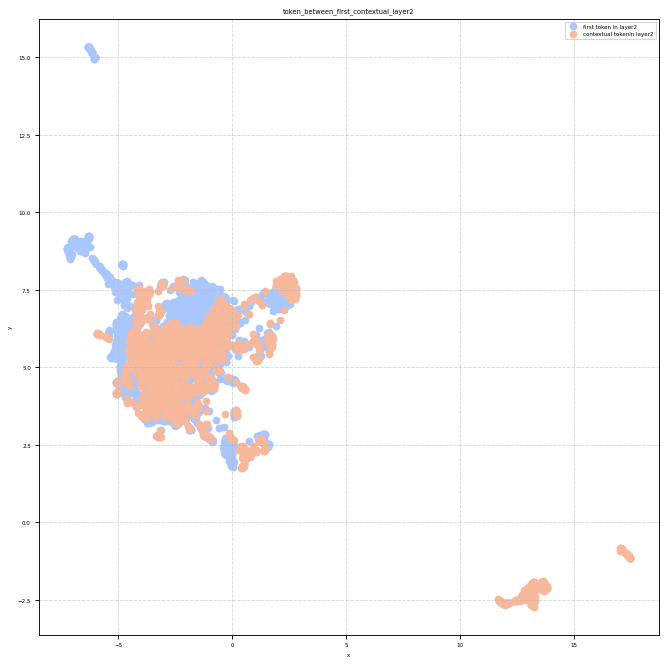

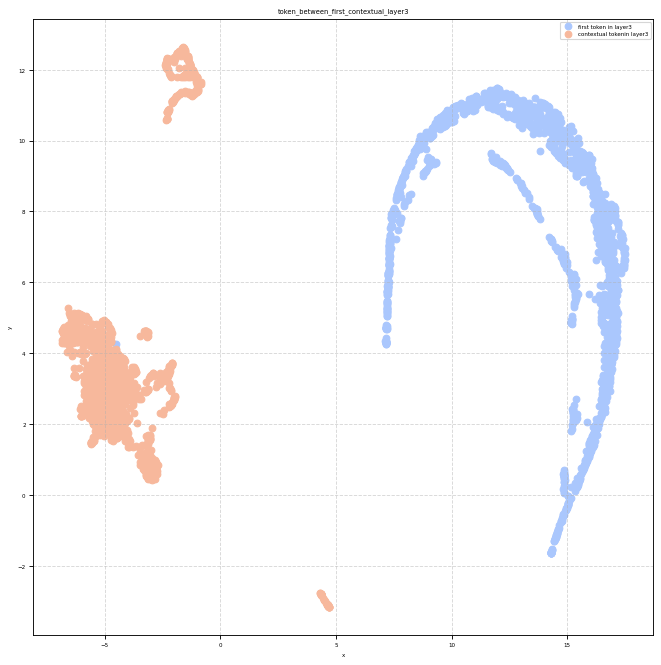

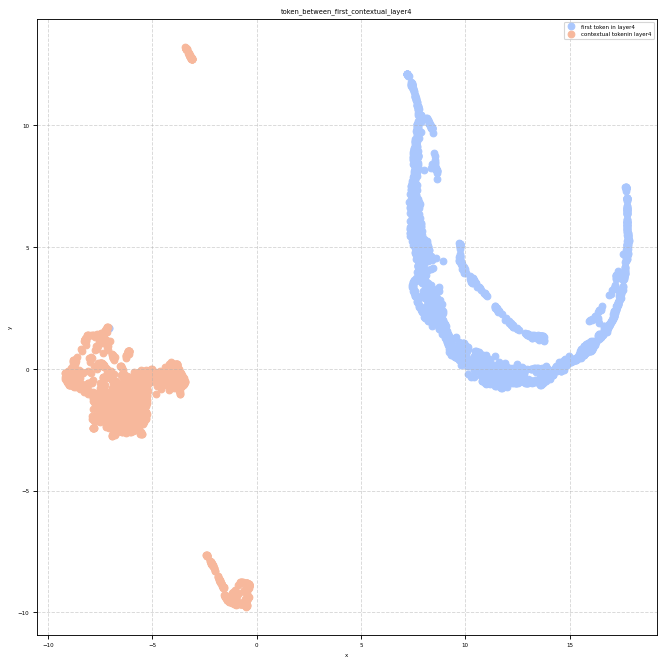

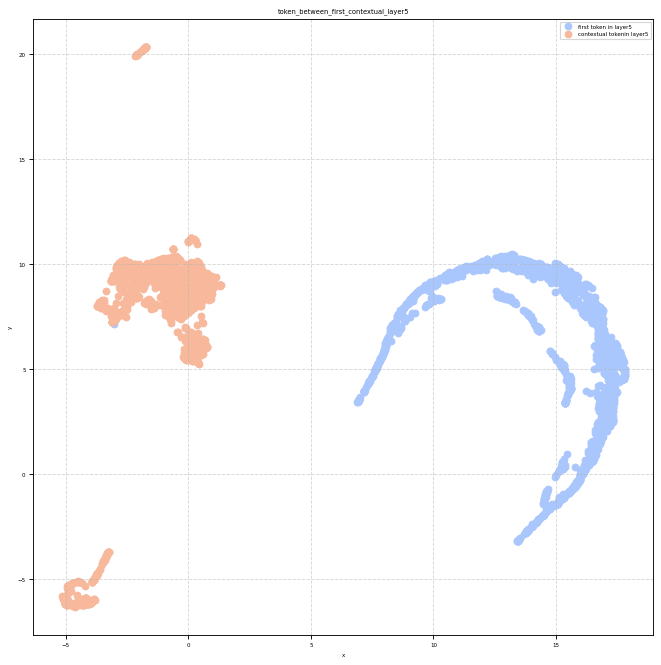

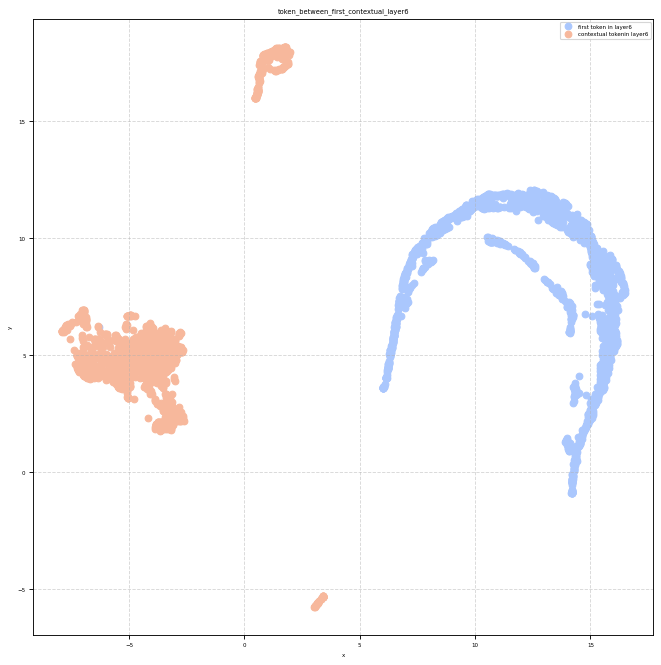

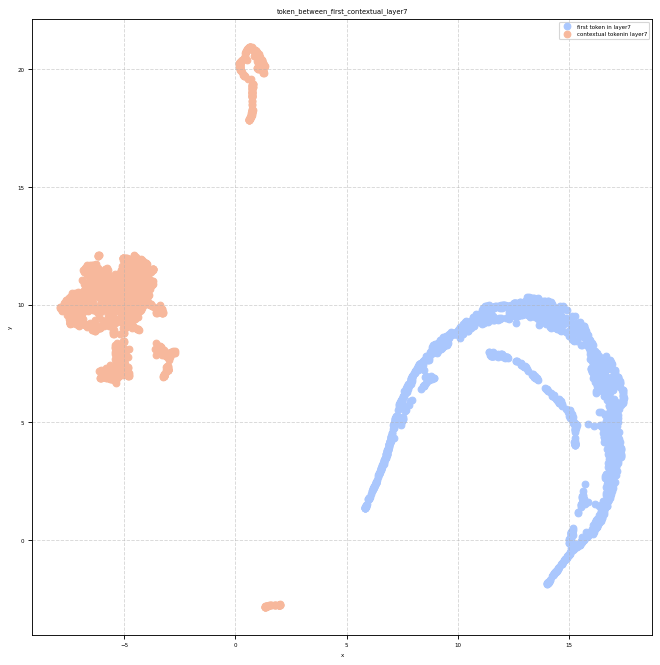

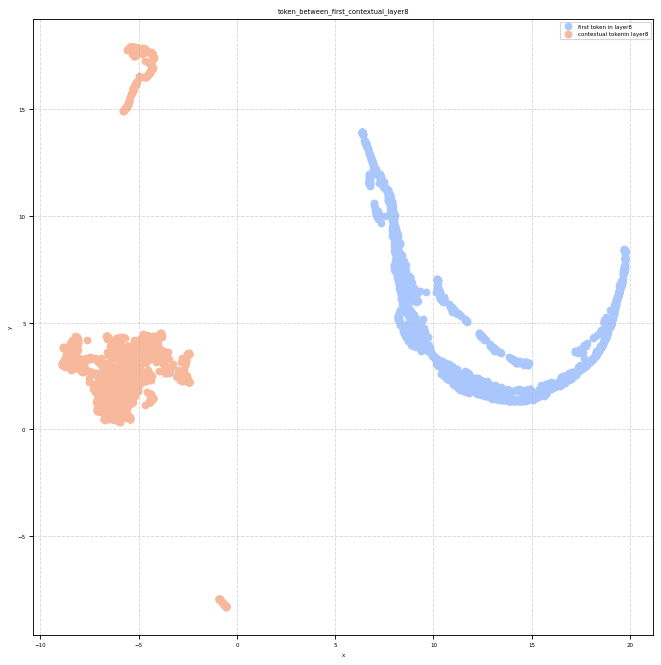

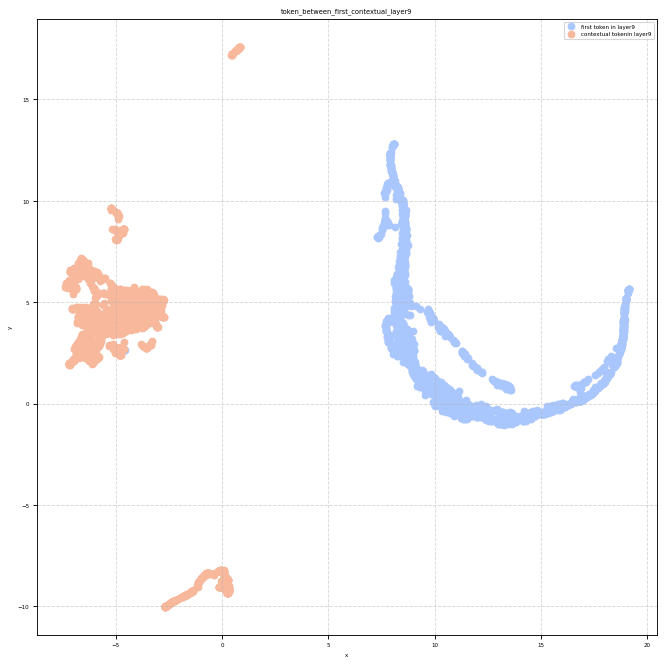

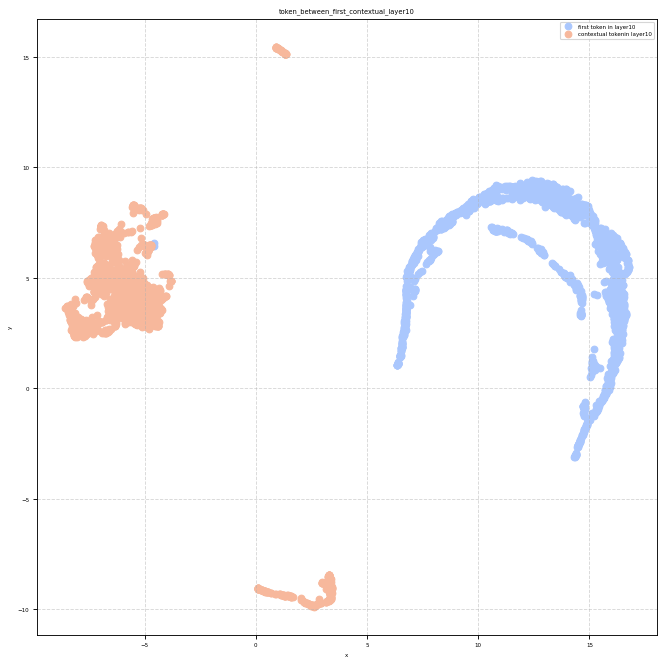

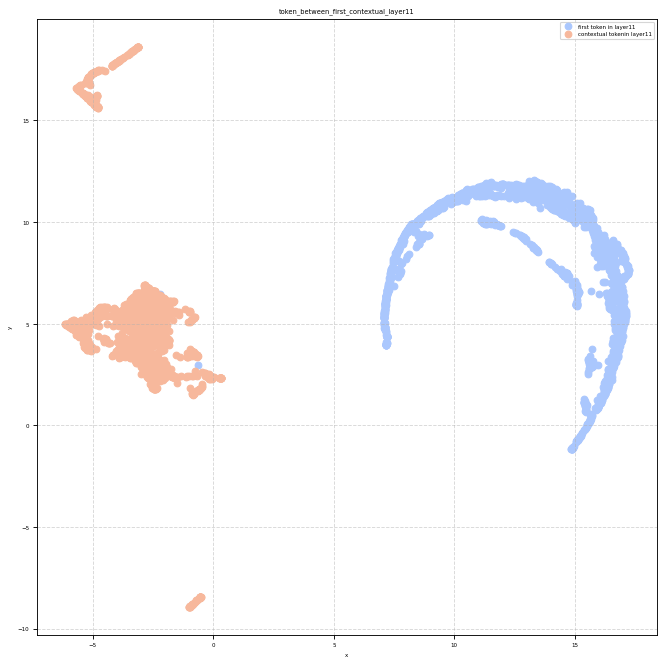

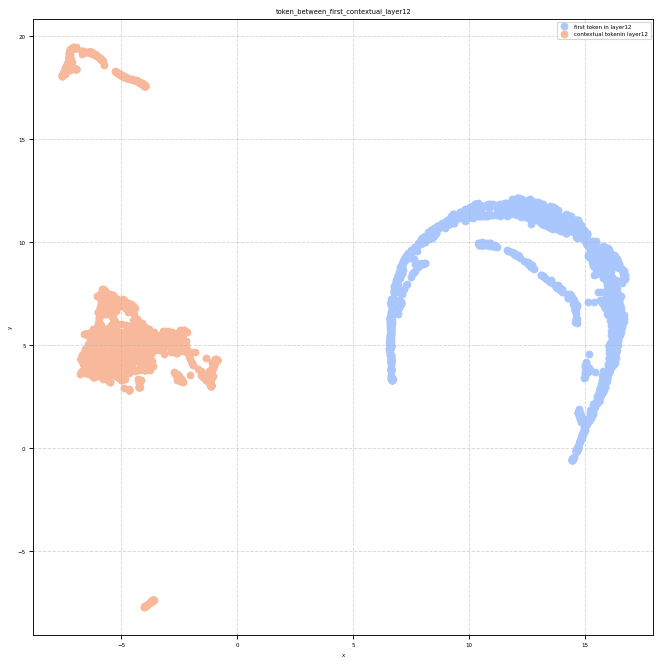

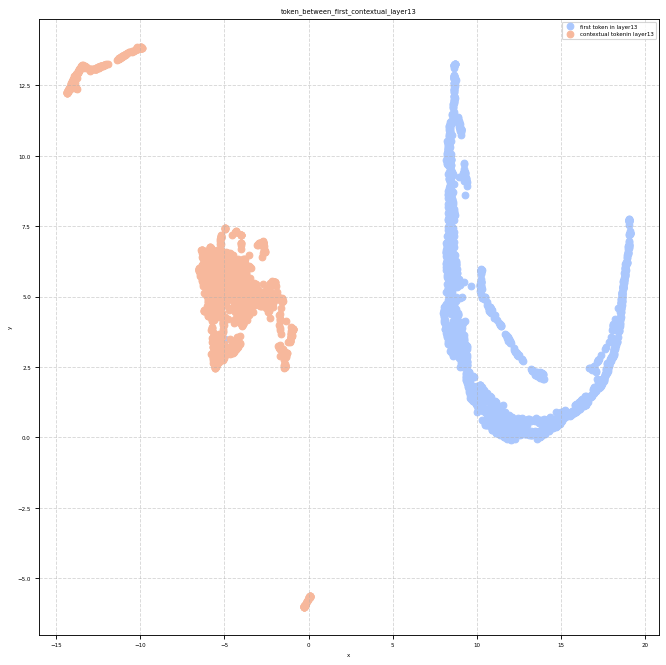

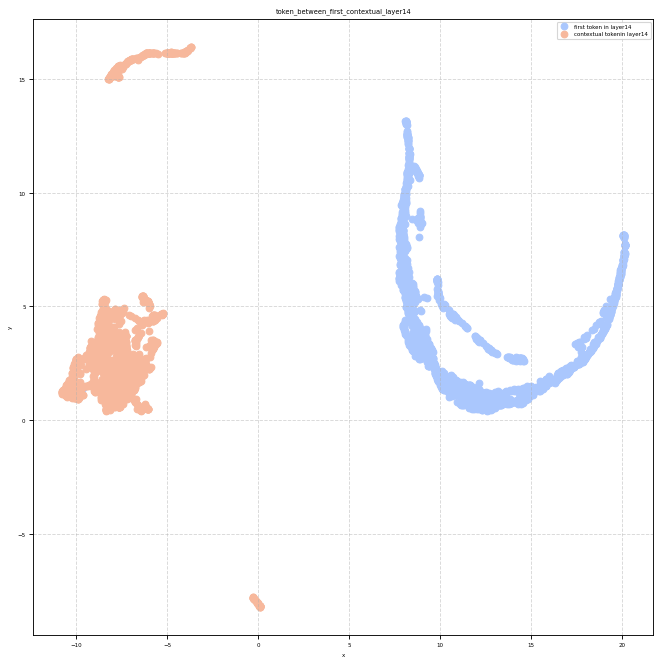

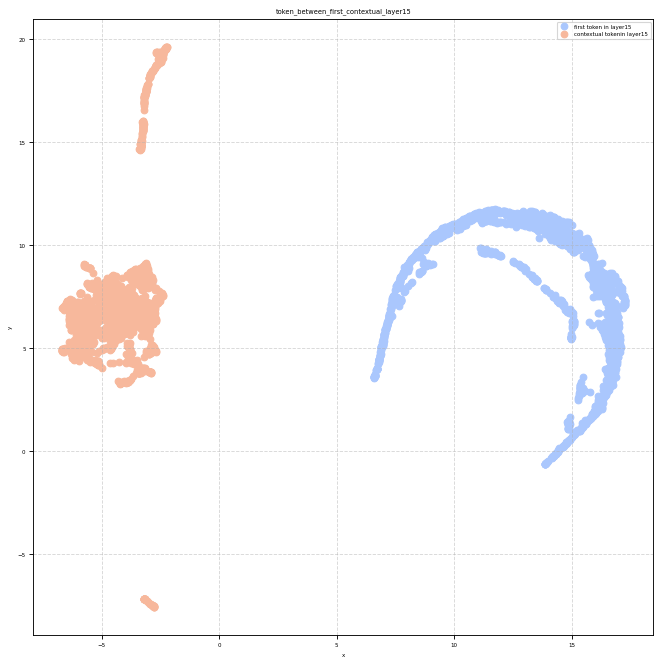

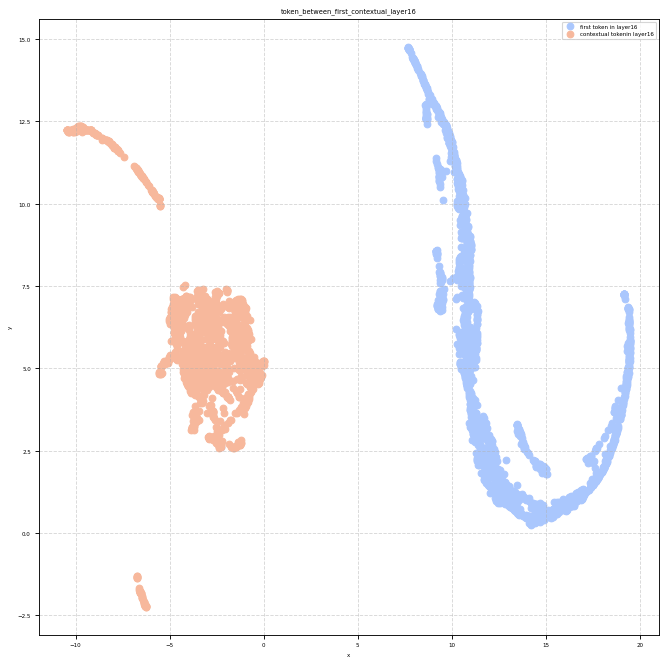

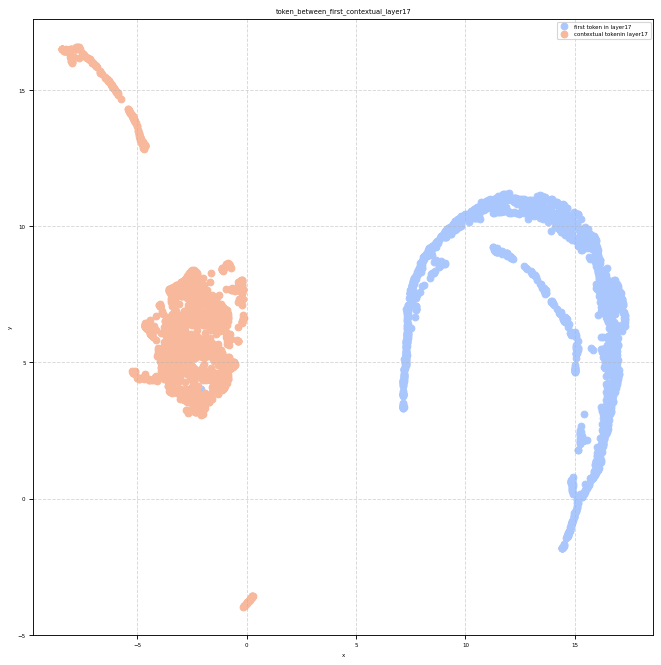

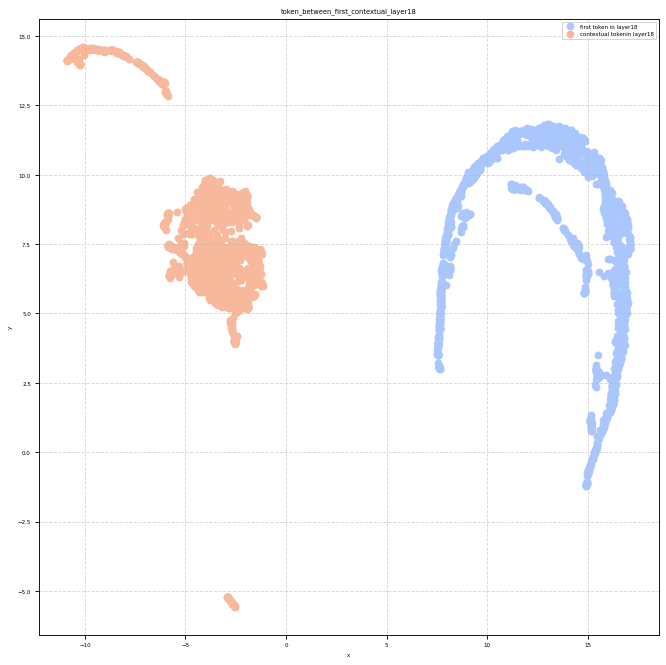

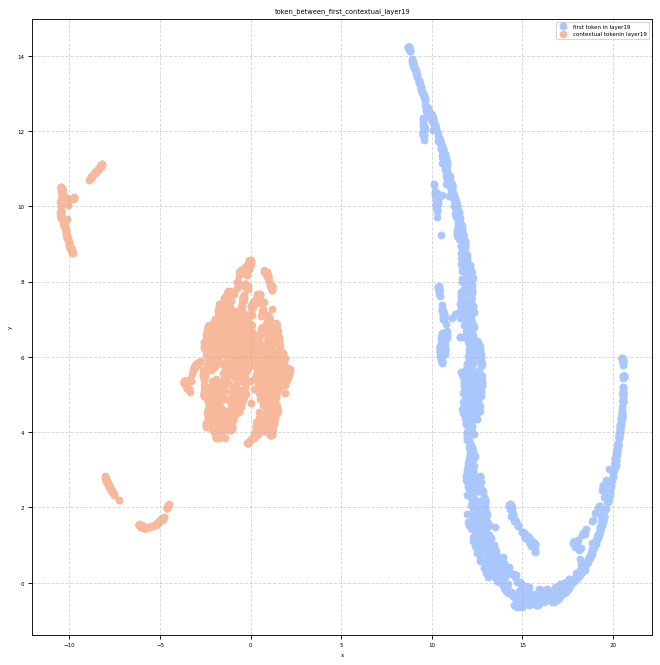

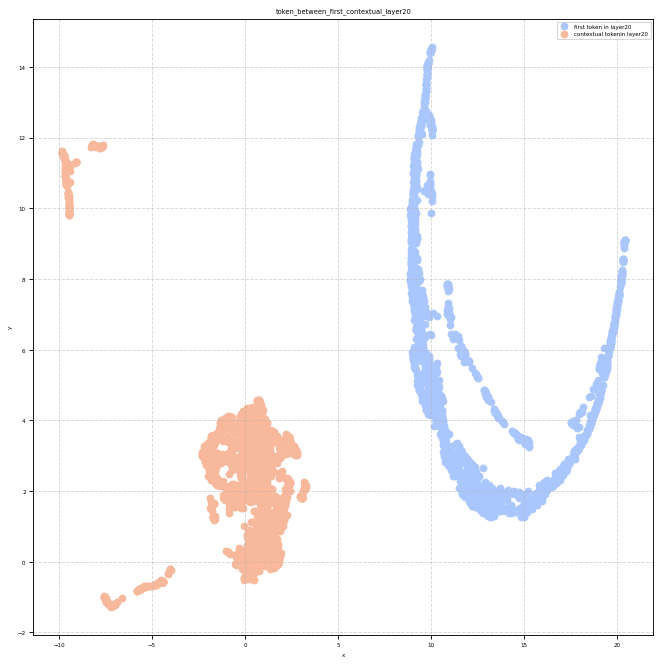

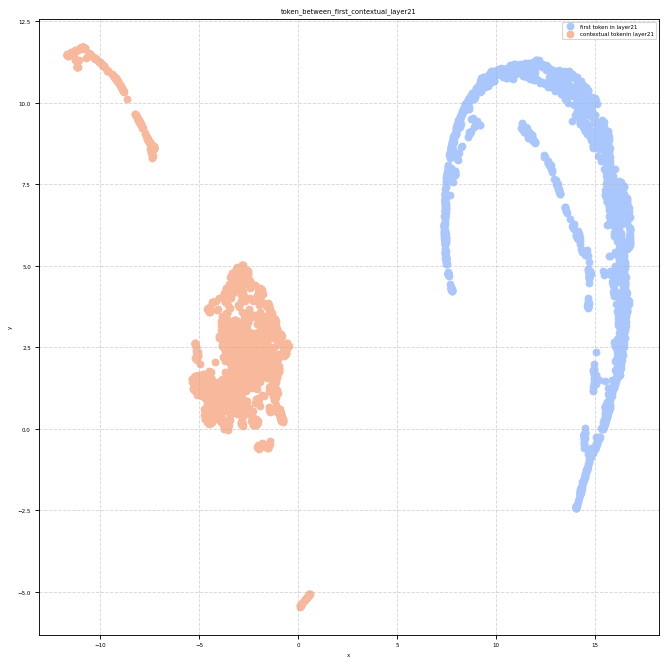

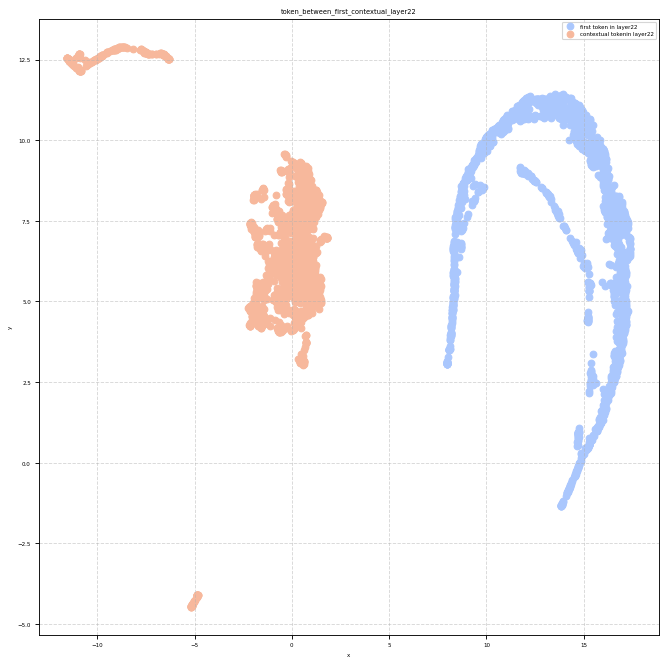

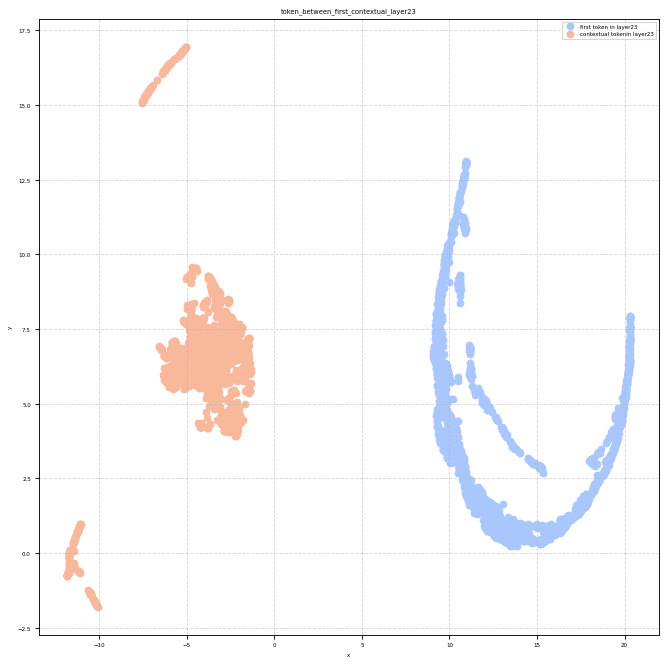

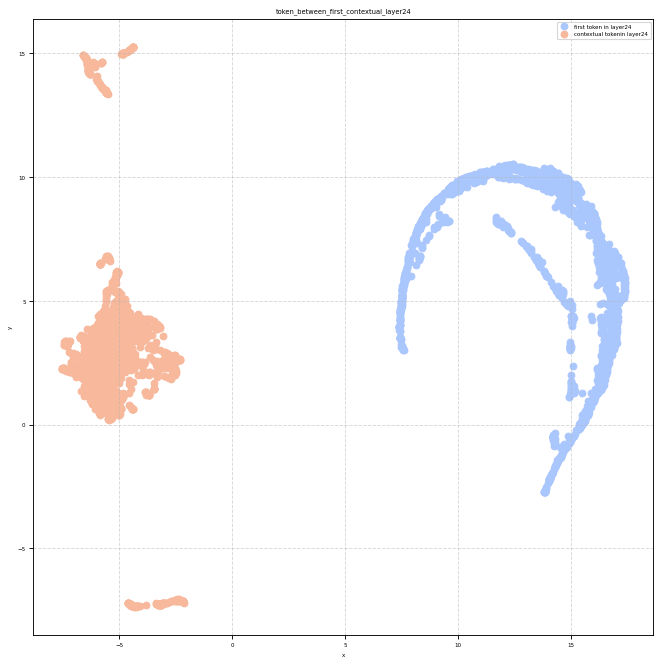

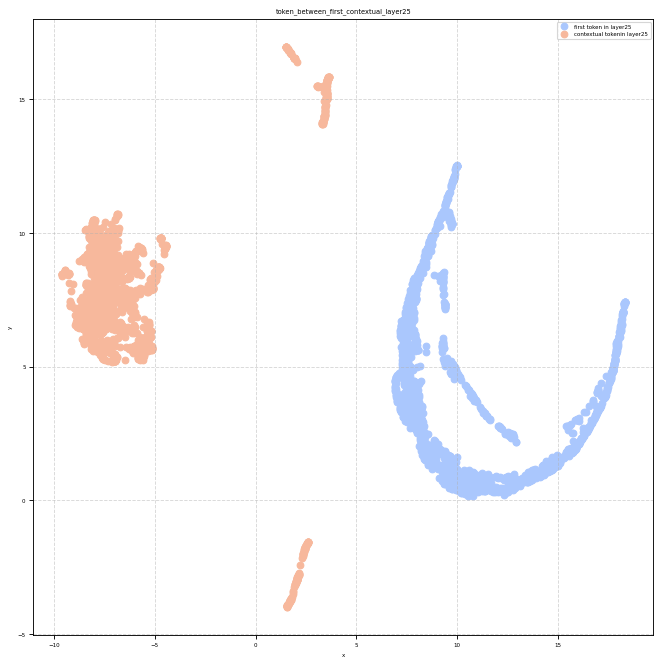

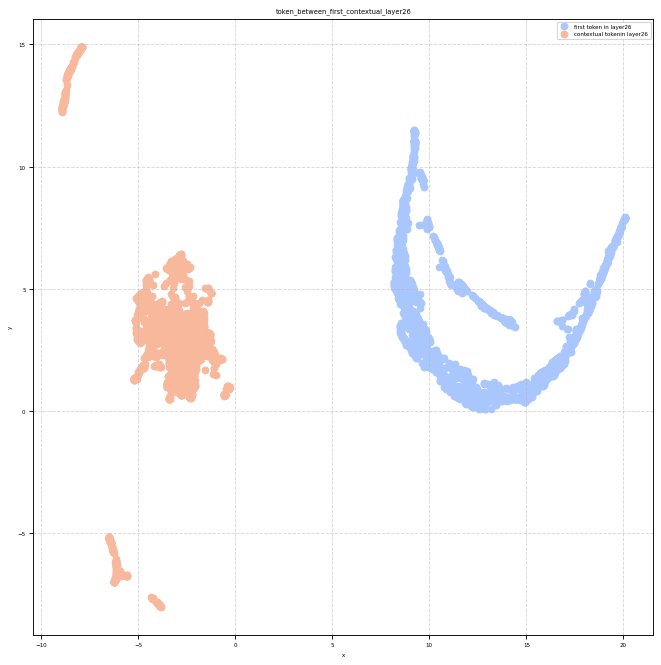

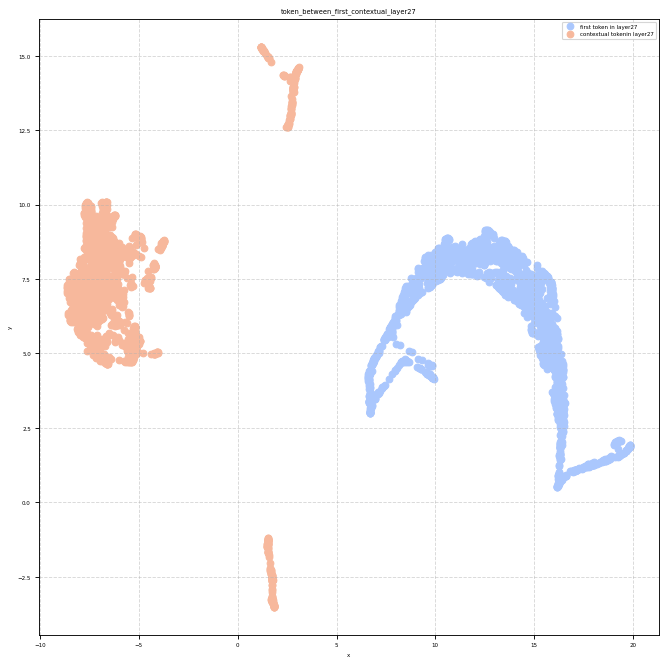

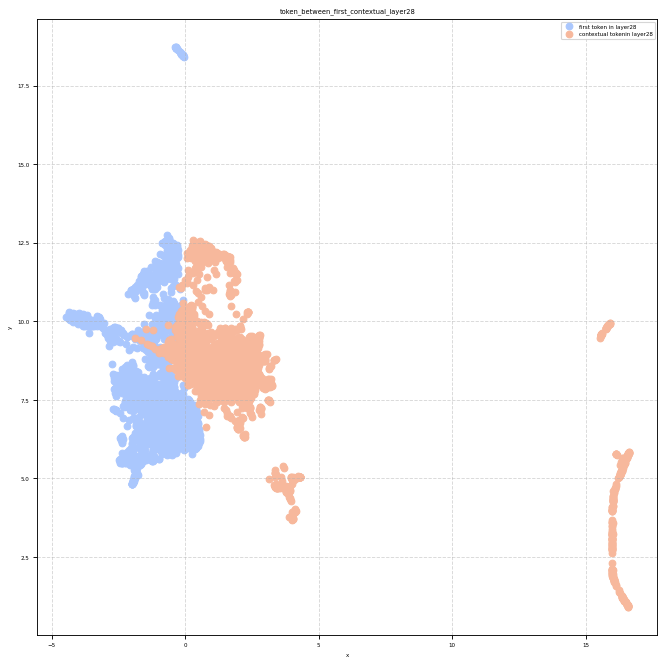

In [11]:
import pickle
save_path = os.path.join(sys.path[0], './results/single_token_results.dat')
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        results_dict = pickle.load(f)
else : results_dict = {}
count = 0
for key, value in results_dict.items():
    if len(value) != 4 : count+=1
print(count)
save_path = os.path.join(sys.path[0], './result/token_between_first_contextual')
layer_ids = range(1,29)
result_state = None
for layer_id in layer_ids:
    hidden_state_list,hidden_state_list2 = [],[]
    for key, value in results_dict.items():
        hidden_state = value[0][layer_id, 0, :]
        hidden_state2 = value[1][layer_id, 1, :]
        hidden_state_list.append(hidden_state)
        hidden_state_list2.append(hidden_state2)
    hidden_state = np.vstack(hidden_state_list)[:,np.newaxis, np.newaxis,:]
    hidden_state2 = np.vstack(hidden_state_list2)[:, np.newaxis, np.newaxis,:]
    result_state = np.concatenate((hidden_state,hidden_state2), axis=2)
    plot_umap(result_state, [f'first token in layer{layer_id}', f'contextual tokenin layer{layer_id}'],
    title=f"token_between_first_contextual_layer{layer_id}",save_path=save_path)

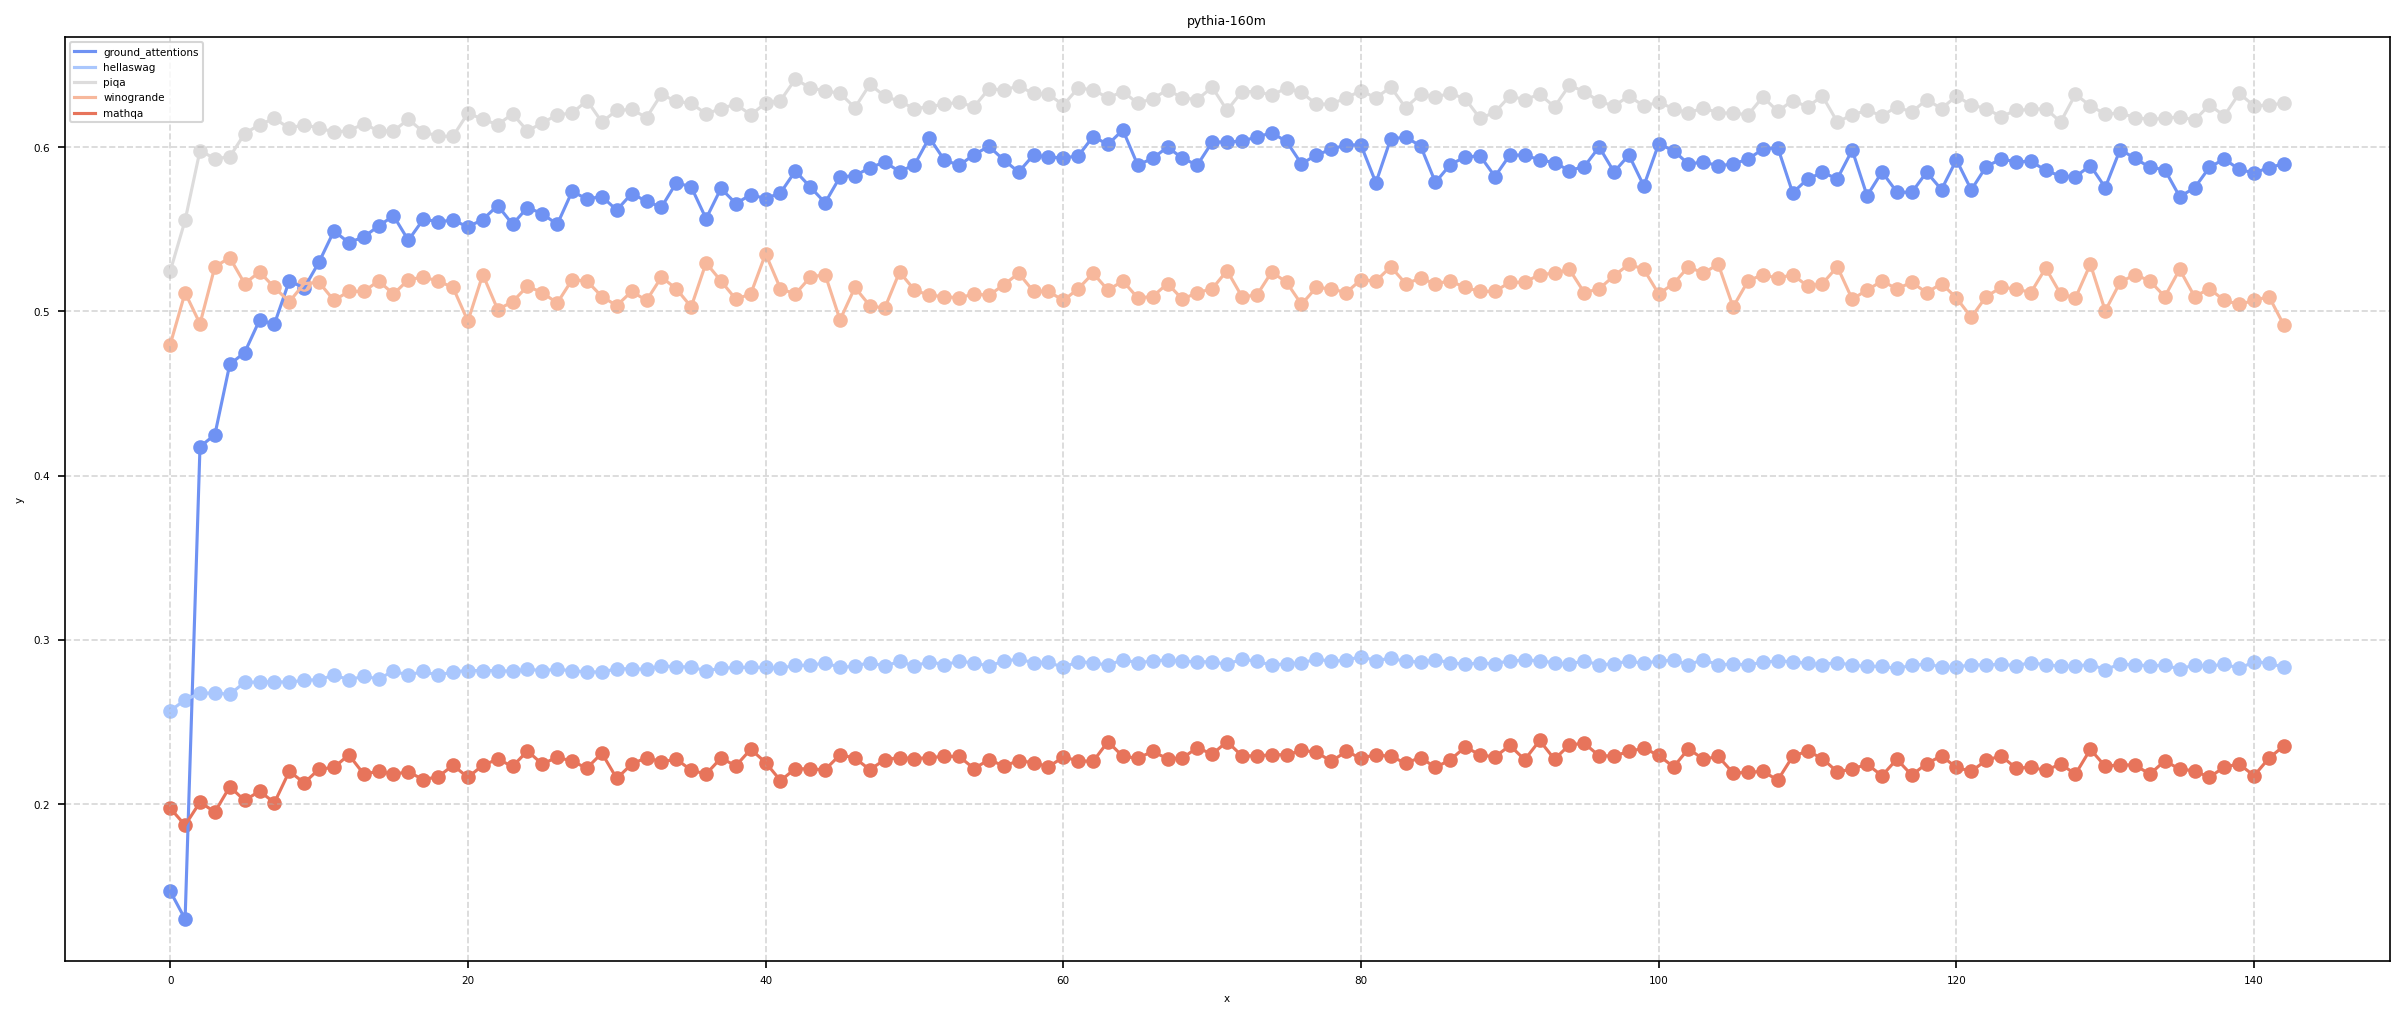

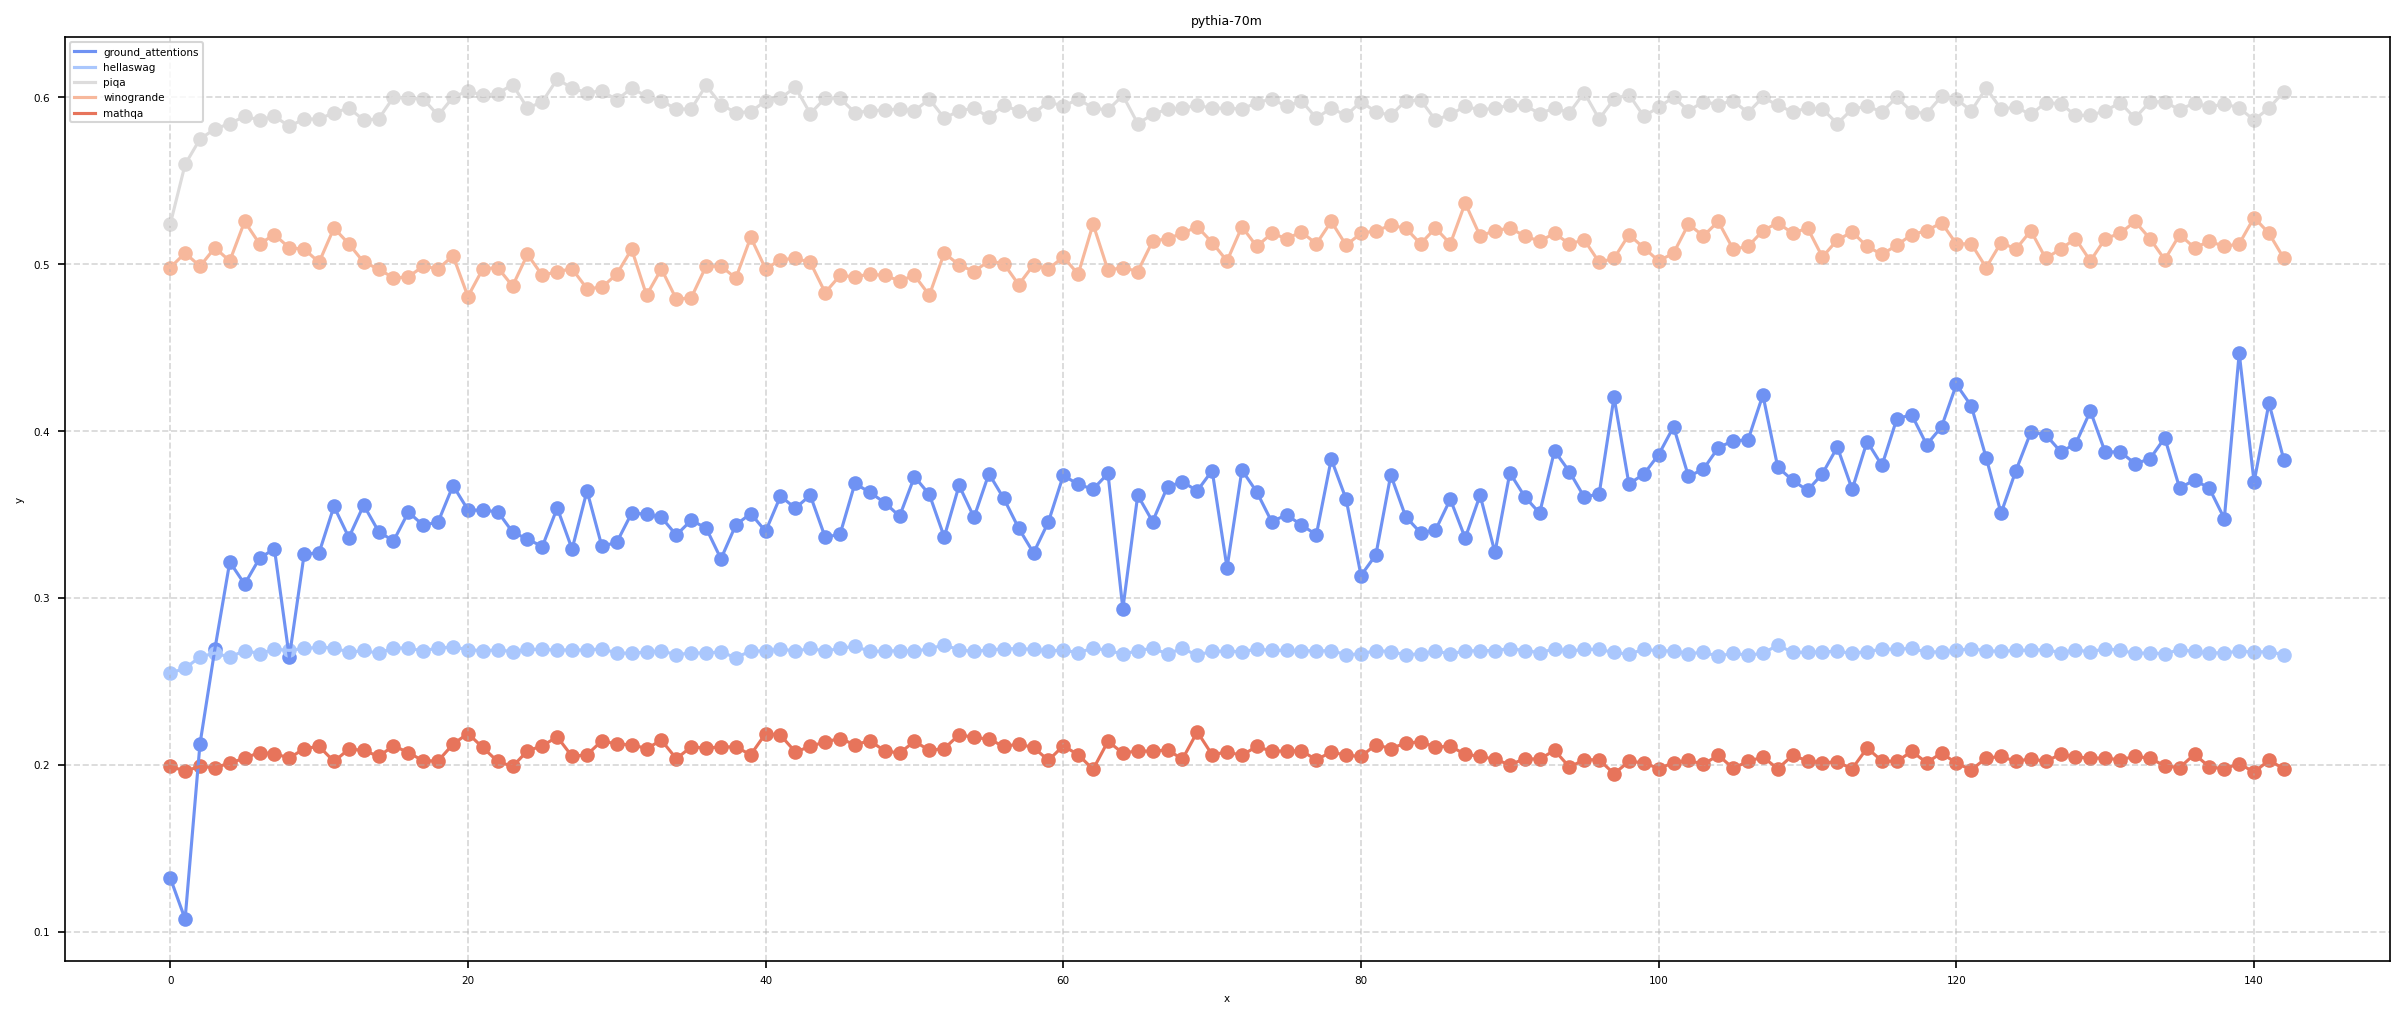

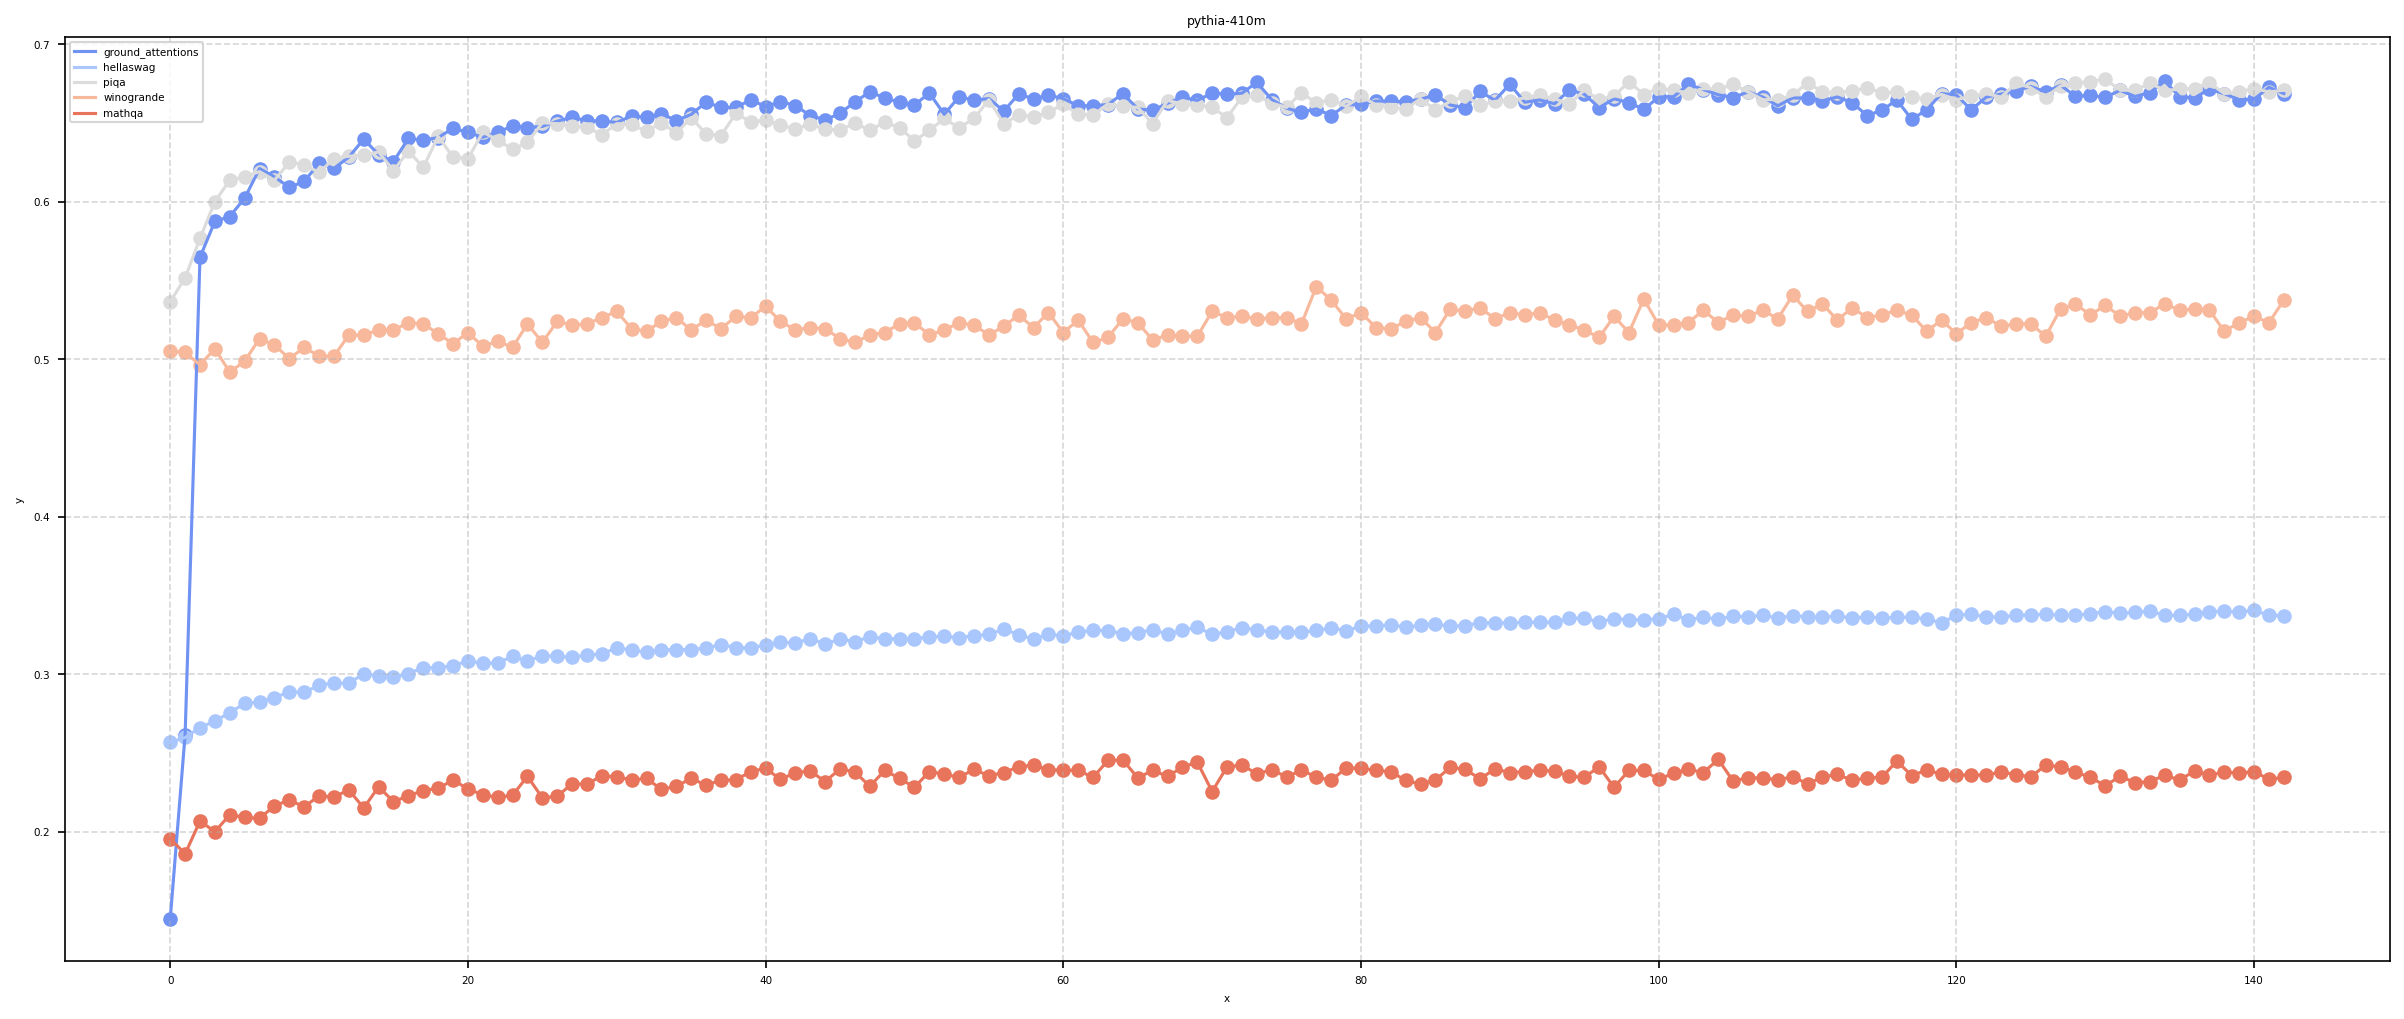

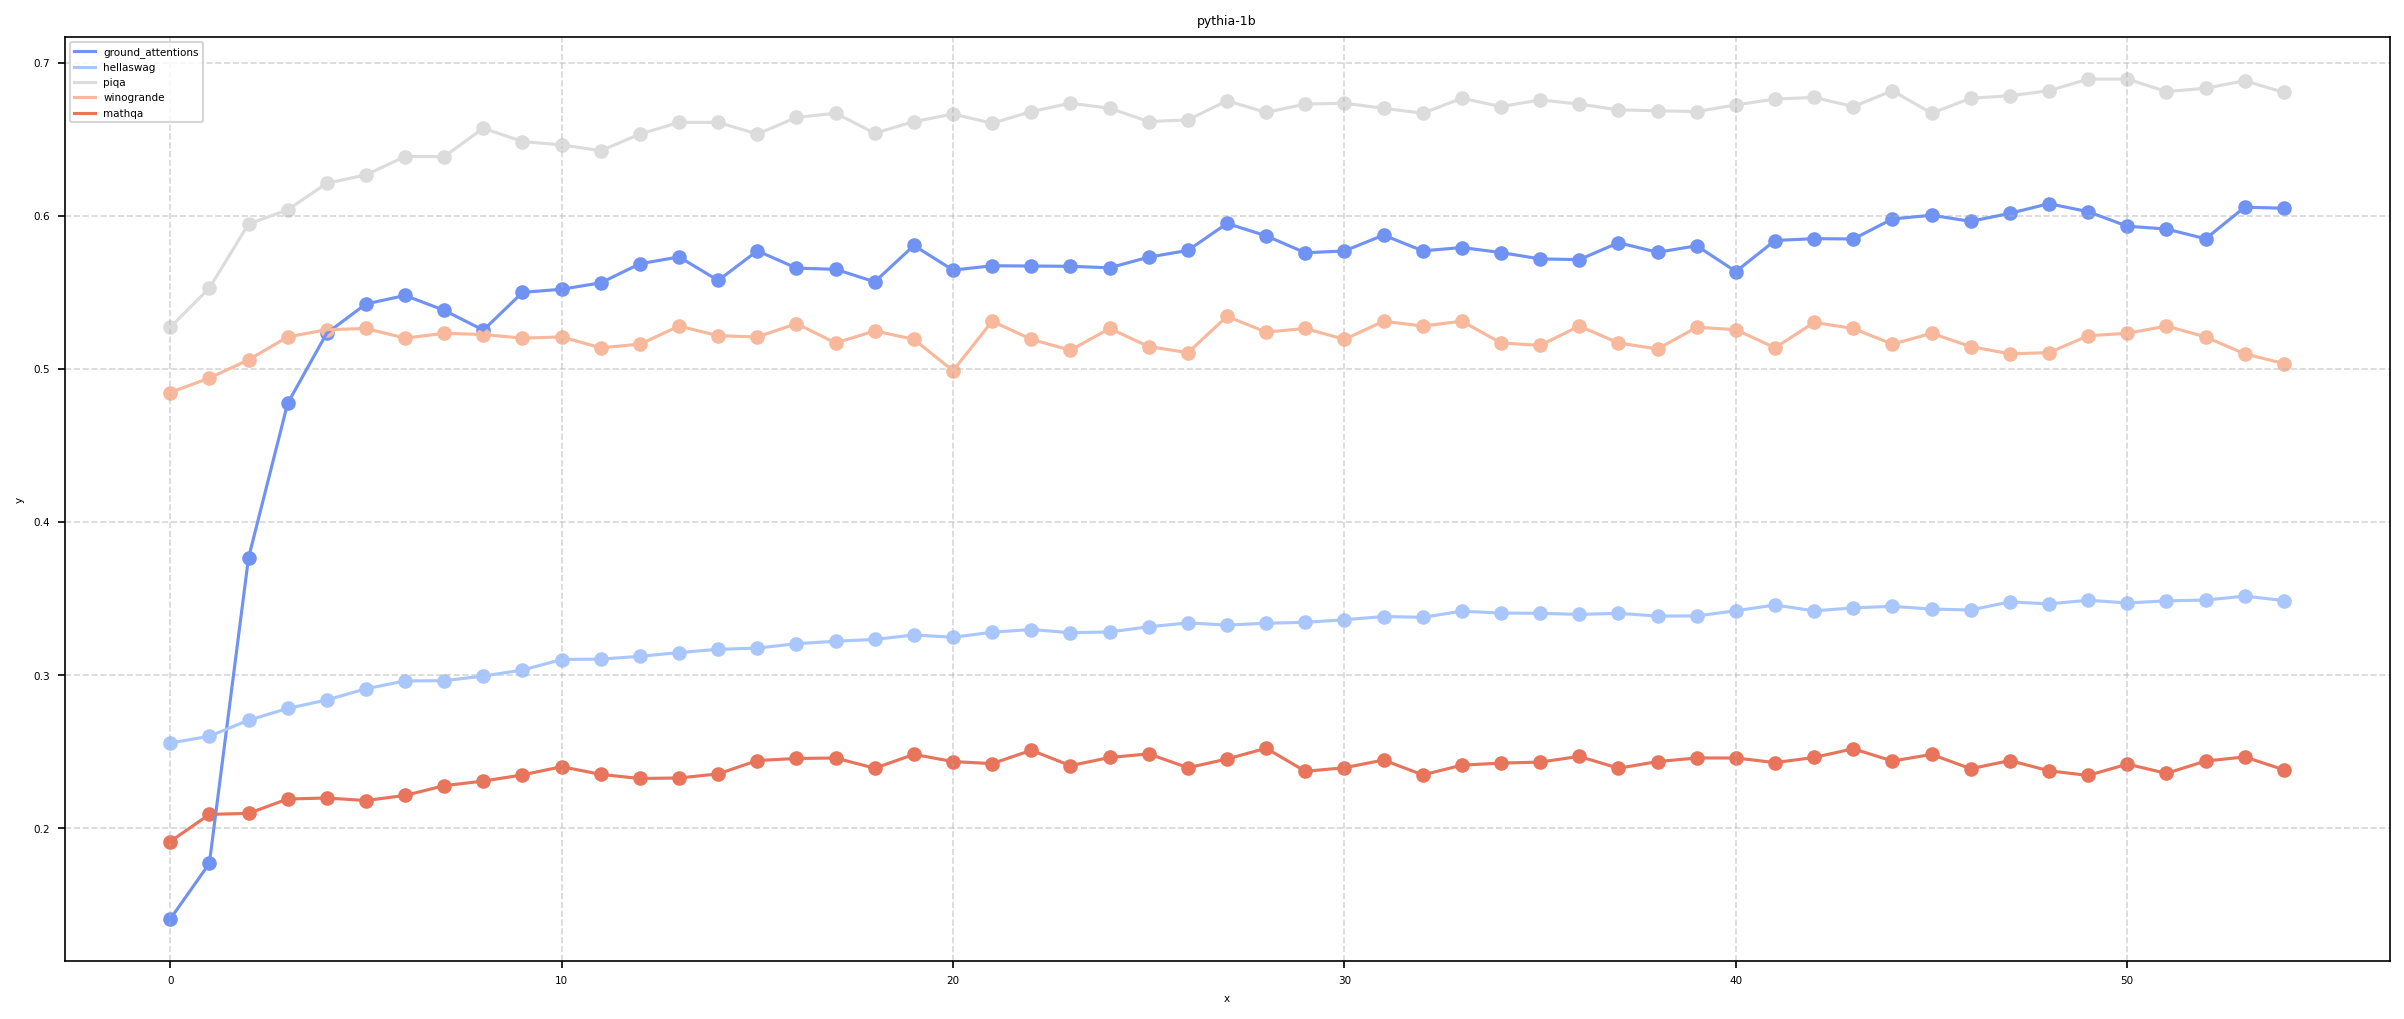

In [12]:
import pickle
eval_tasks = [
        "hellaswag",
        "piqa",
        "winogrande",
        "mathqa",
    ]
model_size_list = reversed(['1b','410m','70m','160m']) # '1b', '2.8b','70m', '160m','410m', '6.9b'
save_path = os.path.join(sys.path[0], './results/pythia_results.dat')
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        results_dict = pickle.load(f)
else : results_dict = {}
save_path = os.path.join(sys.path[0], './result/step_attn')
for model_size in model_size_list:
    model_name = f'EleutherAI/pythia-{model_size}'
    dist = []
    for revision in range(0, 143000, 1000):
        result_key = f'{model_name}_step{revision}'
        r = results_dict.get(result_key, None)
        if r is not None:
            attn = np.mean(r['ground_attentions'][:,:,0])
            model_data = np.hstack([attn]+[r[task] for task in eval_tasks])
            dist.append(model_data)
    dist = np.vstack(dist)
    # print(dist)
    plot_dist(dist,save_path=save_path, title=f'pythia-{model_size}',datalabel=['ground_attentions']+eval_tasks,show=True)